##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation based on the research paper titled [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5){:.external} (Luong et al., 2015). This is an advanced example that assumes some knowledge of:

* [Sequence-to-sequence](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf){:.external} models
* TensorFlow fundamentals below the Keras layer:
  * [Working with tensors](https://www.tensorflow.org/guide/tensor) directly
  * [Writing custom `keras.Model`s and `keras.layers`](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).

After training the model in this notebook, you will be able to input a Spanish sentence, such as "*¿todavia estan en casa?*", and return the English translation: "*are you still at home?*"

The resulting model is exportable as a `tf.saved_model`, so it can be used in other TensorFlow environments.

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

## Setup

In [2]:
!pip install "tensorflow-text==2.8.*"

  Using cached tensorflow_text-2.8.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.9 MB)


  Using cached tensorflow-2.8.2-cp39-cp39-manylinux2010_x86_64.whl (498.0 MB)


  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tensorflow_estimator-2.8.0-py2.py3-none-any.whl (462 kB)


  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)


  Using cached MarkupSafe-2.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0


    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0


  Attempting uninstall: keras
    Found existing installation: keras 2.9.0


    Uninstalling keras-2.9.0:


      Successfully uninstalled keras-2.9.0


  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1


    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.0rc0


    Uninstalling tensorflow-2.10.0rc0:


      Successfully uninstalled tensorflow-2.10.0rc0


In [3]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [4]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/){:.external}. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [5]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

  16384/2638744 [..............................] - ETA: 0s

2646016/2638744 [==============================] - 0s 0us/step


2654208/2638744 [==============================] - 0s 0us/step


In [6]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [7]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Tom y Mary se ayudaron mutuamente con los deberes.'
 b'Acordamos ese plan.' b'No puedo volver a hacerlo.'
 b'\xc3\x89l quiere un iPad 4.' b'Yo pago la cena.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom and Mary helped each other with their homework.'
 b'We agreed to the plan.' b"I can't do it again." b'He wants an iPad 4.'
 b"Dinner's on me."], shape=(5,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. 

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [11]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


Unicode normalization will be the first step in the text standardization function:

In [12]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [14]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [15]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [16]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Now these layers can convert a batch of strings into a batch of token IDs:

In [17]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   10,   33,   32,   17,    1, 2977,   27,   26,  746],
       [   2,    1,   97,  425,    4,    3,    0,    0,    0,    0],
       [   2,    9,   55,  358,    8,  198,    4,    3,    0,    0]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [18]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] tom y mary se [UNK] mutuamente con los deberes . [END]            '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

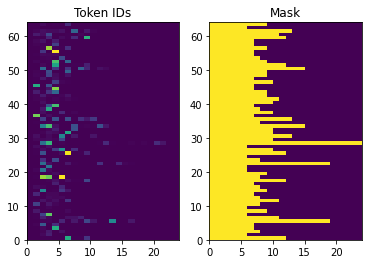

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [20]:
embedding_dim = 256
units = 1024

### The encoder

Start by building the encoder, the blue part of the diagram above.

The encoder:

1. Takes a list of token IDs (from `input_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a `layers.GRU`).
5. Returns:
  * The processed sequence. This will be passed to the attention head.
  * The internal state. This will be used to initialize the decoder


In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [22]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 24)
Encoder output, shape (batch, s, units): (64, 24, 1024)
Encoder state, shape (batch, units): (64, 1024)


The encoder returns its internal state so that its state can be used to initialize the decoder.

It's also common for an RNN to return its state so that it can process a sequence over multiple calls. You'll see more of that building the decoder.

### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="images/attention_equation_1.jpg" alt="attention equation 1" width="800">

<img src="images/attention_equation_2.jpg" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.


Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="images/attention_equation_4.jpg" alt="attention equation 4" width="800">

This tutorial uses [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf){:.external}. TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`. The class below handles the weight matrices in a pair of `layers.Dense` layers, and calls the built-in implementation.

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [24]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The `query`: This will be generated by the decoder, later.
* The `value`: This Will be the output of the encoder.
* The `mask`: To exclude the padding, `example_tokens != 0`

In [25]:
(example_tokens != 0).shape

TensorShape([64, 24])

The vectorized implementation of the attention layer lets you pass a batch of sequences of query vectors and a batch of sequence of value vectors. The result is:

1. A batch of sequences of result vectors the size of the queries.
2. A batch of attention maps with size `(query_length, value_length)`.

In [26]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 24)


The attention weights should sum to `1.0` for each sequence.

Here are the attention weights across the sequences at `t=0`:

Text(0.5, 1.0, 'Mask')

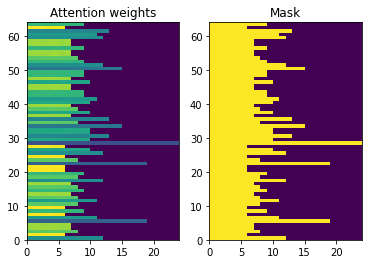

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [28]:
attention_weights.shape

TensorShape([64, 2, 24])

In [29]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

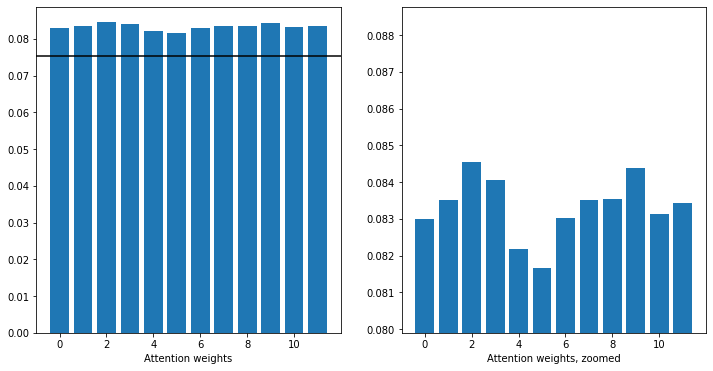

In [30]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
2. It uses an RNN to keep track of what it has generated so far.
3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.
4. It combines the RNN output and the context vector using Equation 3 (below) to generate the "attention vector".
5. It generates logit predictions for the next token based on the "attention vector".

<img src="images/attention_equation_3.jpg" alt="attention equation 3" width="800">


Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [32]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [33]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [34]:
Decoder.call = call

The **encoder** processes its full input sequence with a single call to its RNN. This implementation of the **decoder** _can_ do that as well for efficient training. But this tutorial will run the decoder in a loop for a few reasons:

* Flexibility: Writing the loop gives you direct control over the training procedure.
* Clarity: It's possible to do masking tricks and use `layers.RNN`, or `tfa.seq2seq` APIs to pack this all into a single call. But writing it out as a loop may be clearer.
  * Loop-free training is demonstrated in the [Text generation](text_generation.ipynb) tutorial.


Now try using this decoder.

In [35]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs.

* `new_tokens` -  The last token generated. Initialize the decoder with the `"[START]"` token.
* `enc_output` - Generated by the `Encoder`.
* `mask` - A boolean tensor indicating where `tokens != 0`
* `state` - The previous `state` output from the decoder (the internal state
  of the decoder's RNN). Pass `None` to zero-initialize it. The original
  paper initializes it from the encoder's final RNN state. 

In [36]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [37]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


Sample a token according to the logits:

In [38]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [39]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['letters'],
       ['attracted'],
       ['lady'],
       ['crime'],
       ['this']], dtype='<U16')

Now use the decoder to generate a second set of logits.

- Pass the same `enc_output` and `mask`, these haven't changed.
- Pass the sampled token as `new_tokens`.
- Pass the `decoder_state` the decoder returned last time, so the RNN continues with a memory of where it left off last time.


In [40]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [41]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['suspicious'],
       ['bald'],
       ['motivated'],
       ['definitely'],
       ['reported']], dtype='<U16')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [42]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

Start by subclassing `tf.keras.Model`, where the training process will be implemented as the `train_step` method on this `TrainTranslator` subclass of `tf.keras.Model`. Refer to [Customize what happens in `Model.fit`](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit) for details.

Here, the `train_step` method is a wrapper around the `_train_step` implementation which will come later. This wrapper includes a switch to turn on and off `tf.function` compilation to make debugging easier.

In [43]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Overall the implementation for the `Model.train_step` method is as follows:

1. Receive a batch of `input_text, target_text` from the `tf.data.Dataset`.
2. Convert those raw text inputs to token-embeddings and masks.
3. Run the encoder on the `input_tokens` to get the `encoder_output` and `encoder_state`.
4. Initialize the decoder state and loss.
5. Loop over the `target_tokens`:
   1. Run the decoder one step at a time.
   2. Calculate the loss for each step.
   3. Accumulate the average loss.
6. Calculate the gradient of the loss and use the optimizer to apply updates to the model's `trainable_variables`.

The `_preprocess` method, added below, implements steps #1 and #2: 

In [44]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [45]:
TrainTranslator._preprocess = _preprocess

The `_train_step` method, added below, handles the remaining steps except for actually running the decoder: 

In [46]:
def _train_step(self, inputs):
  input_text, target_text = inputs

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [47]:
TrainTranslator._train_step = _train_step

The `_loop_step` method, added below, executes the decoder and calculates the incremental loss and new decoder state (`dec_state`).

In [48]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [49]:
TrainTranslator._loop_step = _loop_step

### Test the training step

Build a `TrainTranslator`, and configure it for training using the `Model.compile` method:

In [50]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [51]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [52]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6307936>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.598738>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5392323>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3694654>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.728599>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.274465>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.77829>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6239724>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3668847>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1383567>}

CPU times: user 6.55 s, sys: 0 ns, total: 6.55 s
Wall time: 6.52 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [53]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [54]:
TrainTranslator._tf_train_step = _tf_train_step

In [55]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [56]:
translator.train_step([example_input_batch, example_target_batch])

2022-08-04 12:15:48.641343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-08-04 12:15:48.745874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-08-04 12:15:48.850818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-08-04 12:15:48.873993: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/PartitionedCall was passed variant from gradient_tape/while/while_grad/body/_531/gradient_tape/while/gradients/while/decoder_1/gru_3/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.009605>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [57]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0036325>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.01246>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9528773>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8428462>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7700226>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7392578>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6912892>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.645986>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.589823>}


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5579007>}

CPU times: user 4.61 s, sys: 809 ms, total: 5.42 s
Wall time: 1.93 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

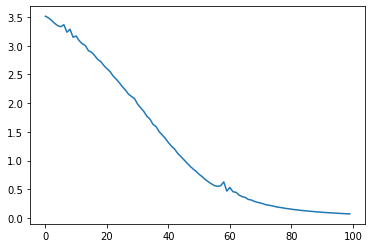

In [58]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [59]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code.

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [60]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [61]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3


2022-08-04 12:16:14.752714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
2022-08-04 12:16:14.863105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] layout failed: OUT_OF_RANGE: src_output = 25, but num_outputs is only 25


2022-08-04 12:16:14.974230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/TensorListPopBack_2:1 incompatible with expected float.
	when importing GraphDef to MLIR module in GrapplerHook
2022-08-04 12:16:15.000241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 6 of node StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/while/decoder_2/gru_5/PartitionedCall_grad/PartitionedCall was passed variant from StatefulPartitionedCall/gradient_tape/while/while_grad/body/_589/gradient_tape/while/gradients/wh

   1/1859 [..............................] - ETA: 2:44:35 - batch_loss: 7.5852

   2/1859 [..............................] - ETA: 4:20 - batch_loss: 7.5812   

   3/1859 [..............................] - ETA: 4:47 - batch_loss: 7.5825

   4/1859 [..............................] - ETA: 4:32 - batch_loss: 7.5352

   5/1859 [..............................] - ETA: 4:26 - batch_loss: 7.3999

   6/1859 [..............................] - ETA: 4:27 - batch_loss: 7.1391

   7/1859 [..............................] - ETA: 4:24 - batch_loss: 6.9071

   8/1859 [..............................] - ETA: 4:28 - batch_loss: 6.7095

   9/1859 [..............................] - ETA: 4:24 - batch_loss: 6.5459

  10/1859 [..............................] - ETA: 4:32 - batch_loss: 6.4290

  11/1859 [..............................] - ETA: 4:31 - batch_loss: 6.3134

  12/1859 [..............................] - ETA: 4:25 - batch_loss: 6.1929

  13/1859 [..............................] - ETA: 4:27 - batch_loss: 6.0879

  14/1859 [..............................] - ETA: 4:35 - batch_loss: 6.0222

  15/1859 [..............................] - ETA: 4:41 - batch_loss: 5.9560

  16/1859 [..............................] - ETA: 4:42 - batch_loss: 5.8940

  17/1859 [..............................] - ETA: 4:40 - batch_loss: 5.8348

  18/1859 [..............................] - ETA: 4:42 - batch_loss: 5.7766

  19/1859 [..............................] - ETA: 4:51 - batch_loss: 5.7343

  20/1859 [..............................] - ETA: 4:52 - batch_loss: 5.6855

  21/1859 [..............................] - ETA: 4:53 - batch_loss: 5.6429

  22/1859 [..............................] - ETA: 4:52 - batch_loss: 5.6024

  23/1859 [..............................] - ETA: 4:52 - batch_loss: 5.5676

  24/1859 [..............................] - ETA: 4:52 - batch_loss: 5.5275

  25/1859 [..............................] - ETA: 4:51 - batch_loss: 5.4963

  26/1859 [..............................] - ETA: 4:51 - batch_loss: 5.4620

  27/1859 [..............................] - ETA: 4:49 - batch_loss: 5.4305

  28/1859 [..............................] - ETA: 4:49 - batch_loss: 5.3955

  29/1859 [..............................] - ETA: 4:48 - batch_loss: 5.3659

  30/1859 [..............................] - ETA: 4:47 - batch_loss: 5.3341

  31/1859 [..............................] - ETA: 4:47 - batch_loss: 5.3053

  32/1859 [..............................] - ETA: 4:44 - batch_loss: 5.2775

  33/1859 [..............................] - ETA: 4:45 - batch_loss: 5.2506

  34/1859 [..............................] - ETA: 4:45 - batch_loss: 5.2264

  35/1859 [..............................] - ETA: 4:43 - batch_loss: 5.2014

  36/1859 [..............................] - ETA: 4:44 - batch_loss: 5.1805

  37/1859 [..............................] - ETA: 4:45 - batch_loss: 5.1654

  38/1859 [..............................] - ETA: 4:48 - batch_loss: 5.1441

  39/1859 [..............................] - ETA: 4:47 - batch_loss: 5.1203

  40/1859 [..............................] - ETA: 4:46 - batch_loss: 5.1034

  41/1859 [..............................] - ETA: 4:51 - batch_loss: 5.0842

  42/1859 [..............................] - ETA: 4:51 - batch_loss: 5.0664

  43/1859 [..............................] - ETA: 4:51 - batch_loss: 5.0534

  44/1859 [..............................] - ETA: 4:50 - batch_loss: 5.0349

  45/1859 [..............................] - ETA: 4:48 - batch_loss: 5.0181

  46/1859 [..............................] - ETA: 4:49 - batch_loss: 5.0017

  47/1859 [..............................] - ETA: 4:50 - batch_loss: 4.9914

  48/1859 [..............................] - ETA: 4:49 - batch_loss: 4.9762

  49/1859 [..............................] - ETA: 4:47 - batch_loss: 4.9608

  50/1859 [..............................] - ETA: 4:51 - batch_loss: 4.9481

  51/1859 [..............................] - ETA: 4:52 - batch_loss: 4.9375

  52/1859 [..............................] - ETA: 4:51 - batch_loss: 4.9230

  53/1859 [..............................] - ETA: 4:55 - batch_loss: 4.9121

  54/1859 [..............................] - ETA: 4:54 - batch_loss: 4.9007

  55/1859 [..............................] - ETA: 4:53 - batch_loss: 4.8909

  56/1859 [..............................] - ETA: 4:53 - batch_loss: 4.8832

  57/1859 [..............................] - ETA: 4:52 - batch_loss: 4.8691

  58/1859 [..............................] - ETA: 4:51 - batch_loss: 4.8584

  59/1859 [..............................] - ETA: 4:51 - batch_loss: 4.8491

  60/1859 [..............................] - ETA: 4:51 - batch_loss: 4.8366

  61/1859 [..............................] - ETA: 4:53 - batch_loss: 4.8267

  62/1859 [>.............................] - ETA: 4:52 - batch_loss: 4.8186

  63/1859 [>.............................] - ETA: 4:54 - batch_loss: 4.8097

  64/1859 [>.............................] - ETA: 4:53 - batch_loss: 4.7998

  65/1859 [>.............................] - ETA: 4:52 - batch_loss: 4.7901

  66/1859 [>.............................] - ETA: 4:52 - batch_loss: 4.7795

  67/1859 [>.............................] - ETA: 4:52 - batch_loss: 4.7711

  68/1859 [>.............................] - ETA: 4:50 - batch_loss: 4.7593

  69/1859 [>.............................] - ETA: 4:49 - batch_loss: 4.7490

  70/1859 [>.............................] - ETA: 4:48 - batch_loss: 4.7377

  71/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.7287

  72/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.7214

  73/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.7130

  74/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.7054

  75/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6971

  76/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6894

  77/1859 [>.............................] - ETA: 4:45 - batch_loss: 4.6814

  78/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6737

  79/1859 [>.............................] - ETA: 4:45 - batch_loss: 4.6669

  80/1859 [>.............................] - ETA: 4:45 - batch_loss: 4.6611

  81/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6531

  82/1859 [>.............................] - ETA: 4:49 - batch_loss: 4.6463

  83/1859 [>.............................] - ETA: 4:49 - batch_loss: 4.6388

  84/1859 [>.............................] - ETA: 4:48 - batch_loss: 4.6333

  85/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.6268

  86/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6179

  87/1859 [>.............................] - ETA: 4:47 - batch_loss: 4.6095

  88/1859 [>.............................] - ETA: 4:46 - batch_loss: 4.6025

  89/1859 [>.............................] - ETA: 4:45 - batch_loss: 4.5965

  90/1859 [>.............................] - ETA: 4:45 - batch_loss: 4.5895

  91/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5824

  92/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5733

  93/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5695

  94/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5628

  95/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5570

  96/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5512

  97/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5461

  98/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5402

  99/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5364

 100/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5297

 101/1859 [>.............................] - ETA: 4:44 - batch_loss: 4.5252

 102/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5176

 103/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5120

 104/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5073

 105/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.5015

 106/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4955

 107/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4921

 108/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4874

 109/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4827

 110/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4779

 111/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4718

 112/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4676

 113/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4637

 114/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4591

 115/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4538

 116/1859 [>.............................] - ETA: 4:43 - batch_loss: 4.4479

 117/1859 [>.............................] - ETA: 4:42 - batch_loss: 4.4436

 118/1859 [>.............................] - ETA: 4:42 - batch_loss: 4.4375

 119/1859 [>.............................] - ETA: 4:42 - batch_loss: 4.4311

 120/1859 [>.............................] - ETA: 4:41 - batch_loss: 4.4273

 121/1859 [>.............................] - ETA: 4:41 - batch_loss: 4.4218

 122/1859 [>.............................] - ETA: 4:40 - batch_loss: 4.4168

 123/1859 [>.............................] - ETA: 4:40 - batch_loss: 4.4124

 124/1859 [=>............................] - ETA: 4:40 - batch_loss: 4.4071

 125/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.4020

 126/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3971

 127/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3927

 128/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3876

 129/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3836

 130/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3779

 131/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3754

 132/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3725

 133/1859 [=>............................] - ETA: 4:40 - batch_loss: 4.3689

 134/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3645

 135/1859 [=>............................] - ETA: 4:39 - batch_loss: 4.3596

 136/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3553

 137/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3514

 138/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3476

 139/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3440

 140/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3401

 141/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3366

 142/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3318

 143/1859 [=>............................] - ETA: 4:38 - batch_loss: 4.3271

 144/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.3215

 145/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.3185

 146/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.3144

 147/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.3103

 148/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.3059

 149/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.3023

 150/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2965

 151/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2920

 152/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2891

 153/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2856

 154/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2820

 155/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2782

 156/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2741

 157/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2699

 158/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2643

 159/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2604

 160/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2577

 161/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2542

 162/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2509

 163/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2466

 164/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2429

 165/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2395

 166/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.2359

 167/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2329

 168/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2287

 169/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2271

 170/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.2233

 171/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.2199

 172/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.2165

 173/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2131

 174/1859 [=>............................] - ETA: 4:37 - batch_loss: 4.2099

 175/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2059

 176/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.2016

 177/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.1975

 178/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.1946

 179/1859 [=>............................] - ETA: 4:36 - batch_loss: 4.1918

 180/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1876

 181/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1837

 182/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1814

 183/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1777

 184/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1738

 185/1859 [=>............................] - ETA: 4:35 - batch_loss: 4.1705

 186/1859 [==>...........................] - ETA: 4:35 - batch_loss: 4.1661

 187/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1629

 188/1859 [==>...........................] - ETA: 4:35 - batch_loss: 4.1592

 189/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1549

 190/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1504

 191/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1480

 192/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1444

 193/1859 [==>...........................] - ETA: 4:34 - batch_loss: 4.1403

 194/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1372

 195/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1339

 196/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1292

 197/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1259

 198/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1227

 199/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1199

 200/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1166

 201/1859 [==>...........................] - ETA: 4:33 - batch_loss: 4.1127

 202/1859 [==>...........................] - ETA: 4:32 - batch_loss: 4.1091

 203/1859 [==>...........................] - ETA: 4:32 - batch_loss: 4.1053

 204/1859 [==>...........................] - ETA: 4:31 - batch_loss: 4.1002

 205/1859 [==>...........................] - ETA: 4:31 - batch_loss: 4.0957

 206/1859 [==>...........................] - ETA: 4:31 - batch_loss: 4.0924

 207/1859 [==>...........................] - ETA: 4:31 - batch_loss: 4.0900

 208/1859 [==>...........................] - ETA: 4:31 - batch_loss: 4.0876

 209/1859 [==>...........................] - ETA: 4:30 - batch_loss: 4.0832

 210/1859 [==>...........................] - ETA: 4:30 - batch_loss: 4.0792

 211/1859 [==>...........................] - ETA: 4:29 - batch_loss: 4.0758

 212/1859 [==>...........................] - ETA: 4:29 - batch_loss: 4.0711

 213/1859 [==>...........................] - ETA: 4:29 - batch_loss: 4.0678

 214/1859 [==>...........................] - ETA: 4:29 - batch_loss: 4.0641

 215/1859 [==>...........................] - ETA: 4:28 - batch_loss: 4.0604

 216/1859 [==>...........................] - ETA: 4:28 - batch_loss: 4.0564

 217/1859 [==>...........................] - ETA: 4:28 - batch_loss: 4.0529

 218/1859 [==>...........................] - ETA: 4:28 - batch_loss: 4.0501

 219/1859 [==>...........................] - ETA: 4:27 - batch_loss: 4.0460

 220/1859 [==>...........................] - ETA: 4:27 - batch_loss: 4.0427

 221/1859 [==>...........................] - ETA: 4:27 - batch_loss: 4.0399

 222/1859 [==>...........................] - ETA: 4:27 - batch_loss: 4.0366

 223/1859 [==>...........................] - ETA: 4:26 - batch_loss: 4.0335

 224/1859 [==>...........................] - ETA: 4:26 - batch_loss: 4.0300

 225/1859 [==>...........................] - ETA: 4:26 - batch_loss: 4.0261

 226/1859 [==>...........................] - ETA: 4:26 - batch_loss: 4.0234

 227/1859 [==>...........................] - ETA: 4:26 - batch_loss: 4.0204

 228/1859 [==>...........................] - ETA: 4:25 - batch_loss: 4.0170

 229/1859 [==>...........................] - ETA: 4:25 - batch_loss: 4.0134

 230/1859 [==>...........................] - ETA: 4:25 - batch_loss: 4.0096

 231/1859 [==>...........................] - ETA: 4:25 - batch_loss: 4.0052

 232/1859 [==>...........................] - ETA: 4:24 - batch_loss: 4.0003

 233/1859 [==>...........................] - ETA: 4:24 - batch_loss: 3.9960

 234/1859 [==>...........................] - ETA: 4:24 - batch_loss: 3.9916

 235/1859 [==>...........................] - ETA: 4:23 - batch_loss: 3.9889

 236/1859 [==>...........................] - ETA: 4:23 - batch_loss: 3.9857

 237/1859 [==>...........................] - ETA: 4:23 - batch_loss: 3.9826

 238/1859 [==>...........................] - ETA: 4:23 - batch_loss: 3.9793

 239/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9749

 240/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9721

 241/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9677

 242/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9647

 243/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9619

 244/1859 [==>...........................] - ETA: 4:21 - batch_loss: 3.9582

 245/1859 [==>...........................] - ETA: 4:21 - batch_loss: 3.9549

 246/1859 [==>...........................] - ETA: 4:22 - batch_loss: 3.9515

 247/1859 [==>...........................] - ETA: 4:21 - batch_loss: 3.9477

 248/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9444

 249/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9422

 250/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9392

 251/1859 [===>..........................] - ETA: 4:20 - batch_loss: 3.9361

 252/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9338

 253/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9312

 254/1859 [===>..........................] - ETA: 4:22 - batch_loss: 3.9281

 255/1859 [===>..........................] - ETA: 4:22 - batch_loss: 3.9250

 256/1859 [===>..........................] - ETA: 4:22 - batch_loss: 3.9213

 257/1859 [===>..........................] - ETA: 4:22 - batch_loss: 3.9180

 258/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9142

 259/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9115

 260/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9084

 261/1859 [===>..........................] - ETA: 4:21 - batch_loss: 3.9054

 262/1859 [===>..........................] - ETA: 4:20 - batch_loss: 3.9021

 263/1859 [===>..........................] - ETA: 4:20 - batch_loss: 3.8982

 264/1859 [===>..........................] - ETA: 4:20 - batch_loss: 3.8957

 265/1859 [===>..........................] - ETA: 4:19 - batch_loss: 3.8928

 266/1859 [===>..........................] - ETA: 4:19 - batch_loss: 3.8897

 267/1859 [===>..........................] - ETA: 4:19 - batch_loss: 3.8861

 268/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8830

 269/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8807

 270/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8771

 271/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8745

 272/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8725

 273/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8702

 274/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8668

 275/1859 [===>..........................] - ETA: 4:18 - batch_loss: 3.8649

 276/1859 [===>..........................] - ETA: 4:17 - batch_loss: 3.8621

 277/1859 [===>..........................] - ETA: 4:17 - batch_loss: 3.8592

 278/1859 [===>..........................] - ETA: 4:17 - batch_loss: 3.8556

 279/1859 [===>..........................] - ETA: 4:17 - batch_loss: 3.8527

 280/1859 [===>..........................] - ETA: 4:17 - batch_loss: 3.8502

 281/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8465

 282/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8437

 283/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8415

 284/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8397

 285/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8364

 286/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8330

 287/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8301

 288/1859 [===>..........................] - ETA: 4:16 - batch_loss: 3.8270

 289/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8246

 290/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8216

 291/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8178

 292/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8152

 293/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8128

 294/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8103

 295/1859 [===>..........................] - ETA: 4:15 - batch_loss: 3.8070

 296/1859 [===>..........................] - ETA: 4:14 - batch_loss: 3.8044

 297/1859 [===>..........................] - ETA: 4:14 - batch_loss: 3.8013

 298/1859 [===>..........................] - ETA: 4:14 - batch_loss: 3.7985

 299/1859 [===>..........................] - ETA: 4:14 - batch_loss: 3.7965

 300/1859 [===>..........................] - ETA: 4:14 - batch_loss: 3.7946

 301/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7918

 302/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7888

 303/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7866

 304/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7841

 305/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7816

 306/1859 [===>..........................] - ETA: 4:13 - batch_loss: 3.7789

 307/1859 [===>..........................] - ETA: 4:12 - batch_loss: 3.7765

 308/1859 [===>..........................] - ETA: 4:12 - batch_loss: 3.7736

 309/1859 [===>..........................] - ETA: 4:12 - batch_loss: 3.7704

 310/1859 [====>.........................] - ETA: 4:12 - batch_loss: 3.7678

 311/1859 [====>.........................] - ETA: 4:12 - batch_loss: 3.7648

 312/1859 [====>.........................] - ETA: 4:12 - batch_loss: 3.7627

 313/1859 [====>.........................] - ETA: 4:11 - batch_loss: 3.7602

 314/1859 [====>.........................] - ETA: 4:11 - batch_loss: 3.7576

 315/1859 [====>.........................] - ETA: 4:11 - batch_loss: 3.7547

 316/1859 [====>.........................] - ETA: 4:11 - batch_loss: 3.7524

 317/1859 [====>.........................] - ETA: 4:10 - batch_loss: 3.7500

 318/1859 [====>.........................] - ETA: 4:10 - batch_loss: 3.7472

 319/1859 [====>.........................] - ETA: 4:10 - batch_loss: 3.7441

 320/1859 [====>.........................] - ETA: 4:10 - batch_loss: 3.7405

 321/1859 [====>.........................] - ETA: 4:10 - batch_loss: 3.7381

 322/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7355

 323/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7319

 324/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7287

 325/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7261

 326/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7241

 327/1859 [====>.........................] - ETA: 4:09 - batch_loss: 3.7213

 328/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7179

 329/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7147

 330/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7122

 331/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7097

 332/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7074

 333/1859 [====>.........................] - ETA: 4:08 - batch_loss: 3.7044

 334/1859 [====>.........................] - ETA: 4:07 - batch_loss: 3.7015

 335/1859 [====>.........................] - ETA: 4:07 - batch_loss: 3.6983

 336/1859 [====>.........................] - ETA: 4:07 - batch_loss: 3.6958

 337/1859 [====>.........................] - ETA: 4:07 - batch_loss: 3.6933

 338/1859 [====>.........................] - ETA: 4:07 - batch_loss: 3.6908

 339/1859 [====>.........................] - ETA: 4:06 - batch_loss: 3.6878

 340/1859 [====>.........................] - ETA: 4:06 - batch_loss: 3.6855

 341/1859 [====>.........................] - ETA: 4:06 - batch_loss: 3.6822

 342/1859 [====>.........................] - ETA: 4:06 - batch_loss: 3.6795

 343/1859 [====>.........................] - ETA: 4:06 - batch_loss: 3.6771

 344/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6749

 345/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6728

 346/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6704

 347/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6683

 348/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6654

 349/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6625

 350/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6601

 351/1859 [====>.........................] - ETA: 4:05 - batch_loss: 3.6577

 352/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6546

 353/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6520

 354/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6498

 355/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6470

 356/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6443

 357/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6418

 358/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6397

 359/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6382

 360/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6354

 361/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6324

 362/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6302

 363/1859 [====>.........................] - ETA: 4:04 - batch_loss: 3.6275

 364/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6247

 365/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6225

 366/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6204

 367/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6181

 368/1859 [====>.........................] - ETA: 4:03 - batch_loss: 3.6158

 369/1859 [====>.........................] - ETA: 4:02 - batch_loss: 3.6134

 370/1859 [====>.........................] - ETA: 4:02 - batch_loss: 3.6109

 371/1859 [====>.........................] - ETA: 4:02 - batch_loss: 3.6081

 372/1859 [=====>........................] - ETA: 4:02 - batch_loss: 3.6060

 373/1859 [=====>........................] - ETA: 4:02 - batch_loss: 3.6034

 374/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.6000

 375/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5973

 376/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5943

 377/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5918

 378/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5889

 379/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5874

 380/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5848

 381/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5823

 382/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5801

 383/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5777

 384/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5755

 385/1859 [=====>........................] - ETA: 4:01 - batch_loss: 3.5730

 386/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5704

 387/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5681

 388/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5657

 389/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5636

 390/1859 [=====>........................] - ETA: 4:00 - batch_loss: 3.5612

 391/1859 [=====>........................] - ETA: 3:59 - batch_loss: 3.5592

 392/1859 [=====>........................] - ETA: 3:59 - batch_loss: 3.5568

 393/1859 [=====>........................] - ETA: 3:59 - batch_loss: 3.5544

 394/1859 [=====>........................] - ETA: 3:59 - batch_loss: 3.5516

 395/1859 [=====>........................] - ETA: 3:59 - batch_loss: 3.5491

 396/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5466

 397/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5440

 398/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5419

 399/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5391

 400/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5368

 401/1859 [=====>........................] - ETA: 3:58 - batch_loss: 3.5348

 402/1859 [=====>........................] - ETA: 3:57 - batch_loss: 3.5323

 403/1859 [=====>........................] - ETA: 3:57 - batch_loss: 3.5295

 404/1859 [=====>........................] - ETA: 3:57 - batch_loss: 3.5272

 405/1859 [=====>........................] - ETA: 3:57 - batch_loss: 3.5246

 406/1859 [=====>........................] - ETA: 3:56 - batch_loss: 3.5224

 407/1859 [=====>........................] - ETA: 3:56 - batch_loss: 3.5203

 408/1859 [=====>........................] - ETA: 3:56 - batch_loss: 3.5180

 409/1859 [=====>........................] - ETA: 3:56 - batch_loss: 3.5156

 410/1859 [=====>........................] - ETA: 3:56 - batch_loss: 3.5131

 411/1859 [=====>........................] - ETA: 3:55 - batch_loss: 3.5111

 412/1859 [=====>........................] - ETA: 3:55 - batch_loss: 3.5087

 413/1859 [=====>........................] - ETA: 3:55 - batch_loss: 3.5063

 414/1859 [=====>........................] - ETA: 3:55 - batch_loss: 3.5040

 415/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.5020

 416/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4997

 417/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4977

 418/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4950

 419/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4927

 420/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4899

 421/1859 [=====>........................] - ETA: 3:54 - batch_loss: 3.4870

 422/1859 [=====>........................] - ETA: 3:53 - batch_loss: 3.4848

 423/1859 [=====>........................] - ETA: 3:53 - batch_loss: 3.4823

 424/1859 [=====>........................] - ETA: 3:53 - batch_loss: 3.4796

 425/1859 [=====>........................] - ETA: 3:53 - batch_loss: 3.4775

 426/1859 [=====>........................] - ETA: 3:53 - batch_loss: 3.4756

 427/1859 [=====>........................] - ETA: 3:52 - batch_loss: 3.4733

 428/1859 [=====>........................] - ETA: 3:52 - batch_loss: 3.4708

 429/1859 [=====>........................] - ETA: 3:52 - batch_loss: 3.4686

 430/1859 [=====>........................] - ETA: 3:52 - batch_loss: 3.4668

 431/1859 [=====>........................] - ETA: 3:51 - batch_loss: 3.4643

 432/1859 [=====>........................] - ETA: 3:51 - batch_loss: 3.4620

 433/1859 [=====>........................] - ETA: 3:51 - batch_loss: 3.4599

 434/1859 [======>.......................] - ETA: 3:51 - batch_loss: 3.4577

 435/1859 [======>.......................] - ETA: 3:51 - batch_loss: 3.4558

 436/1859 [======>.......................] - ETA: 3:51 - batch_loss: 3.4533

 437/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4512

 438/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4489

 439/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4463

 440/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4442

 441/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4422

 442/1859 [======>.......................] - ETA: 3:50 - batch_loss: 3.4402

 443/1859 [======>.......................] - ETA: 3:49 - batch_loss: 3.4380

 444/1859 [======>.......................] - ETA: 3:49 - batch_loss: 3.4354

 445/1859 [======>.......................] - ETA: 3:49 - batch_loss: 3.4326

 446/1859 [======>.......................] - ETA: 3:49 - batch_loss: 3.4304

 447/1859 [======>.......................] - ETA: 3:48 - batch_loss: 3.4280

 448/1859 [======>.......................] - ETA: 3:48 - batch_loss: 3.4257

 449/1859 [======>.......................] - ETA: 3:48 - batch_loss: 3.4234

 450/1859 [======>.......................] - ETA: 3:48 - batch_loss: 3.4214

 451/1859 [======>.......................] - ETA: 3:48 - batch_loss: 3.4191

 452/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4172

 453/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4148

 454/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4130

 455/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4109

 456/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4087

 457/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4062

 458/1859 [======>.......................] - ETA: 3:47 - batch_loss: 3.4041

 459/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.4021

 460/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3992

 461/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3971

 462/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3952

 463/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3930

 464/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3912

 465/1859 [======>.......................] - ETA: 3:46 - batch_loss: 3.3888

 466/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3868

 467/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3842

 468/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3823

 469/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3802

 470/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3779

 471/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3753

 472/1859 [======>.......................] - ETA: 3:45 - batch_loss: 3.3726

 473/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3701

 474/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3680

 475/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3652

 476/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3628

 477/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3604

 478/1859 [======>.......................] - ETA: 3:44 - batch_loss: 3.3581

 479/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3561

 480/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3539

 481/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3513

 482/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3489

 483/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3470

 484/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3443

 485/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3419

 486/1859 [======>.......................] - ETA: 3:43 - batch_loss: 3.3397

 487/1859 [======>.......................] - ETA: 3:42 - batch_loss: 3.3377

 488/1859 [======>.......................] - ETA: 3:42 - batch_loss: 3.3358

 489/1859 [======>.......................] - ETA: 3:42 - batch_loss: 3.3338

 490/1859 [======>.......................] - ETA: 3:42 - batch_loss: 3.3312

 491/1859 [======>.......................] - ETA: 3:42 - batch_loss: 3.3289

 492/1859 [======>.......................] - ETA: 3:41 - batch_loss: 3.3268

 493/1859 [======>.......................] - ETA: 3:41 - batch_loss: 3.3253

 494/1859 [======>.......................] - ETA: 3:41 - batch_loss: 3.3232

 495/1859 [======>.......................] - ETA: 3:41 - batch_loss: 3.3209

 496/1859 [=======>......................] - ETA: 3:41 - batch_loss: 3.3189

 497/1859 [=======>......................] - ETA: 3:41 - batch_loss: 3.3170

 498/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3149

 499/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3128

 500/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3103

 501/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3084

 502/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3068

 503/1859 [=======>......................] - ETA: 3:40 - batch_loss: 3.3049

 504/1859 [=======>......................] - ETA: 3:39 - batch_loss: 3.3031

 505/1859 [=======>......................] - ETA: 3:39 - batch_loss: 3.3013

 506/1859 [=======>......................] - ETA: 3:39 - batch_loss: 3.2995

 507/1859 [=======>......................] - ETA: 3:39 - batch_loss: 3.2973

 508/1859 [=======>......................] - ETA: 3:39 - batch_loss: 3.2951

 509/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2930

 510/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2918

 511/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2898

 512/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2878

 513/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2869

 514/1859 [=======>......................] - ETA: 3:38 - batch_loss: 3.2848

 515/1859 [=======>......................] - ETA: 3:37 - batch_loss: 3.2826

 516/1859 [=======>......................] - ETA: 3:37 - batch_loss: 3.2805

 517/1859 [=======>......................] - ETA: 3:37 - batch_loss: 3.2781

 518/1859 [=======>......................] - ETA: 3:37 - batch_loss: 3.2761

 519/1859 [=======>......................] - ETA: 3:37 - batch_loss: 3.2742

 520/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2724

 521/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2704

 522/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2685

 523/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2664

 524/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2641

 525/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2621

 526/1859 [=======>......................] - ETA: 3:36 - batch_loss: 3.2595

 527/1859 [=======>......................] - ETA: 3:35 - batch_loss: 3.2574

 528/1859 [=======>......................] - ETA: 3:35 - batch_loss: 3.2556

 529/1859 [=======>......................] - ETA: 3:35 - batch_loss: 3.2535

 530/1859 [=======>......................] - ETA: 3:35 - batch_loss: 3.2512

 531/1859 [=======>......................] - ETA: 3:35 - batch_loss: 3.2491

 532/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2474

 533/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2455

 534/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2435

 535/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2418

 536/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2402

 537/1859 [=======>......................] - ETA: 3:34 - batch_loss: 3.2376

 538/1859 [=======>......................] - ETA: 3:33 - batch_loss: 3.2354

 539/1859 [=======>......................] - ETA: 3:33 - batch_loss: 3.2334

 540/1859 [=======>......................] - ETA: 3:33 - batch_loss: 3.2316

 541/1859 [=======>......................] - ETA: 3:33 - batch_loss: 3.2295

 542/1859 [=======>......................] - ETA: 3:33 - batch_loss: 3.2276

 543/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2255

 544/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2235

 545/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2212

 546/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2192

 547/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2171

 548/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2158

 549/1859 [=======>......................] - ETA: 3:32 - batch_loss: 3.2141

 550/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2125

 551/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2109

 552/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2087

 553/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2063

 554/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2047

 555/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2032

 556/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.2011

 557/1859 [=======>......................] - ETA: 3:31 - batch_loss: 3.1991

 558/1859 [========>.....................] - ETA: 3:31 - batch_loss: 3.1977

 559/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1961

 560/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1942

 561/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1926

 562/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1906

 563/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1886

 564/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1867

 565/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1849

 566/1859 [========>.....................] - ETA: 3:30 - batch_loss: 3.1835

 567/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1814

 568/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1792

 569/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1770

 570/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1749

 571/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1732

 572/1859 [========>.....................] - ETA: 3:29 - batch_loss: 3.1716

 573/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1697

 574/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1678

 575/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1658

 576/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1638

 577/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1619

 578/1859 [========>.....................] - ETA: 3:28 - batch_loss: 3.1600

 579/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1584

 580/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1560

 581/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1544

 582/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1521

 583/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1497

 584/1859 [========>.....................] - ETA: 3:27 - batch_loss: 3.1480

 585/1859 [========>.....................] - ETA: 3:26 - batch_loss: 3.1463

 586/1859 [========>.....................] - ETA: 3:26 - batch_loss: 3.1447

 587/1859 [========>.....................] - ETA: 3:26 - batch_loss: 3.1429

 588/1859 [========>.....................] - ETA: 3:26 - batch_loss: 3.1411

 589/1859 [========>.....................] - ETA: 3:26 - batch_loss: 3.1394

 590/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1378

 591/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1362

 592/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1345

 593/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1325

 594/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1304

 595/1859 [========>.....................] - ETA: 3:25 - batch_loss: 3.1284

 596/1859 [========>.....................] - ETA: 3:24 - batch_loss: 3.1261

 597/1859 [========>.....................] - ETA: 3:24 - batch_loss: 3.1242

 598/1859 [========>.....................] - ETA: 3:24 - batch_loss: 3.1220

 599/1859 [========>.....................] - ETA: 3:24 - batch_loss: 3.1201

 600/1859 [========>.....................] - ETA: 3:24 - batch_loss: 3.1184

 601/1859 [========>.....................] - ETA: 3:23 - batch_loss: 3.1165

 602/1859 [========>.....................] - ETA: 3:23 - batch_loss: 3.1144

 603/1859 [========>.....................] - ETA: 3:23 - batch_loss: 3.1123

 604/1859 [========>.....................] - ETA: 3:23 - batch_loss: 3.1104

 605/1859 [========>.....................] - ETA: 3:23 - batch_loss: 3.1087

 606/1859 [========>.....................] - ETA: 3:22 - batch_loss: 3.1070

 607/1859 [========>.....................] - ETA: 3:22 - batch_loss: 3.1056

 608/1859 [========>.....................] - ETA: 3:22 - batch_loss: 3.1040

 609/1859 [========>.....................] - ETA: 3:22 - batch_loss: 3.1018

 610/1859 [========>.....................] - ETA: 3:22 - batch_loss: 3.1004

 611/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0984

 612/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0966

 613/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0947

 614/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0929

 615/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0911

 616/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0891

 617/1859 [========>.....................] - ETA: 3:21 - batch_loss: 3.0876

 618/1859 [========>.....................] - ETA: 3:20 - batch_loss: 3.0859

 619/1859 [========>.....................] - ETA: 3:20 - batch_loss: 3.0841

 620/1859 [=========>....................] - ETA: 3:20 - batch_loss: 3.0821

 621/1859 [=========>....................] - ETA: 3:20 - batch_loss: 3.0804

 622/1859 [=========>....................] - ETA: 3:20 - batch_loss: 3.0791

 623/1859 [=========>....................] - ETA: 3:20 - batch_loss: 3.0773

 624/1859 [=========>....................] - ETA: 3:19 - batch_loss: 3.0753

 625/1859 [=========>....................] - ETA: 3:19 - batch_loss: 3.0735

 626/1859 [=========>....................] - ETA: 3:19 - batch_loss: 3.0716

 627/1859 [=========>....................] - ETA: 3:19 - batch_loss: 3.0701

 628/1859 [=========>....................] - ETA: 3:19 - batch_loss: 3.0682

 629/1859 [=========>....................] - ETA: 3:18 - batch_loss: 3.0661

 630/1859 [=========>....................] - ETA: 3:18 - batch_loss: 3.0643

 631/1859 [=========>....................] - ETA: 3:18 - batch_loss: 3.0622

 632/1859 [=========>....................] - ETA: 3:18 - batch_loss: 3.0604

 633/1859 [=========>....................] - ETA: 3:18 - batch_loss: 3.0588

 634/1859 [=========>....................] - ETA: 3:17 - batch_loss: 3.0574

 635/1859 [=========>....................] - ETA: 3:17 - batch_loss: 3.0555

 636/1859 [=========>....................] - ETA: 3:17 - batch_loss: 3.0539

 637/1859 [=========>....................] - ETA: 3:17 - batch_loss: 3.0522

 638/1859 [=========>....................] - ETA: 3:17 - batch_loss: 3.0502

 639/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0486

 640/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0468

 641/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0454

 642/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0436

 643/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0419

 644/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0400

 645/1859 [=========>....................] - ETA: 3:16 - batch_loss: 3.0386

 646/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0368

 647/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0350

 648/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0334

 649/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0319

 650/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0303

 651/1859 [=========>....................] - ETA: 3:15 - batch_loss: 3.0288

 652/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0271

 653/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0256

 654/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0240

 655/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0221

 656/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0202

 657/1859 [=========>....................] - ETA: 3:14 - batch_loss: 3.0190

 658/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0177

 659/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0161

 660/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0141

 661/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0128

 662/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0113

 663/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0098

 664/1859 [=========>....................] - ETA: 3:13 - batch_loss: 3.0082

 665/1859 [=========>....................] - ETA: 3:12 - batch_loss: 3.0068

 666/1859 [=========>....................] - ETA: 3:12 - batch_loss: 3.0053

 667/1859 [=========>....................] - ETA: 3:12 - batch_loss: 3.0038

 668/1859 [=========>....................] - ETA: 3:12 - batch_loss: 3.0022

 669/1859 [=========>....................] - ETA: 3:12 - batch_loss: 3.0005

 670/1859 [=========>....................] - ETA: 3:12 - batch_loss: 2.9990

 671/1859 [=========>....................] - ETA: 3:12 - batch_loss: 2.9976

 672/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9960

 673/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9945

 674/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9931

 675/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9916

 676/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9902

 677/1859 [=========>....................] - ETA: 3:11 - batch_loss: 2.9883

 678/1859 [=========>....................] - ETA: 3:10 - batch_loss: 2.9869

 679/1859 [=========>....................] - ETA: 3:10 - batch_loss: 2.9854

 680/1859 [=========>....................] - ETA: 3:10 - batch_loss: 2.9839

 681/1859 [=========>....................] - ETA: 3:10 - batch_loss: 2.9822

 682/1859 [==========>...................] - ETA: 3:10 - batch_loss: 2.9811

 683/1859 [==========>...................] - ETA: 3:09 - batch_loss: 2.9794

 684/1859 [==========>...................] - ETA: 3:09 - batch_loss: 2.9777

 685/1859 [==========>...................] - ETA: 3:09 - batch_loss: 2.9759

 686/1859 [==========>...................] - ETA: 3:09 - batch_loss: 2.9739

 687/1859 [==========>...................] - ETA: 3:09 - batch_loss: 2.9724

 688/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9709

 689/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9692

 690/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9675

 691/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9656

 692/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9639

 693/1859 [==========>...................] - ETA: 3:08 - batch_loss: 2.9621

 694/1859 [==========>...................] - ETA: 3:07 - batch_loss: 2.9606

 695/1859 [==========>...................] - ETA: 3:07 - batch_loss: 2.9588

 696/1859 [==========>...................] - ETA: 3:07 - batch_loss: 2.9574

 697/1859 [==========>...................] - ETA: 3:07 - batch_loss: 2.9557

 698/1859 [==========>...................] - ETA: 3:07 - batch_loss: 2.9542

 699/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9525

 700/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9510

 701/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9493

 702/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9478

 703/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9464

 704/1859 [==========>...................] - ETA: 3:06 - batch_loss: 2.9446

 705/1859 [==========>...................] - ETA: 3:05 - batch_loss: 2.9430

 706/1859 [==========>...................] - ETA: 3:05 - batch_loss: 2.9416

 707/1859 [==========>...................] - ETA: 3:05 - batch_loss: 2.9402

 708/1859 [==========>...................] - ETA: 3:05 - batch_loss: 2.9386

 709/1859 [==========>...................] - ETA: 3:05 - batch_loss: 2.9372

 710/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9356

 711/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9340

 712/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9327

 713/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9314

 714/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9299

 715/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9285

 716/1859 [==========>...................] - ETA: 3:04 - batch_loss: 2.9268

 717/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9253

 718/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9239

 719/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9223

 720/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9206

 721/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9192

 722/1859 [==========>...................] - ETA: 3:03 - batch_loss: 2.9178

 723/1859 [==========>...................] - ETA: 3:02 - batch_loss: 2.9164

 724/1859 [==========>...................] - ETA: 3:02 - batch_loss: 2.9149

 725/1859 [==========>...................] - ETA: 3:02 - batch_loss: 2.9136

 726/1859 [==========>...................] - ETA: 3:02 - batch_loss: 2.9125

 727/1859 [==========>...................] - ETA: 3:02 - batch_loss: 2.9113

 728/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9100

 729/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9084

 730/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9066

 731/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9055

 732/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9040

 733/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9026

 734/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.9012

 735/1859 [==========>...................] - ETA: 3:01 - batch_loss: 2.8998

 736/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8981

 737/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8968

 738/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8956

 739/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8940

 740/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8929

 741/1859 [==========>...................] - ETA: 3:00 - batch_loss: 2.8917

 742/1859 [==========>...................] - ETA: 2:59 - batch_loss: 2.8901

 743/1859 [==========>...................] - ETA: 2:59 - batch_loss: 2.8888

 744/1859 [===========>..................] - ETA: 2:59 - batch_loss: 2.8874

 745/1859 [===========>..................] - ETA: 2:59 - batch_loss: 2.8860

 746/1859 [===========>..................] - ETA: 2:59 - batch_loss: 2.8848

 747/1859 [===========>..................] - ETA: 2:59 - batch_loss: 2.8833

 748/1859 [===========>..................] - ETA: 2:58 - batch_loss: 2.8819

 749/1859 [===========>..................] - ETA: 2:58 - batch_loss: 2.8804

 750/1859 [===========>..................] - ETA: 2:58 - batch_loss: 2.8791

 751/1859 [===========>..................] - ETA: 2:58 - batch_loss: 2.8777

 752/1859 [===========>..................] - ETA: 2:58 - batch_loss: 2.8765

 753/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8751

 754/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8736

 755/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8722

 756/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8709

 757/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8694

 758/1859 [===========>..................] - ETA: 2:57 - batch_loss: 2.8683

 759/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8668

 760/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8657

 761/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8648

 762/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8631

 763/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8615

 764/1859 [===========>..................] - ETA: 2:56 - batch_loss: 2.8601

 765/1859 [===========>..................] - ETA: 2:55 - batch_loss: 2.8587

 766/1859 [===========>..................] - ETA: 2:55 - batch_loss: 2.8574

 767/1859 [===========>..................] - ETA: 2:55 - batch_loss: 2.8561

 768/1859 [===========>..................] - ETA: 2:55 - batch_loss: 2.8549

 769/1859 [===========>..................] - ETA: 2:55 - batch_loss: 2.8536

 770/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8522

 771/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8510

 772/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8495

 773/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8479

 774/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8463

 775/1859 [===========>..................] - ETA: 2:54 - batch_loss: 2.8447

 776/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8434

 777/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8422

 778/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8407

 779/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8395

 780/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8383

 781/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8370

 782/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8358

 783/1859 [===========>..................] - ETA: 2:53 - batch_loss: 2.8346

 784/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8333

 785/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8321

 786/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8304

 787/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8289

 788/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8276

 789/1859 [===========>..................] - ETA: 2:52 - batch_loss: 2.8263

 790/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8250

 791/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8240

 792/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8232

 793/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8219

 794/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8205

 795/1859 [===========>..................] - ETA: 2:51 - batch_loss: 2.8192

 796/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8176

 797/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8161

 798/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8146

 799/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8133

 800/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8120

 801/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8109

 802/1859 [===========>..................] - ETA: 2:50 - batch_loss: 2.8093

 803/1859 [===========>..................] - ETA: 2:49 - batch_loss: 2.8078

 804/1859 [===========>..................] - ETA: 2:49 - batch_loss: 2.8067

 805/1859 [===========>..................] - ETA: 2:49 - batch_loss: 2.8054

 806/1859 [============>.................] - ETA: 2:49 - batch_loss: 2.8040

 807/1859 [============>.................] - ETA: 2:49 - batch_loss: 2.8026

 808/1859 [============>.................] - ETA: 2:49 - batch_loss: 2.8013

 809/1859 [============>.................] - ETA: 2:49 - batch_loss: 2.7999

 810/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7988

 811/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7971

 812/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7957

 813/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7947

 814/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7934

 815/1859 [============>.................] - ETA: 2:48 - batch_loss: 2.7920

 816/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7907

 817/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7897

 818/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7885

 819/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7874

 820/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7860

 821/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7849

 822/1859 [============>.................] - ETA: 2:47 - batch_loss: 2.7838

 823/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7825

 824/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7814

 825/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7799

 826/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7788

 827/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7776

 828/1859 [============>.................] - ETA: 2:46 - batch_loss: 2.7767

 829/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7753

 830/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7738

 831/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7728

 832/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7718

 833/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7706

 834/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7692

 835/1859 [============>.................] - ETA: 2:45 - batch_loss: 2.7679

 836/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7664

 837/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7652

 838/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7639

 839/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7626

 840/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7610

 841/1859 [============>.................] - ETA: 2:44 - batch_loss: 2.7602

 842/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7589

 843/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7577

 844/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7563

 845/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7550

 846/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7542

 847/1859 [============>.................] - ETA: 2:43 - batch_loss: 2.7530

 848/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7515

 849/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7502

 850/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7493

 851/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7487

 852/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7478

 853/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7464

 854/1859 [============>.................] - ETA: 2:42 - batch_loss: 2.7452

 855/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7442

 856/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7428

 857/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7417

 858/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7406

 859/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7395

 860/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7383

 861/1859 [============>.................] - ETA: 2:41 - batch_loss: 2.7372

 862/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7359

 863/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7346

 864/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7336

 865/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7324

 866/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7315

 867/1859 [============>.................] - ETA: 2:40 - batch_loss: 2.7302

 868/1859 [=============>................] - ETA: 2:40 - batch_loss: 2.7289

 869/1859 [=============>................] - ETA: 2:40 - batch_loss: 2.7276

 870/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7265

 871/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7251

 872/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7240

 873/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7231

 874/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7220

 875/1859 [=============>................] - ETA: 2:39 - batch_loss: 2.7209

 876/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7196

 877/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7185

 878/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7176

 879/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7165

 880/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7151

 881/1859 [=============>................] - ETA: 2:38 - batch_loss: 2.7138

 882/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7125

 883/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7112

 884/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7100

 885/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7089

 886/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7080

 887/1859 [=============>................] - ETA: 2:37 - batch_loss: 2.7068

 888/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.7056

 889/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.7044

 890/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.7034

 891/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.7021

 892/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.7009

 893/1859 [=============>................] - ETA: 2:36 - batch_loss: 2.6998

 894/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6986

 895/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6973

 896/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6962

 897/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6949

 898/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6936

 899/1859 [=============>................] - ETA: 2:35 - batch_loss: 2.6922

 900/1859 [=============>................] - ETA: 2:34 - batch_loss: 2.6912

 901/1859 [=============>................] - ETA: 2:34 - batch_loss: 2.6899

 902/1859 [=============>................] - ETA: 2:34 - batch_loss: 2.6889

 903/1859 [=============>................] - ETA: 2:34 - batch_loss: 2.6877

 904/1859 [=============>................] - ETA: 2:34 - batch_loss: 2.6864

 905/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6857

 906/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6842

 907/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6828

 908/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6818

 909/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6804

 910/1859 [=============>................] - ETA: 2:33 - batch_loss: 2.6794

 911/1859 [=============>................] - ETA: 2:32 - batch_loss: 2.6783

 912/1859 [=============>................] - ETA: 2:32 - batch_loss: 2.6773

 913/1859 [=============>................] - ETA: 2:32 - batch_loss: 2.6765

 914/1859 [=============>................] - ETA: 2:32 - batch_loss: 2.6752

 915/1859 [=============>................] - ETA: 2:32 - batch_loss: 2.6739

 916/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6730

 917/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6719

 918/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6709

 919/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6697

 920/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6689

 921/1859 [=============>................] - ETA: 2:31 - batch_loss: 2.6676

 922/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6664

 923/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6652

 924/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6638

 925/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6628

 926/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6616

 927/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6603

 928/1859 [=============>................] - ETA: 2:30 - batch_loss: 2.6595

 929/1859 [=============>................] - ETA: 2:29 - batch_loss: 2.6582

 930/1859 [==============>...............] - ETA: 2:29 - batch_loss: 2.6570

 931/1859 [==============>...............] - ETA: 2:29 - batch_loss: 2.6558

 932/1859 [==============>...............] - ETA: 2:29 - batch_loss: 2.6549

 933/1859 [==============>...............] - ETA: 2:29 - batch_loss: 2.6540

 934/1859 [==============>...............] - ETA: 2:29 - batch_loss: 2.6528

 935/1859 [==============>...............] - ETA: 2:28 - batch_loss: 2.6518

 936/1859 [==============>...............] - ETA: 2:28 - batch_loss: 2.6507

 937/1859 [==============>...............] - ETA: 2:28 - batch_loss: 2.6495

 938/1859 [==============>...............] - ETA: 2:28 - batch_loss: 2.6484

 939/1859 [==============>...............] - ETA: 2:28 - batch_loss: 2.6472

 940/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6460

 941/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6449

 942/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6436

 943/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6428

 944/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6417

 945/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6408

 946/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6400

 947/1859 [==============>...............] - ETA: 2:27 - batch_loss: 2.6388

 948/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6378

 949/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6367

 950/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6356

 951/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6348

 952/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6339

 953/1859 [==============>...............] - ETA: 2:26 - batch_loss: 2.6329

 954/1859 [==============>...............] - ETA: 2:25 - batch_loss: 2.6318

 955/1859 [==============>...............] - ETA: 2:25 - batch_loss: 2.6305

 956/1859 [==============>...............] - ETA: 2:25 - batch_loss: 2.6292

 957/1859 [==============>...............] - ETA: 2:25 - batch_loss: 2.6280

 958/1859 [==============>...............] - ETA: 2:25 - batch_loss: 2.6270

 959/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6261

 960/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6251

 961/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6240

 962/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6231

 963/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6221

 964/1859 [==============>...............] - ETA: 2:24 - batch_loss: 2.6212

 965/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6202

 966/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6193

 967/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6182

 968/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6172

 969/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6164

 970/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6153

 971/1859 [==============>...............] - ETA: 2:23 - batch_loss: 2.6142

 972/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6131

 973/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6120

 974/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6111

 975/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6104

 976/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6093

 977/1859 [==============>...............] - ETA: 2:22 - batch_loss: 2.6082

 978/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6071

 979/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6061

 980/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6052

 981/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6042

 982/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6030

 983/1859 [==============>...............] - ETA: 2:21 - batch_loss: 2.6018

 984/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.6011

 985/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.6001

 986/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.5990

 987/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.5982

 988/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.5972

 989/1859 [==============>...............] - ETA: 2:20 - batch_loss: 2.5963

 990/1859 [==============>...............] - ETA: 2:19 - batch_loss: 2.5953

 991/1859 [==============>...............] - ETA: 2:19 - batch_loss: 2.5942

 992/1859 [===============>..............] - ETA: 2:19 - batch_loss: 2.5933

 993/1859 [===============>..............] - ETA: 2:19 - batch_loss: 2.5925

 994/1859 [===============>..............] - ETA: 2:19 - batch_loss: 2.5916

 995/1859 [===============>..............] - ETA: 2:19 - batch_loss: 2.5906

 996/1859 [===============>..............] - ETA: 2:19 - batch_loss: 2.5898

 997/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5889

 998/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5878

 999/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5868

1000/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5857

1001/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5847

1002/1859 [===============>..............] - ETA: 2:18 - batch_loss: 2.5839

1003/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5829

1004/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5819

1005/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5809

1006/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5799

1007/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5786

1008/1859 [===============>..............] - ETA: 2:17 - batch_loss: 2.5778

1009/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5768

1010/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5759

1011/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5749

1012/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5738

1013/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5726

1014/1859 [===============>..............] - ETA: 2:16 - batch_loss: 2.5717

1015/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5708

1016/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5697

1017/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5687

1018/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5679

1019/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5667

1020/1859 [===============>..............] - ETA: 2:15 - batch_loss: 2.5657

1021/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5648

1022/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5639

1023/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5630

1024/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5621

1025/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5613

1026/1859 [===============>..............] - ETA: 2:14 - batch_loss: 2.5603

1027/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5590

1028/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5581

1029/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5571

1030/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5561

1031/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5552

1032/1859 [===============>..............] - ETA: 2:13 - batch_loss: 2.5540

1033/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5532

1034/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5522

1035/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5514

1036/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5504

1037/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5496

1038/1859 [===============>..............] - ETA: 2:12 - batch_loss: 2.5489

1039/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5481

1040/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5473

1041/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5467

1042/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5459

1043/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5448

1044/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5443

1045/1859 [===============>..............] - ETA: 2:11 - batch_loss: 2.5435

1046/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5423

1047/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5414

1048/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5405

1049/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5396

1050/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5386

1051/1859 [===============>..............] - ETA: 2:10 - batch_loss: 2.5376

1052/1859 [===============>..............] - ETA: 2:09 - batch_loss: 2.5365

1053/1859 [===============>..............] - ETA: 2:09 - batch_loss: 2.5355

1054/1859 [================>.............] - ETA: 2:09 - batch_loss: 2.5346

1055/1859 [================>.............] - ETA: 2:09 - batch_loss: 2.5337

1056/1859 [================>.............] - ETA: 2:09 - batch_loss: 2.5326

1057/1859 [================>.............] - ETA: 2:09 - batch_loss: 2.5317

1058/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5308

1059/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5299

1060/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5290

1061/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5281

1062/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5272

1063/1859 [================>.............] - ETA: 2:08 - batch_loss: 2.5261

1064/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5251

1065/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5243

1066/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5236

1067/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5226

1068/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5216

1069/1859 [================>.............] - ETA: 2:07 - batch_loss: 2.5206

1070/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5199

1071/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5189

1072/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5181

1073/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5171

1074/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5163

1075/1859 [================>.............] - ETA: 2:06 - batch_loss: 2.5155

1076/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5146

1077/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5137

1078/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5130

1079/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5120

1080/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5112

1081/1859 [================>.............] - ETA: 2:05 - batch_loss: 2.5103

1082/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5093

1083/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5085

1084/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5077

1085/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5070

1086/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5060

1087/1859 [================>.............] - ETA: 2:04 - batch_loss: 2.5051

1088/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.5041

1089/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.5032

1090/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.5021

1091/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.5008

1092/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.5000

1093/1859 [================>.............] - ETA: 2:03 - batch_loss: 2.4990

1094/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4981

1095/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4970

1096/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4960

1097/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4952

1098/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4945

1099/1859 [================>.............] - ETA: 2:02 - batch_loss: 2.4936

1100/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4927

1101/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4919

1102/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4909

1103/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4902

1104/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4894

1105/1859 [================>.............] - ETA: 2:01 - batch_loss: 2.4884

1106/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4876

1107/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4867

1108/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4858

1109/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4848

1110/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4840

1111/1859 [================>.............] - ETA: 2:00 - batch_loss: 2.4832

1112/1859 [================>.............] - ETA: 1:59 - batch_loss: 2.4825

1113/1859 [================>.............] - ETA: 1:59 - batch_loss: 2.4816

1114/1859 [================>.............] - ETA: 1:59 - batch_loss: 2.4805

1115/1859 [================>.............] - ETA: 1:59 - batch_loss: 2.4795

1116/1859 [=================>............] - ETA: 1:59 - batch_loss: 2.4786

1117/1859 [=================>............] - ETA: 1:59 - batch_loss: 2.4778

1118/1859 [=================>............] - ETA: 1:59 - batch_loss: 2.4769

1119/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4760

1120/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4753

1121/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4745

1122/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4736

1123/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4726

1124/1859 [=================>............] - ETA: 1:58 - batch_loss: 2.4718

1125/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4709

1126/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4700

1127/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4692

1128/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4684

1129/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4679

1130/1859 [=================>............] - ETA: 1:57 - batch_loss: 2.4670

1131/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4662

1132/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4653

1133/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4645

1134/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4637

1135/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4626

1136/1859 [=================>............] - ETA: 1:56 - batch_loss: 2.4618

1137/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4609

1138/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4602

1139/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4594

1140/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4585

1141/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4575

1142/1859 [=================>............] - ETA: 1:55 - batch_loss: 2.4568

1143/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4560

1144/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4553

1145/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4542

1146/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4533

1147/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4527

1148/1859 [=================>............] - ETA: 1:54 - batch_loss: 2.4518

1149/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4508

1150/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4500

1151/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4491

1152/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4483

1153/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4475

1154/1859 [=================>............] - ETA: 1:53 - batch_loss: 2.4467

1155/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4457

1156/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4448

1157/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4440

1158/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4431

1159/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4422

1160/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4415

1161/1859 [=================>............] - ETA: 1:52 - batch_loss: 2.4409

1162/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4399

1163/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4392

1164/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4384

1165/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4375

1166/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4368

1167/1859 [=================>............] - ETA: 1:51 - batch_loss: 2.4358

1168/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4351

1169/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4343

1170/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4333

1171/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4325

1172/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4317

1173/1859 [=================>............] - ETA: 1:50 - batch_loss: 2.4309

1174/1859 [=================>............] - ETA: 1:49 - batch_loss: 2.4303

1175/1859 [=================>............] - ETA: 1:49 - batch_loss: 2.4296

1176/1859 [=================>............] - ETA: 1:49 - batch_loss: 2.4287

1177/1859 [=================>............] - ETA: 1:49 - batch_loss: 2.4277

1178/1859 [==================>...........] - ETA: 1:49 - batch_loss: 2.4268

1179/1859 [==================>...........] - ETA: 1:49 - batch_loss: 2.4259

1180/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4250

1181/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4240

1182/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4232

1183/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4222

1184/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4213

1185/1859 [==================>...........] - ETA: 1:48 - batch_loss: 2.4205

1186/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4198

1187/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4192

1188/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4183

1189/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4174

1190/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4165

1191/1859 [==================>...........] - ETA: 1:47 - batch_loss: 2.4157

1192/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4149

1193/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4143

1194/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4135

1195/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4126

1196/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4119

1197/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4112

1198/1859 [==================>...........] - ETA: 1:46 - batch_loss: 2.4106

1199/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4099

1200/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4093

1201/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4087

1202/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4079

1203/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4070

1204/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4060

1205/1859 [==================>...........] - ETA: 1:45 - batch_loss: 2.4053

1206/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4047

1207/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4040

1208/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4034

1209/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4026

1210/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4020

1211/1859 [==================>...........] - ETA: 1:44 - batch_loss: 2.4014

1212/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.4008

1213/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.4001

1214/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.3991

1215/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.3983

1216/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.3975

1217/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.3968

1218/1859 [==================>...........] - ETA: 1:43 - batch_loss: 2.3959

1219/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3950

1220/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3943

1221/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3936

1222/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3929

1223/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3921

1224/1859 [==================>...........] - ETA: 1:42 - batch_loss: 2.3915

1225/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3907

1226/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3900

1227/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3894

1228/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3888

1229/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3880

1230/1859 [==================>...........] - ETA: 1:41 - batch_loss: 2.3874

1231/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3864

1232/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3857

1233/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3851

1234/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3844

1235/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3837

1236/1859 [==================>...........] - ETA: 1:40 - batch_loss: 2.3829

1237/1859 [==================>...........] - ETA: 1:39 - batch_loss: 2.3821

1238/1859 [==================>...........] - ETA: 1:39 - batch_loss: 2.3815

1239/1859 [==================>...........] - ETA: 1:39 - batch_loss: 2.3807

1240/1859 [===================>..........] - ETA: 1:39 - batch_loss: 2.3801

1241/1859 [===================>..........] - ETA: 1:39 - batch_loss: 2.3793

1242/1859 [===================>..........] - ETA: 1:39 - batch_loss: 2.3786

1243/1859 [===================>..........] - ETA: 1:39 - batch_loss: 2.3777

1244/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3771

1245/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3766

1246/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3757

1247/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3749

1248/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3743

1249/1859 [===================>..........] - ETA: 1:38 - batch_loss: 2.3735

1250/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3728

1251/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3721

1252/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3713

1253/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3705

1254/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3698

1255/1859 [===================>..........] - ETA: 1:37 - batch_loss: 2.3691

1256/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3684

1257/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3674

1258/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3666

1259/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3661

1260/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3653

1261/1859 [===================>..........] - ETA: 1:36 - batch_loss: 2.3644

1262/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3639

1263/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3634

1264/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3626

1265/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3618

1266/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3613

1267/1859 [===================>..........] - ETA: 1:35 - batch_loss: 2.3607

1268/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3600

1269/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3594

1270/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3585

1271/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3578

1272/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3571

1273/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3563

1274/1859 [===================>..........] - ETA: 1:34 - batch_loss: 2.3558

1275/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3550

1276/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3543

1277/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3535

1278/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3527

1279/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3521

1280/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3514

1281/1859 [===================>..........] - ETA: 1:33 - batch_loss: 2.3506

1282/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3500

1283/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3493

1284/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3487

1285/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3479

1286/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3471

1287/1859 [===================>..........] - ETA: 1:32 - batch_loss: 2.3464

1288/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3457

1289/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3451

1290/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3444

1291/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3438

1292/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3432

1293/1859 [===================>..........] - ETA: 1:31 - batch_loss: 2.3424

1294/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3416

1295/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3408

1296/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3402

1297/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3397

1298/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3389

1299/1859 [===================>..........] - ETA: 1:30 - batch_loss: 2.3383

1300/1859 [===================>..........] - ETA: 1:29 - batch_loss: 2.3376

1301/1859 [===================>..........] - ETA: 1:29 - batch_loss: 2.3369

1302/1859 [====================>.........] - ETA: 1:29 - batch_loss: 2.3363

1303/1859 [====================>.........] - ETA: 1:29 - batch_loss: 2.3355

1304/1859 [====================>.........] - ETA: 1:29 - batch_loss: 2.3347

1305/1859 [====================>.........] - ETA: 1:29 - batch_loss: 2.3341

1306/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3337

1307/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3328

1308/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3321

1309/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3315

1310/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3307

1311/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3300

1312/1859 [====================>.........] - ETA: 1:28 - batch_loss: 2.3292

1313/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3285

1314/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3278

1315/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3273

1316/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3266

1317/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3259

1318/1859 [====================>.........] - ETA: 1:27 - batch_loss: 2.3252

1319/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3244

1320/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3236

1321/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3230

1322/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3223

1323/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3218

1324/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3212

1325/1859 [====================>.........] - ETA: 1:26 - batch_loss: 2.3206

1326/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3201

1327/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3196

1328/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3190

1329/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3182

1330/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3176

1331/1859 [====================>.........] - ETA: 1:25 - batch_loss: 2.3169

1332/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3163

1333/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3157

1334/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3151

1335/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3143

1336/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3136

1337/1859 [====================>.........] - ETA: 1:24 - batch_loss: 2.3129

1338/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3123

1339/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3115

1340/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3109

1341/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3103

1342/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3095

1343/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3087

1344/1859 [====================>.........] - ETA: 1:23 - batch_loss: 2.3078

1345/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3071

1346/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3063

1347/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3058

1348/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3051

1349/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3043

1350/1859 [====================>.........] - ETA: 1:22 - batch_loss: 2.3037

1351/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.3030

1352/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.3022

1353/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.3015

1354/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.3009

1355/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.3005

1356/1859 [====================>.........] - ETA: 1:21 - batch_loss: 2.2999

1357/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2992

1358/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2986

1359/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2980

1360/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2973

1361/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2967

1362/1859 [====================>.........] - ETA: 1:20 - batch_loss: 2.2961

1363/1859 [====================>.........] - ETA: 1:19 - batch_loss: 2.2955

1364/1859 [=====================>........] - ETA: 1:19 - batch_loss: 2.2948

1365/1859 [=====================>........] - ETA: 1:19 - batch_loss: 2.2940

1366/1859 [=====================>........] - ETA: 1:19 - batch_loss: 2.2935

1367/1859 [=====================>........] - ETA: 1:19 - batch_loss: 2.2929

1368/1859 [=====================>........] - ETA: 1:19 - batch_loss: 2.2923

1369/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2915

1370/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2908

1371/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2901

1372/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2895

1373/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2889

1374/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2883

1375/1859 [=====================>........] - ETA: 1:18 - batch_loss: 2.2875

1376/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2867

1377/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2859

1378/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2853

1379/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2846

1380/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2838

1381/1859 [=====================>........] - ETA: 1:17 - batch_loss: 2.2830

1382/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2824

1383/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2818

1384/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2811

1385/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2803

1386/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2796

1387/1859 [=====================>........] - ETA: 1:16 - batch_loss: 2.2790

1388/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2785

1389/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2778

1390/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2772

1391/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2766

1392/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2760

1393/1859 [=====================>........] - ETA: 1:15 - batch_loss: 2.2752

1394/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2746

1395/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2739

1396/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2733

1397/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2727

1398/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2723

1399/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2716

1400/1859 [=====================>........] - ETA: 1:14 - batch_loss: 2.2709

1401/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2702

1402/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2696

1403/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2690

1404/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2682

1405/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2676

1406/1859 [=====================>........] - ETA: 1:13 - batch_loss: 2.2670

1407/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2665

1408/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2658

1409/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2650

1410/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2642

1411/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2635

1412/1859 [=====================>........] - ETA: 1:12 - batch_loss: 2.2629

1413/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2622

1414/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2616

1415/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2609

1416/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2603

1417/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2597

1418/1859 [=====================>........] - ETA: 1:11 - batch_loss: 2.2590

1419/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2585

1420/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2580

1421/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2573

1422/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2566

1423/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2561

1424/1859 [=====================>........] - ETA: 1:10 - batch_loss: 2.2556

1425/1859 [=====================>........] - ETA: 1:09 - batch_loss: 2.2552

1426/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2546

1427/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2540

1428/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2533

1429/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2527

1430/1859 [======================>.......] - ETA: 1:09 - batch_loss: 2.2521

1431/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2516

1432/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2511

1433/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2504

1434/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2498

1435/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2490

1436/1859 [======================>.......] - ETA: 1:08 - batch_loss: 2.2485

1437/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2478

1438/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2472

1439/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2468

1440/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2463

1441/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2457

1442/1859 [======================>.......] - ETA: 1:07 - batch_loss: 2.2452

1443/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2445

1444/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2438

1445/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2432

1446/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2426

1447/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2420

1448/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2414

1449/1859 [======================>.......] - ETA: 1:06 - batch_loss: 2.2408

1450/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2401

1451/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2396

1452/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2390

1453/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2384

1454/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2379

1455/1859 [======================>.......] - ETA: 1:05 - batch_loss: 2.2373

1456/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2367

1457/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2361

1458/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2355

1459/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2350

1460/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2343

1461/1859 [======================>.......] - ETA: 1:04 - batch_loss: 2.2337

1462/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2331

1463/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2326

1464/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2320

1465/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2313

1466/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2307

1467/1859 [======================>.......] - ETA: 1:03 - batch_loss: 2.2300

1468/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2293

1469/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2289

1470/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2283

1471/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2276

1472/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2269

1473/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2264

1474/1859 [======================>.......] - ETA: 1:02 - batch_loss: 2.2257

1475/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2250

1476/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2244

1477/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2238

1478/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2233

1479/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2226

1480/1859 [======================>.......] - ETA: 1:01 - batch_loss: 2.2220

1481/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2214

1482/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2209

1483/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2204

1484/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2198

1485/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2192

1486/1859 [======================>.......] - ETA: 1:00 - batch_loss: 2.2186

1487/1859 [======================>.......] - ETA: 59s - batch_loss: 2.2180 

1488/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2174

1489/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2168

1490/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2163

1491/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2157

1492/1859 [=======================>......] - ETA: 59s - batch_loss: 2.2151

1493/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2146

1494/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2139

1495/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2134

1496/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2127

1497/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2121

1498/1859 [=======================>......] - ETA: 58s - batch_loss: 2.2116

1499/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2110

1500/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2103

1501/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2097

1502/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2091

1503/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2085

1504/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2080

1505/1859 [=======================>......] - ETA: 57s - batch_loss: 2.2074

1506/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2068

1507/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2061

1508/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2057

1509/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2052

1510/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2045

1511/1859 [=======================>......] - ETA: 56s - batch_loss: 2.2038

1512/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2034

1513/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2027

1514/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2023

1515/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2019

1516/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2012

1517/1859 [=======================>......] - ETA: 55s - batch_loss: 2.2006

1518/1859 [=======================>......] - ETA: 54s - batch_loss: 2.2001

1519/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1996

1520/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1990

1521/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1983

1522/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1976

1523/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1971

1524/1859 [=======================>......] - ETA: 54s - batch_loss: 2.1966

1525/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1960

1526/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1954

1527/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1949

1528/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1945

1529/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1940

1530/1859 [=======================>......] - ETA: 53s - batch_loss: 2.1935

1531/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1927

1532/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1921

1533/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1916

1534/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1910

1535/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1905

1536/1859 [=======================>......] - ETA: 52s - batch_loss: 2.1900

1537/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1895

1538/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1890

1539/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1885

1540/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1878

1541/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1871

1542/1859 [=======================>......] - ETA: 51s - batch_loss: 2.1866

1543/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1860

1544/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1856

1545/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1850

1546/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1845

1547/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1840

1548/1859 [=======================>......] - ETA: 50s - batch_loss: 2.1836

1549/1859 [=======================>......] - ETA: 49s - batch_loss: 2.1831

1550/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1826

1551/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1820

1552/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1815

1553/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1809

1554/1859 [========================>.....] - ETA: 49s - batch_loss: 2.1803

1555/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1799

1556/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1793

1557/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1788

1558/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1783

1559/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1778

1560/1859 [========================>.....] - ETA: 48s - batch_loss: 2.1772

1561/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1767

1562/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1762

1563/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1757

1564/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1750

1565/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1745

1566/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1740

1567/1859 [========================>.....] - ETA: 47s - batch_loss: 2.1733

1568/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1727

1569/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1722

1570/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1718

1571/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1714

1572/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1708

1573/1859 [========================>.....] - ETA: 46s - batch_loss: 2.1703

1574/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1698

1575/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1693

1576/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1688

1577/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1681

1578/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1674

1579/1859 [========================>.....] - ETA: 45s - batch_loss: 2.1671

1580/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1666

1581/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1661

1582/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1655

1583/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1651

1584/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1647

1585/1859 [========================>.....] - ETA: 44s - batch_loss: 2.1642

1586/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1638

1587/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1632

1588/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1628

1589/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1624

1590/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1618

1591/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1614

1592/1859 [========================>.....] - ETA: 43s - batch_loss: 2.1608

1593/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1603

1594/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1598

1595/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1592

1596/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1588

1597/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1583

1598/1859 [========================>.....] - ETA: 42s - batch_loss: 2.1577

1599/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1573

1600/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1570

1601/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1564

1602/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1558

1603/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1551

1604/1859 [========================>.....] - ETA: 41s - batch_loss: 2.1545

1605/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1539

1606/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1534

1607/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1529

1608/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1525

1609/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1520

1610/1859 [========================>.....] - ETA: 40s - batch_loss: 2.1514

1611/1859 [========================>.....] - ETA: 39s - batch_loss: 2.1507

1612/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1502

1613/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1497

1614/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1491

1615/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1486

1616/1859 [=========================>....] - ETA: 39s - batch_loss: 2.1480

1617/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1476

1618/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1472

1619/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1468

1620/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1463

1621/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1457

1622/1859 [=========================>....] - ETA: 38s - batch_loss: 2.1451

1623/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1446

1624/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1440

1625/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1435

1626/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1431

1627/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1425

1628/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1419

1629/1859 [=========================>....] - ETA: 37s - batch_loss: 2.1414

1630/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1409

1631/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1403

1632/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1399

1633/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1395

1634/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1391

1635/1859 [=========================>....] - ETA: 36s - batch_loss: 2.1386

1636/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1380

1637/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1375

1638/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1370

1639/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1365

1640/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1360

1641/1859 [=========================>....] - ETA: 35s - batch_loss: 2.1356

1642/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1352

1643/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1346

1644/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1342

1645/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1335

1646/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1330

1647/1859 [=========================>....] - ETA: 34s - batch_loss: 2.1323

1648/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1318

1649/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1313

1650/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1307

1651/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1302

1652/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1298

1653/1859 [=========================>....] - ETA: 33s - batch_loss: 2.1294

1654/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1288

1655/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1282

1656/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1277

1657/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1273

1658/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1267

1659/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1262

1660/1859 [=========================>....] - ETA: 32s - batch_loss: 2.1259

1661/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1253

1662/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1249

1663/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1244

1664/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1239

1665/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1235

1666/1859 [=========================>....] - ETA: 31s - batch_loss: 2.1230

1667/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1224

1668/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1219

1669/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1214

1670/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1210

1671/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1205

1672/1859 [=========================>....] - ETA: 30s - batch_loss: 2.1199

1673/1859 [=========================>....] - ETA: 29s - batch_loss: 2.1197

1674/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1192

1675/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1187

1676/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1184

1677/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1179

1678/1859 [==========================>...] - ETA: 29s - batch_loss: 2.1175

1679/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1170

1680/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1164

1681/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1160

1682/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1157

1683/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1151

1684/1859 [==========================>...] - ETA: 28s - batch_loss: 2.1147

1685/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1141

1686/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1136

1687/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1131

1688/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1126

1689/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1122

1690/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1118

1691/1859 [==========================>...] - ETA: 27s - batch_loss: 2.1114

1692/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1110

1693/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1105

1694/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1101

1695/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1096

1696/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1091

1697/1859 [==========================>...] - ETA: 26s - batch_loss: 2.1086

1698/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1081

1699/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1077

1700/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1071

1701/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1065

1702/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1060

1703/1859 [==========================>...] - ETA: 25s - batch_loss: 2.1056

1704/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1051

1705/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1048

1706/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1044

1707/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1039

1708/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1036

1709/1859 [==========================>...] - ETA: 24s - batch_loss: 2.1031

1710/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1026

1711/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1021

1712/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1015

1713/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1010

1714/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1005

1715/1859 [==========================>...] - ETA: 23s - batch_loss: 2.1001

1716/1859 [==========================>...] - ETA: 23s - batch_loss: 2.0997

1717/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0991

1718/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0987

1719/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0982

1720/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0977

1721/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0974

1722/1859 [==========================>...] - ETA: 22s - batch_loss: 2.0971

1723/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0965

1724/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0960

1725/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0954

1726/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0950

1727/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0945

1728/1859 [==========================>...] - ETA: 21s - batch_loss: 2.0940

1729/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0937

1730/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0933

1731/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0929

1732/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0924

1733/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0919

1734/1859 [==========================>...] - ETA: 20s - batch_loss: 2.0916

1735/1859 [==========================>...] - ETA: 19s - batch_loss: 2.0911

1736/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0905

1737/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0900

1738/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0896

1739/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0892

1740/1859 [===========================>..] - ETA: 19s - batch_loss: 2.0887

1741/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0883

1742/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0877

1743/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0871

1744/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0867

1745/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0862

1746/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0856

1747/1859 [===========================>..] - ETA: 18s - batch_loss: 2.0852

1748/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0848

1749/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0844

1750/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0839

1751/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0834

1752/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0829

1753/1859 [===========================>..] - ETA: 17s - batch_loss: 2.0824

1754/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0818

1755/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0811

1756/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0807

1757/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0803

1758/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0797

1759/1859 [===========================>..] - ETA: 16s - batch_loss: 2.0792

1760/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0788

1761/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0783

1762/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0778

1763/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0774

1764/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0771

1765/1859 [===========================>..] - ETA: 15s - batch_loss: 2.0767

1766/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0762

1767/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0758

1768/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0755

1769/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0751

1770/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0745

1771/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0741

1772/1859 [===========================>..] - ETA: 14s - batch_loss: 2.0737

1773/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0732

1774/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0727

1775/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0723

1776/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0718

1777/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0715

1778/1859 [===========================>..] - ETA: 13s - batch_loss: 2.0710

1779/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0705

1780/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0699

1781/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0695

1782/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0690

1783/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0687

1784/1859 [===========================>..] - ETA: 12s - batch_loss: 2.0681

1785/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0677

1786/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0674

1787/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0670

1788/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0665

1789/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0660

1790/1859 [===========================>..] - ETA: 11s - batch_loss: 2.0656

1791/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0650

1792/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0646

1793/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0643

1794/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0638

1795/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0634

1796/1859 [===========================>..] - ETA: 10s - batch_loss: 2.0628

1797/1859 [===========================>..] - ETA: 9s - batch_loss: 2.0623 

1798/1859 [============================>.] - ETA: 9s - batch_loss: 2.0618

1799/1859 [============================>.] - ETA: 9s - batch_loss: 2.0614

1800/1859 [============================>.] - ETA: 9s - batch_loss: 2.0609

1801/1859 [============================>.] - ETA: 9s - batch_loss: 2.0606

1802/1859 [============================>.] - ETA: 9s - batch_loss: 2.0601

1803/1859 [============================>.] - ETA: 9s - batch_loss: 2.0596

1804/1859 [============================>.] - ETA: 8s - batch_loss: 2.0591

1805/1859 [============================>.] - ETA: 8s - batch_loss: 2.0587

1806/1859 [============================>.] - ETA: 8s - batch_loss: 2.0584

1807/1859 [============================>.] - ETA: 8s - batch_loss: 2.0580

1808/1859 [============================>.] - ETA: 8s - batch_loss: 2.0575

1809/1859 [============================>.] - ETA: 8s - batch_loss: 2.0571

1810/1859 [============================>.] - ETA: 7s - batch_loss: 2.0566

1811/1859 [============================>.] - ETA: 7s - batch_loss: 2.0562

1812/1859 [============================>.] - ETA: 7s - batch_loss: 2.0558

1813/1859 [============================>.] - ETA: 7s - batch_loss: 2.0555

1814/1859 [============================>.] - ETA: 7s - batch_loss: 2.0550

1815/1859 [============================>.] - ETA: 7s - batch_loss: 2.0546

1816/1859 [============================>.] - ETA: 6s - batch_loss: 2.0541

1817/1859 [============================>.] - ETA: 6s - batch_loss: 2.0536

1818/1859 [============================>.] - ETA: 6s - batch_loss: 2.0532

1819/1859 [============================>.] - ETA: 6s - batch_loss: 2.0528

1820/1859 [============================>.] - ETA: 6s - batch_loss: 2.0523

1821/1859 [============================>.] - ETA: 6s - batch_loss: 2.0519

1822/1859 [============================>.] - ETA: 5s - batch_loss: 2.0514

1823/1859 [============================>.] - ETA: 5s - batch_loss: 2.0510

1824/1859 [============================>.] - ETA: 5s - batch_loss: 2.0506

1825/1859 [============================>.] - ETA: 5s - batch_loss: 2.0502

1826/1859 [============================>.] - ETA: 5s - batch_loss: 2.0498

1827/1859 [============================>.] - ETA: 5s - batch_loss: 2.0493

1828/1859 [============================>.] - ETA: 4s - batch_loss: 2.0488

1829/1859 [============================>.] - ETA: 4s - batch_loss: 2.0483

1830/1859 [============================>.] - ETA: 4s - batch_loss: 2.0478

1831/1859 [============================>.] - ETA: 4s - batch_loss: 2.0474

1832/1859 [============================>.] - ETA: 4s - batch_loss: 2.0470

1833/1859 [============================>.] - ETA: 4s - batch_loss: 2.0466

1834/1859 [============================>.] - ETA: 4s - batch_loss: 2.0461

1835/1859 [============================>.] - ETA: 3s - batch_loss: 2.0456

1836/1859 [============================>.] - ETA: 3s - batch_loss: 2.0452

1837/1859 [============================>.] - ETA: 3s - batch_loss: 2.0447

1838/1859 [============================>.] - ETA: 3s - batch_loss: 2.0442

1839/1859 [============================>.] - ETA: 3s - batch_loss: 2.0437

1840/1859 [============================>.] - ETA: 3s - batch_loss: 2.0432

1841/1859 [============================>.] - ETA: 2s - batch_loss: 2.0427

1842/1859 [============================>.] - ETA: 2s - batch_loss: 2.0423

1843/1859 [============================>.] - ETA: 2s - batch_loss: 2.0419

1844/1859 [============================>.] - ETA: 2s - batch_loss: 2.0415

1845/1859 [============================>.] - ETA: 2s - batch_loss: 2.0410

1846/1859 [============================>.] - ETA: 2s - batch_loss: 2.0406

1847/1859 [============================>.] - ETA: 1s - batch_loss: 2.0402

1848/1859 [============================>.] - ETA: 1s - batch_loss: 2.0398

1849/1859 [============================>.] - ETA: 1s - batch_loss: 2.0394

1850/1859 [============================>.] - ETA: 1s - batch_loss: 2.0389

1851/1859 [============================>.] - ETA: 1s - batch_loss: 2.0386

1852/1859 [============================>.] - ETA: 1s - batch_loss: 2.0382

1853/1859 [============================>.] - ETA: 0s - batch_loss: 2.0378

1854/1859 [============================>.] - ETA: 0s - batch_loss: 2.0373

1855/1859 [============================>.] - ETA: 0s - batch_loss: 2.0368

1856/1859 [============================>.] - ETA: 0s - batch_loss: 2.0364

1857/1859 [============================>.] - ETA: 0s - batch_loss: 2.0359

1858/1859 [============================>.] - ETA: 0s - batch_loss: 2.0354

1859/1859 [==============================] - ETA: 0s - batch_loss: 2.0349

1859/1859 [==============================] - 305s 161ms/step - batch_loss: 2.0345


Epoch 2/3


   1/1859 [..............................] - ETA: 10:29 - batch_loss: 1.0765

   2/1859 [..............................] - ETA: 4:16 - batch_loss: 1.1928 

   3/1859 [..............................] - ETA: 4:26 - batch_loss: 1.2391

   4/1859 [..............................] - ETA: 4:46 - batch_loss: 1.2104

   5/1859 [..............................] - ETA: 5:18 - batch_loss: 1.1881

   6/1859 [..............................] - ETA: 5:04 - batch_loss: 1.1816

   7/1859 [..............................] - ETA: 5:24 - batch_loss: 1.1704

   8/1859 [..............................] - ETA: 5:16 - batch_loss: 1.1981

   9/1859 [..............................] - ETA: 5:08 - batch_loss: 1.1915

  10/1859 [..............................] - ETA: 5:05 - batch_loss: 1.1871

  11/1859 [..............................] - ETA: 5:09 - batch_loss: 1.1772

  12/1859 [..............................] - ETA: 5:08 - batch_loss: 1.1662

  13/1859 [..............................] - ETA: 5:13 - batch_loss: 1.1624

  14/1859 [..............................] - ETA: 5:11 - batch_loss: 1.1669

  15/1859 [..............................] - ETA: 5:22 - batch_loss: 1.1634

  16/1859 [..............................] - ETA: 5:29 - batch_loss: 1.1659

  17/1859 [..............................] - ETA: 5:24 - batch_loss: 1.1552

  18/1859 [..............................] - ETA: 5:23 - batch_loss: 1.1489

  19/1859 [..............................] - ETA: 5:22 - batch_loss: 1.1405

  20/1859 [..............................] - ETA: 5:28 - batch_loss: 1.1429

  21/1859 [..............................] - ETA: 5:25 - batch_loss: 1.1344

  22/1859 [..............................] - ETA: 5:22 - batch_loss: 1.1229

  23/1859 [..............................] - ETA: 5:21 - batch_loss: 1.1186

  24/1859 [..............................] - ETA: 5:18 - batch_loss: 1.1122

  25/1859 [..............................] - ETA: 5:15 - batch_loss: 1.1129

  26/1859 [..............................] - ETA: 5:13 - batch_loss: 1.1143

  27/1859 [..............................] - ETA: 5:09 - batch_loss: 1.1130

  28/1859 [..............................] - ETA: 5:11 - batch_loss: 1.1142

  29/1859 [..............................] - ETA: 5:09 - batch_loss: 1.1172

  30/1859 [..............................] - ETA: 5:07 - batch_loss: 1.1116

  31/1859 [..............................] - ETA: 5:05 - batch_loss: 1.1089

  32/1859 [..............................] - ETA: 5:03 - batch_loss: 1.1107

  33/1859 [..............................] - ETA: 5:02 - batch_loss: 1.1142

  34/1859 [..............................] - ETA: 5:02 - batch_loss: 1.1156

  35/1859 [..............................] - ETA: 5:02 - batch_loss: 1.1095

  36/1859 [..............................] - ETA: 5:00 - batch_loss: 1.1051

  37/1859 [..............................] - ETA: 4:59 - batch_loss: 1.1020

  38/1859 [..............................] - ETA: 4:56 - batch_loss: 1.1030

  39/1859 [..............................] - ETA: 4:56 - batch_loss: 1.1014

  40/1859 [..............................] - ETA: 4:55 - batch_loss: 1.1005

  41/1859 [..............................] - ETA: 4:54 - batch_loss: 1.1004

  42/1859 [..............................] - ETA: 4:55 - batch_loss: 1.1030

  43/1859 [..............................] - ETA: 4:53 - batch_loss: 1.1014

  44/1859 [..............................] - ETA: 4:51 - batch_loss: 1.1043

  45/1859 [..............................] - ETA: 4:52 - batch_loss: 1.1096

  46/1859 [..............................] - ETA: 4:51 - batch_loss: 1.1057

  47/1859 [..............................] - ETA: 4:50 - batch_loss: 1.1055

  48/1859 [..............................] - ETA: 4:50 - batch_loss: 1.1070

  49/1859 [..............................] - ETA: 4:50 - batch_loss: 1.1036

  50/1859 [..............................] - ETA: 4:49 - batch_loss: 1.1030

  51/1859 [..............................] - ETA: 4:52 - batch_loss: 1.1021

  52/1859 [..............................] - ETA: 4:51 - batch_loss: 1.0997

  53/1859 [..............................] - ETA: 4:50 - batch_loss: 1.0980

  54/1859 [..............................] - ETA: 4:49 - batch_loss: 1.0981

  55/1859 [..............................] - ETA: 4:48 - batch_loss: 1.0977

  56/1859 [..............................] - ETA: 4:49 - batch_loss: 1.0999

  57/1859 [..............................] - ETA: 4:49 - batch_loss: 1.0982

  58/1859 [..............................] - ETA: 4:52 - batch_loss: 1.1011

  59/1859 [..............................] - ETA: 4:52 - batch_loss: 1.1010

  60/1859 [..............................] - ETA: 4:51 - batch_loss: 1.1012

  61/1859 [..............................] - ETA: 4:51 - batch_loss: 1.1019

  62/1859 [>.............................] - ETA: 4:54 - batch_loss: 1.1009

  63/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.1006

  64/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.1007

  65/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.1002

  66/1859 [>.............................] - ETA: 4:57 - batch_loss: 1.1038

  67/1859 [>.............................] - ETA: 4:57 - batch_loss: 1.1039

  68/1859 [>.............................] - ETA: 4:56 - batch_loss: 1.1017

  69/1859 [>.............................] - ETA: 4:55 - batch_loss: 1.1027

  70/1859 [>.............................] - ETA: 4:55 - batch_loss: 1.1025

  71/1859 [>.............................] - ETA: 4:54 - batch_loss: 1.1014

  72/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.1005

  73/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.1002

  74/1859 [>.............................] - ETA: 4:54 - batch_loss: 1.1006

  75/1859 [>.............................] - ETA: 4:53 - batch_loss: 1.0993

  76/1859 [>.............................] - ETA: 4:52 - batch_loss: 1.0953

  77/1859 [>.............................] - ETA: 4:51 - batch_loss: 1.0956

  78/1859 [>.............................] - ETA: 4:50 - batch_loss: 1.0971

  79/1859 [>.............................] - ETA: 4:49 - batch_loss: 1.0949

  80/1859 [>.............................] - ETA: 4:49 - batch_loss: 1.0983

  81/1859 [>.............................] - ETA: 4:48 - batch_loss: 1.0990

  82/1859 [>.............................] - ETA: 4:48 - batch_loss: 1.0982

  83/1859 [>.............................] - ETA: 4:48 - batch_loss: 1.1010

  84/1859 [>.............................] - ETA: 4:49 - batch_loss: 1.1000

  85/1859 [>.............................] - ETA: 4:48 - batch_loss: 1.1007

  86/1859 [>.............................] - ETA: 4:48 - batch_loss: 1.1018

  87/1859 [>.............................] - ETA: 4:47 - batch_loss: 1.1002

  88/1859 [>.............................] - ETA: 4:47 - batch_loss: 1.1001

  89/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0999

  90/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0978

  91/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0981

  92/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0976

  93/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0980

  94/1859 [>.............................] - ETA: 4:46 - batch_loss: 1.0998

  95/1859 [>.............................] - ETA: 4:45 - batch_loss: 1.1003

  96/1859 [>.............................] - ETA: 4:44 - batch_loss: 1.1011

  97/1859 [>.............................] - ETA: 4:45 - batch_loss: 1.1005

  98/1859 [>.............................] - ETA: 4:45 - batch_loss: 1.0992

  99/1859 [>.............................] - ETA: 4:45 - batch_loss: 1.0984

 100/1859 [>.............................] - ETA: 4:44 - batch_loss: 1.0984

 101/1859 [>.............................] - ETA: 4:44 - batch_loss: 1.0982

 102/1859 [>.............................] - ETA: 4:43 - batch_loss: 1.0971

 103/1859 [>.............................] - ETA: 4:44 - batch_loss: 1.0980

 104/1859 [>.............................] - ETA: 4:43 - batch_loss: 1.0970

 105/1859 [>.............................] - ETA: 4:42 - batch_loss: 1.0959

 106/1859 [>.............................] - ETA: 4:42 - batch_loss: 1.0971

 107/1859 [>.............................] - ETA: 4:41 - batch_loss: 1.0978

 108/1859 [>.............................] - ETA: 4:42 - batch_loss: 1.0953

 109/1859 [>.............................] - ETA: 4:42 - batch_loss: 1.0952

 110/1859 [>.............................] - ETA: 4:41 - batch_loss: 1.0950

 111/1859 [>.............................] - ETA: 4:41 - batch_loss: 1.0940

 112/1859 [>.............................] - ETA: 4:40 - batch_loss: 1.0950

 113/1859 [>.............................] - ETA: 4:40 - batch_loss: 1.0938

 114/1859 [>.............................] - ETA: 4:40 - batch_loss: 1.0952

 115/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0966

 116/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0955

 117/1859 [>.............................] - ETA: 4:40 - batch_loss: 1.0968

 118/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0972

 119/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0981

 120/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0992

 121/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0987

 122/1859 [>.............................] - ETA: 4:38 - batch_loss: 1.0990

 123/1859 [>.............................] - ETA: 4:39 - batch_loss: 1.0991

 124/1859 [=>............................] - ETA: 4:39 - batch_loss: 1.0992

 125/1859 [=>............................] - ETA: 4:38 - batch_loss: 1.0994

 126/1859 [=>............................] - ETA: 4:38 - batch_loss: 1.0999

 127/1859 [=>............................] - ETA: 4:38 - batch_loss: 1.0996

 128/1859 [=>............................] - ETA: 4:38 - batch_loss: 1.1005

 129/1859 [=>............................] - ETA: 4:38 - batch_loss: 1.1006

 130/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.1001

 131/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.1000

 132/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.1002

 133/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0992

 134/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0996

 135/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0999

 136/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0999

 137/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0990

 138/1859 [=>............................] - ETA: 4:37 - batch_loss: 1.0999

 139/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1004

 140/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1016

 141/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.1009

 142/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.1012

 143/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1011

 144/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.0995

 145/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.1001

 146/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1000

 147/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1015

 148/1859 [=>............................] - ETA: 4:36 - batch_loss: 1.1013

 149/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.1019

 150/1859 [=>............................] - ETA: 4:35 - batch_loss: 1.1016

 151/1859 [=>............................] - ETA: 4:34 - batch_loss: 1.1021

 152/1859 [=>............................] - ETA: 4:34 - batch_loss: 1.1020

 153/1859 [=>............................] - ETA: 4:33 - batch_loss: 1.1013

 154/1859 [=>............................] - ETA: 4:33 - batch_loss: 1.1029

 155/1859 [=>............................] - ETA: 4:33 - batch_loss: 1.1014

 156/1859 [=>............................] - ETA: 4:33 - batch_loss: 1.1011

 157/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1008

 158/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1006

 159/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1001

 160/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1006

 161/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1021

 162/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1017

 163/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1024

 164/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1030

 165/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1032

 166/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1030

 167/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1027

 168/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1017

 169/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1015

 170/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1020

 171/1859 [=>............................] - ETA: 4:32 - batch_loss: 1.1027

 172/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1022

 173/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1029

 174/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1040

 175/1859 [=>............................] - ETA: 4:31 - batch_loss: 1.1036

 176/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1032

 177/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1032

 178/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1046

 179/1859 [=>............................] - ETA: 4:30 - batch_loss: 1.1044

 180/1859 [=>............................] - ETA: 4:29 - batch_loss: 1.1045

 181/1859 [=>............................] - ETA: 4:29 - batch_loss: 1.1047

 182/1859 [=>............................] - ETA: 4:29 - batch_loss: 1.1046

 183/1859 [=>............................] - ETA: 4:29 - batch_loss: 1.1049

 184/1859 [=>............................] - ETA: 4:29 - batch_loss: 1.1045

 185/1859 [=>............................] - ETA: 4:28 - batch_loss: 1.1045

 186/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1040

 187/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1044

 188/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1042

 189/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1034

 190/1859 [==>...........................] - ETA: 4:29 - batch_loss: 1.1040

 191/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1050

 192/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1048

 193/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1044

 194/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1037

 195/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1040

 196/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1038

 197/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1034

 198/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1035

 199/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1025

 200/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1025

 201/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1022

 202/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1029

 203/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1032

 204/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1023

 205/1859 [==>...........................] - ETA: 4:29 - batch_loss: 1.1028

 206/1859 [==>...........................] - ETA: 4:29 - batch_loss: 1.1032

 207/1859 [==>...........................] - ETA: 4:29 - batch_loss: 1.1026

 208/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1031

 209/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1019

 210/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1018

 211/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1020

 212/1859 [==>...........................] - ETA: 4:28 - batch_loss: 1.1017

 213/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1015

 214/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1016

 215/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1022

 216/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1026

 217/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1016

 218/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1018

 219/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1021

 220/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1026

 221/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1029

 222/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1032

 223/1859 [==>...........................] - ETA: 4:25 - batch_loss: 1.1033

 224/1859 [==>...........................] - ETA: 4:27 - batch_loss: 1.1036

 225/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1035

 226/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1029

 227/1859 [==>...........................] - ETA: 4:26 - batch_loss: 1.1033

 228/1859 [==>...........................] - ETA: 4:25 - batch_loss: 1.1040

 229/1859 [==>...........................] - ETA: 4:25 - batch_loss: 1.1036

 230/1859 [==>...........................] - ETA: 4:25 - batch_loss: 1.1034

 231/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1051

 232/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1044

 233/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1040

 234/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1036

 235/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1042

 236/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1042

 237/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1037

 238/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1041

 239/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1042

 240/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1042

 241/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1045

 242/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1049

 243/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1049

 244/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1053

 245/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1055

 246/1859 [==>...........................] - ETA: 4:24 - batch_loss: 1.1052

 247/1859 [==>...........................] - ETA: 4:23 - batch_loss: 1.1047

 248/1859 [===>..........................] - ETA: 4:23 - batch_loss: 1.1040

 249/1859 [===>..........................] - ETA: 4:23 - batch_loss: 1.1035

 250/1859 [===>..........................] - ETA: 4:23 - batch_loss: 1.1043

 251/1859 [===>..........................] - ETA: 4:23 - batch_loss: 1.1032

 252/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1027

 253/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1019

 254/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1019

 255/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1023

 256/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1016

 257/1859 [===>..........................] - ETA: 4:22 - batch_loss: 1.1016

 258/1859 [===>..........................] - ETA: 4:21 - batch_loss: 1.1008

 259/1859 [===>..........................] - ETA: 4:21 - batch_loss: 1.1007

 260/1859 [===>..........................] - ETA: 4:21 - batch_loss: 1.1009

 261/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.1007

 262/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.1000

 263/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.0998

 264/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.0997

 265/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.0997

 266/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.1000

 267/1859 [===>..........................] - ETA: 4:19 - batch_loss: 1.1004

 268/1859 [===>..........................] - ETA: 4:20 - batch_loss: 1.1006

 269/1859 [===>..........................] - ETA: 4:19 - batch_loss: 1.1008

 270/1859 [===>..........................] - ETA: 4:19 - batch_loss: 1.1010

 271/1859 [===>..........................] - ETA: 4:19 - batch_loss: 1.1007

 272/1859 [===>..........................] - ETA: 4:19 - batch_loss: 1.1003

 273/1859 [===>..........................] - ETA: 4:18 - batch_loss: 1.1001

 274/1859 [===>..........................] - ETA: 4:18 - batch_loss: 1.1000

 275/1859 [===>..........................] - ETA: 4:18 - batch_loss: 1.0995

 276/1859 [===>..........................] - ETA: 4:17 - batch_loss: 1.0993

 277/1859 [===>..........................] - ETA: 4:17 - batch_loss: 1.0980

 278/1859 [===>..........................] - ETA: 4:17 - batch_loss: 1.0977

 279/1859 [===>..........................] - ETA: 4:17 - batch_loss: 1.0976

 280/1859 [===>..........................] - ETA: 4:17 - batch_loss: 1.0969

 281/1859 [===>..........................] - ETA: 4:16 - batch_loss: 1.0969

 282/1859 [===>..........................] - ETA: 4:16 - batch_loss: 1.0971

 283/1859 [===>..........................] - ETA: 4:16 - batch_loss: 1.0977

 284/1859 [===>..........................] - ETA: 4:16 - batch_loss: 1.0969

 285/1859 [===>..........................] - ETA: 4:15 - batch_loss: 1.0965

 286/1859 [===>..........................] - ETA: 4:15 - batch_loss: 1.0968

 287/1859 [===>..........................] - ETA: 4:15 - batch_loss: 1.0966

 288/1859 [===>..........................] - ETA: 4:15 - batch_loss: 1.0963

 289/1859 [===>..........................] - ETA: 4:14 - batch_loss: 1.0961

 290/1859 [===>..........................] - ETA: 4:14 - batch_loss: 1.0961

 291/1859 [===>..........................] - ETA: 4:14 - batch_loss: 1.0961

 292/1859 [===>..........................] - ETA: 4:14 - batch_loss: 1.0965

 293/1859 [===>..........................] - ETA: 4:13 - batch_loss: 1.0968

 294/1859 [===>..........................] - ETA: 4:13 - batch_loss: 1.0960

 295/1859 [===>..........................] - ETA: 4:13 - batch_loss: 1.0960

 296/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0961

 297/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0960

 298/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0955

 299/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0958

 300/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0961

 301/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0960

 302/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0956

 303/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0963

 304/1859 [===>..........................] - ETA: 4:12 - batch_loss: 1.0964

 305/1859 [===>..........................] - ETA: 4:11 - batch_loss: 1.0961

 306/1859 [===>..........................] - ETA: 4:11 - batch_loss: 1.0959

 307/1859 [===>..........................] - ETA: 4:11 - batch_loss: 1.0965

 308/1859 [===>..........................] - ETA: 4:11 - batch_loss: 1.0960

 309/1859 [===>..........................] - ETA: 4:11 - batch_loss: 1.0968

 310/1859 [====>.........................] - ETA: 4:11 - batch_loss: 1.0964

 311/1859 [====>.........................] - ETA: 4:11 - batch_loss: 1.0964

 312/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0965

 313/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0961

 314/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0960

 315/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0961

 316/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0964

 317/1859 [====>.........................] - ETA: 4:10 - batch_loss: 1.0961

 318/1859 [====>.........................] - ETA: 4:09 - batch_loss: 1.0962

 319/1859 [====>.........................] - ETA: 4:09 - batch_loss: 1.0958

 320/1859 [====>.........................] - ETA: 4:09 - batch_loss: 1.0957

 321/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0956

 322/1859 [====>.........................] - ETA: 4:09 - batch_loss: 1.0960

 323/1859 [====>.........................] - ETA: 4:09 - batch_loss: 1.0964

 324/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0965

 325/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0966

 326/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0968

 327/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0967

 328/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0962

 329/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0970

 330/1859 [====>.........................] - ETA: 4:08 - batch_loss: 1.0970

 331/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0974

 332/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0967

 333/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0960

 334/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0962

 335/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0962

 336/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0962

 337/1859 [====>.........................] - ETA: 4:07 - batch_loss: 1.0965

 338/1859 [====>.........................] - ETA: 4:06 - batch_loss: 1.0965

 339/1859 [====>.........................] - ETA: 4:06 - batch_loss: 1.0967

 340/1859 [====>.........................] - ETA: 4:06 - batch_loss: 1.0975

 341/1859 [====>.........................] - ETA: 4:06 - batch_loss: 1.0971

 342/1859 [====>.........................] - ETA: 4:06 - batch_loss: 1.0974

 343/1859 [====>.........................] - ETA: 4:05 - batch_loss: 1.0972

 344/1859 [====>.........................] - ETA: 4:05 - batch_loss: 1.0975

 345/1859 [====>.........................] - ETA: 4:05 - batch_loss: 1.0975

 346/1859 [====>.........................] - ETA: 4:05 - batch_loss: 1.0974

 347/1859 [====>.........................] - ETA: 4:04 - batch_loss: 1.0974

 348/1859 [====>.........................] - ETA: 4:04 - batch_loss: 1.0971

 349/1859 [====>.........................] - ETA: 4:04 - batch_loss: 1.0972

 350/1859 [====>.........................] - ETA: 4:04 - batch_loss: 1.0964

 351/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0963

 352/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0962

 353/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0956

 354/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0962

 355/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0964

 356/1859 [====>.........................] - ETA: 4:03 - batch_loss: 1.0964

 357/1859 [====>.........................] - ETA: 4:02 - batch_loss: 1.0961

 358/1859 [====>.........................] - ETA: 4:02 - batch_loss: 1.0955

 359/1859 [====>.........................] - ETA: 4:02 - batch_loss: 1.0954

 360/1859 [====>.........................] - ETA: 4:02 - batch_loss: 1.0953

 361/1859 [====>.........................] - ETA: 4:02 - batch_loss: 1.0951

 362/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0946

 363/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0948

 364/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0947

 365/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0945

 366/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0940

 367/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0935

 368/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0943

 369/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0944

 370/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0941

 371/1859 [====>.........................] - ETA: 4:01 - batch_loss: 1.0934

 372/1859 [=====>........................] - ETA: 4:01 - batch_loss: 1.0932

 373/1859 [=====>........................] - ETA: 4:01 - batch_loss: 1.0926

 374/1859 [=====>........................] - ETA: 4:00 - batch_loss: 1.0923

 375/1859 [=====>........................] - ETA: 4:00 - batch_loss: 1.0922

 376/1859 [=====>........................] - ETA: 4:00 - batch_loss: 1.0924

 377/1859 [=====>........................] - ETA: 3:59 - batch_loss: 1.0922

 378/1859 [=====>........................] - ETA: 3:59 - batch_loss: 1.0921

 379/1859 [=====>........................] - ETA: 3:59 - batch_loss: 1.0917

 380/1859 [=====>........................] - ETA: 3:59 - batch_loss: 1.0915

 381/1859 [=====>........................] - ETA: 3:59 - batch_loss: 1.0921

 382/1859 [=====>........................] - ETA: 3:58 - batch_loss: 1.0925

 383/1859 [=====>........................] - ETA: 3:58 - batch_loss: 1.0921

 384/1859 [=====>........................] - ETA: 3:58 - batch_loss: 1.0926

 385/1859 [=====>........................] - ETA: 3:58 - batch_loss: 1.0930

 386/1859 [=====>........................] - ETA: 3:58 - batch_loss: 1.0932

 387/1859 [=====>........................] - ETA: 3:57 - batch_loss: 1.0928

 388/1859 [=====>........................] - ETA: 3:57 - batch_loss: 1.0927

 389/1859 [=====>........................] - ETA: 3:57 - batch_loss: 1.0925

 390/1859 [=====>........................] - ETA: 3:57 - batch_loss: 1.0923

 391/1859 [=====>........................] - ETA: 3:56 - batch_loss: 1.0926

 392/1859 [=====>........................] - ETA: 3:56 - batch_loss: 1.0927

 393/1859 [=====>........................] - ETA: 3:56 - batch_loss: 1.0930

 394/1859 [=====>........................] - ETA: 3:56 - batch_loss: 1.0933

 395/1859 [=====>........................] - ETA: 3:55 - batch_loss: 1.0933

 396/1859 [=====>........................] - ETA: 3:55 - batch_loss: 1.0931

 397/1859 [=====>........................] - ETA: 3:55 - batch_loss: 1.0933

 398/1859 [=====>........................] - ETA: 3:55 - batch_loss: 1.0928

 399/1859 [=====>........................] - ETA: 3:55 - batch_loss: 1.0930

 400/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0936

 401/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0941

 402/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0939

 403/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0939

 404/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0944

 405/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0941

 406/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0941

 407/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0945

 408/1859 [=====>........................] - ETA: 3:54 - batch_loss: 1.0948

 409/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0947

 410/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0945

 411/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0946

 412/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0943

 413/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0942

 414/1859 [=====>........................] - ETA: 3:53 - batch_loss: 1.0943

 415/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0942

 416/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0946

 417/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0947

 418/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0948

 419/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0944

 420/1859 [=====>........................] - ETA: 3:52 - batch_loss: 1.0944

 421/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0942

 422/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0943

 423/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0948

 424/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0952

 425/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0951

 426/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0950

 427/1859 [=====>........................] - ETA: 3:51 - batch_loss: 1.0949

 428/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0956

 429/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0955

 430/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0957

 431/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0958

 432/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0953

 433/1859 [=====>........................] - ETA: 3:50 - batch_loss: 1.0953

 434/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0954

 435/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0952

 436/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0953

 437/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0952

 438/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0954

 439/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0949

 440/1859 [======>.......................] - ETA: 3:49 - batch_loss: 1.0947

 441/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0945

 442/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0948

 443/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0943

 444/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0942

 445/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0943

 446/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0943

 447/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0946

 448/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0948

 449/1859 [======>.......................] - ETA: 3:48 - batch_loss: 1.0950

 450/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0954

 451/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0950

 452/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0951

 453/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0951

 454/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0951

 455/1859 [======>.......................] - ETA: 3:47 - batch_loss: 1.0951

 456/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0947

 457/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0944

 458/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0942

 459/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0945

 460/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0941

 461/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0940

 462/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0941

 463/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0938

 464/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0937

 465/1859 [======>.......................] - ETA: 3:46 - batch_loss: 1.0937

 466/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0931

 467/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0931

 468/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0934

 469/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0936

 470/1859 [======>.......................] - ETA: 3:45 - batch_loss: 1.0940

 471/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0938

 472/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0939

 473/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0941

 474/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0942

 475/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0942

 476/1859 [======>.......................] - ETA: 3:44 - batch_loss: 1.0940

 477/1859 [======>.......................] - ETA: 3:43 - batch_loss: 1.0940

 478/1859 [======>.......................] - ETA: 3:43 - batch_loss: 1.0942

 479/1859 [======>.......................] - ETA: 3:43 - batch_loss: 1.0944

 480/1859 [======>.......................] - ETA: 3:43 - batch_loss: 1.0944

 481/1859 [======>.......................] - ETA: 3:43 - batch_loss: 1.0944

 482/1859 [======>.......................] - ETA: 3:42 - batch_loss: 1.0943

 483/1859 [======>.......................] - ETA: 3:42 - batch_loss: 1.0943

 484/1859 [======>.......................] - ETA: 3:42 - batch_loss: 1.0943

 485/1859 [======>.......................] - ETA: 3:42 - batch_loss: 1.0944

 486/1859 [======>.......................] - ETA: 3:42 - batch_loss: 1.0945

 487/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0947

 488/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0944

 489/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0940

 490/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0941

 491/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0937

 492/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0934

 493/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0934

 494/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0931

 495/1859 [======>.......................] - ETA: 3:41 - batch_loss: 1.0928

 496/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0926

 497/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0929

 498/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0928

 499/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0930

 500/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0932

 501/1859 [=======>......................] - ETA: 3:40 - batch_loss: 1.0933

 502/1859 [=======>......................] - ETA: 3:39 - batch_loss: 1.0934

 503/1859 [=======>......................] - ETA: 3:39 - batch_loss: 1.0937

 504/1859 [=======>......................] - ETA: 3:39 - batch_loss: 1.0936

 505/1859 [=======>......................] - ETA: 3:39 - batch_loss: 1.0932

 506/1859 [=======>......................] - ETA: 3:39 - batch_loss: 1.0928

 507/1859 [=======>......................] - ETA: 3:38 - batch_loss: 1.0933

 508/1859 [=======>......................] - ETA: 3:38 - batch_loss: 1.0933

 509/1859 [=======>......................] - ETA: 3:38 - batch_loss: 1.0930

 510/1859 [=======>......................] - ETA: 3:38 - batch_loss: 1.0931

 511/1859 [=======>......................] - ETA: 3:37 - batch_loss: 1.0933

 512/1859 [=======>......................] - ETA: 3:37 - batch_loss: 1.0931

 513/1859 [=======>......................] - ETA: 3:37 - batch_loss: 1.0929

 514/1859 [=======>......................] - ETA: 3:37 - batch_loss: 1.0928

 515/1859 [=======>......................] - ETA: 3:37 - batch_loss: 1.0927

 516/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0925

 517/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0924

 518/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0925

 519/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0929

 520/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0932

 521/1859 [=======>......................] - ETA: 3:36 - batch_loss: 1.0929

 522/1859 [=======>......................] - ETA: 3:35 - batch_loss: 1.0926

 523/1859 [=======>......................] - ETA: 3:35 - batch_loss: 1.0928

 524/1859 [=======>......................] - ETA: 3:35 - batch_loss: 1.0931

 525/1859 [=======>......................] - ETA: 3:35 - batch_loss: 1.0931

 526/1859 [=======>......................] - ETA: 3:35 - batch_loss: 1.0931

 527/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0928

 528/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0930

 529/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0928

 530/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0927

 531/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0928

 532/1859 [=======>......................] - ETA: 3:34 - batch_loss: 1.0928

 533/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0932

 534/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0932

 535/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0933

 536/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0933

 537/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0934

 538/1859 [=======>......................] - ETA: 3:33 - batch_loss: 1.0934

 539/1859 [=======>......................] - ETA: 3:32 - batch_loss: 1.0936

 540/1859 [=======>......................] - ETA: 3:32 - batch_loss: 1.0935

 541/1859 [=======>......................] - ETA: 3:32 - batch_loss: 1.0935

 542/1859 [=======>......................] - ETA: 3:32 - batch_loss: 1.0933

 543/1859 [=======>......................] - ETA: 3:32 - batch_loss: 1.0933

 544/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0930

 545/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0933

 546/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0933

 547/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0933

 548/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0931

 549/1859 [=======>......................] - ETA: 3:31 - batch_loss: 1.0934

 550/1859 [=======>......................] - ETA: 3:30 - batch_loss: 1.0936

 551/1859 [=======>......................] - ETA: 3:30 - batch_loss: 1.0938

 552/1859 [=======>......................] - ETA: 3:30 - batch_loss: 1.0940

 553/1859 [=======>......................] - ETA: 3:30 - batch_loss: 1.0942

 554/1859 [=======>......................] - ETA: 3:30 - batch_loss: 1.0941

 555/1859 [=======>......................] - ETA: 3:29 - batch_loss: 1.0939

 556/1859 [=======>......................] - ETA: 3:29 - batch_loss: 1.0935

 557/1859 [=======>......................] - ETA: 3:29 - batch_loss: 1.0937

 558/1859 [========>.....................] - ETA: 3:29 - batch_loss: 1.0937

 559/1859 [========>.....................] - ETA: 3:29 - batch_loss: 1.0936

 560/1859 [========>.....................] - ETA: 3:29 - batch_loss: 1.0937

 561/1859 [========>.....................] - ETA: 3:29 - batch_loss: 1.0937

 562/1859 [========>.....................] - ETA: 3:29 - batch_loss: 1.0943

 563/1859 [========>.....................] - ETA: 3:28 - batch_loss: 1.0940

 564/1859 [========>.....................] - ETA: 3:28 - batch_loss: 1.0937

 565/1859 [========>.....................] - ETA: 3:28 - batch_loss: 1.0937

 566/1859 [========>.....................] - ETA: 3:28 - batch_loss: 1.0939

 567/1859 [========>.....................] - ETA: 3:28 - batch_loss: 1.0937

 568/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0934

 569/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0931

 570/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0932

 571/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0931

 572/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0932

 573/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0932

 574/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0933

 575/1859 [========>.....................] - ETA: 3:27 - batch_loss: 1.0931

 576/1859 [========>.....................] - ETA: 3:26 - batch_loss: 1.0927

 577/1859 [========>.....................] - ETA: 3:26 - batch_loss: 1.0924

 578/1859 [========>.....................] - ETA: 3:26 - batch_loss: 1.0925

 579/1859 [========>.....................] - ETA: 3:26 - batch_loss: 1.0920

 580/1859 [========>.....................] - ETA: 3:26 - batch_loss: 1.0919

 581/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0914

 582/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0911

 583/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0909

 584/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0908

 585/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0908

 586/1859 [========>.....................] - ETA: 3:25 - batch_loss: 1.0912

 587/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0909

 588/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0909

 589/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0910

 590/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0908

 591/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0906

 592/1859 [========>.....................] - ETA: 3:24 - batch_loss: 1.0904

 593/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0903

 594/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0905

 595/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0907

 596/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0906

 597/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0906

 598/1859 [========>.....................] - ETA: 3:23 - batch_loss: 1.0907

 599/1859 [========>.....................] - ETA: 3:22 - batch_loss: 1.0905

 600/1859 [========>.....................] - ETA: 3:22 - batch_loss: 1.0906

 601/1859 [========>.....................] - ETA: 3:22 - batch_loss: 1.0905

 602/1859 [========>.....................] - ETA: 3:22 - batch_loss: 1.0904

 603/1859 [========>.....................] - ETA: 3:22 - batch_loss: 1.0903

 604/1859 [========>.....................] - ETA: 3:21 - batch_loss: 1.0901

 605/1859 [========>.....................] - ETA: 3:21 - batch_loss: 1.0902

 606/1859 [========>.....................] - ETA: 3:21 - batch_loss: 1.0903

 607/1859 [========>.....................] - ETA: 3:21 - batch_loss: 1.0901

 608/1859 [========>.....................] - ETA: 3:21 - batch_loss: 1.0899

 609/1859 [========>.....................] - ETA: 3:20 - batch_loss: 1.0897

 610/1859 [========>.....................] - ETA: 3:20 - batch_loss: 1.0897

 611/1859 [========>.....................] - ETA: 3:20 - batch_loss: 1.0897

 612/1859 [========>.....................] - ETA: 3:20 - batch_loss: 1.0896

 613/1859 [========>.....................] - ETA: 3:20 - batch_loss: 1.0896

 614/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0892

 615/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0894

 616/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0893

 617/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0892

 618/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0891

 619/1859 [========>.....................] - ETA: 3:19 - batch_loss: 1.0888

 620/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0887

 621/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0887

 622/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0889

 623/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0885

 624/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0886

 625/1859 [=========>....................] - ETA: 3:18 - batch_loss: 1.0884

 626/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0885

 627/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0881

 628/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0884

 629/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0884

 630/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0884

 631/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0887

 632/1859 [=========>....................] - ETA: 3:17 - batch_loss: 1.0885

 633/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0887

 634/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0886

 635/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0885

 636/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0882

 637/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0884

 638/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0885

 639/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0884

 640/1859 [=========>....................] - ETA: 3:16 - batch_loss: 1.0887

 641/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0884

 642/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0883

 643/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0881

 644/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0883

 645/1859 [=========>....................] - ETA: 3:15 - batch_loss: 1.0883

 646/1859 [=========>....................] - ETA: 3:14 - batch_loss: 1.0882

 647/1859 [=========>....................] - ETA: 3:14 - batch_loss: 1.0879

 648/1859 [=========>....................] - ETA: 3:14 - batch_loss: 1.0876

 649/1859 [=========>....................] - ETA: 3:14 - batch_loss: 1.0875

 650/1859 [=========>....................] - ETA: 3:14 - batch_loss: 1.0873

 651/1859 [=========>....................] - ETA: 3:13 - batch_loss: 1.0875

 652/1859 [=========>....................] - ETA: 3:13 - batch_loss: 1.0875

 653/1859 [=========>....................] - ETA: 3:13 - batch_loss: 1.0874

 654/1859 [=========>....................] - ETA: 3:13 - batch_loss: 1.0871

 655/1859 [=========>....................] - ETA: 3:13 - batch_loss: 1.0868

 656/1859 [=========>....................] - ETA: 3:12 - batch_loss: 1.0866

 657/1859 [=========>....................] - ETA: 3:12 - batch_loss: 1.0866

 658/1859 [=========>....................] - ETA: 3:12 - batch_loss: 1.0864

 659/1859 [=========>....................] - ETA: 3:12 - batch_loss: 1.0865

 660/1859 [=========>....................] - ETA: 3:12 - batch_loss: 1.0862

 661/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0860

 662/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0859

 663/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0858

 664/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0857

 665/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0857

 666/1859 [=========>....................] - ETA: 3:11 - batch_loss: 1.0859

 667/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0861

 668/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0862

 669/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0864

 670/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0864

 671/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0864

 672/1859 [=========>....................] - ETA: 3:10 - batch_loss: 1.0861

 673/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0861

 674/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0859

 675/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0860

 676/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0858

 677/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0857

 678/1859 [=========>....................] - ETA: 3:09 - batch_loss: 1.0857

 679/1859 [=========>....................] - ETA: 3:08 - batch_loss: 1.0857

 680/1859 [=========>....................] - ETA: 3:08 - batch_loss: 1.0858

 681/1859 [=========>....................] - ETA: 3:08 - batch_loss: 1.0856

 682/1859 [==========>...................] - ETA: 3:08 - batch_loss: 1.0857

 683/1859 [==========>...................] - ETA: 3:08 - batch_loss: 1.0856

 684/1859 [==========>...................] - ETA: 3:08 - batch_loss: 1.0859

 685/1859 [==========>...................] - ETA: 3:08 - batch_loss: 1.0859

 686/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0857

 687/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0856

 688/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0858

 689/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0859

 690/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0857

 691/1859 [==========>...................] - ETA: 3:07 - batch_loss: 1.0856

 692/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0858

 693/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0860

 694/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0861

 695/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0861

 696/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0864

 697/1859 [==========>...................] - ETA: 3:06 - batch_loss: 1.0863

 698/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0863

 699/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0865

 700/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0863

 701/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0863

 702/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0863

 703/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0863

 704/1859 [==========>...................] - ETA: 3:05 - batch_loss: 1.0862

 705/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0860

 706/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0858

 707/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0858

 708/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0858

 709/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0858

 710/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0855

 711/1859 [==========>...................] - ETA: 3:04 - batch_loss: 1.0856

 712/1859 [==========>...................] - ETA: 3:03 - batch_loss: 1.0853

 713/1859 [==========>...................] - ETA: 3:03 - batch_loss: 1.0852

 714/1859 [==========>...................] - ETA: 3:03 - batch_loss: 1.0856

 715/1859 [==========>...................] - ETA: 3:03 - batch_loss: 1.0856

 716/1859 [==========>...................] - ETA: 3:03 - batch_loss: 1.0855

 717/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0853

 718/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0855

 719/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0853

 720/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0854

 721/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0855

 722/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0853

 723/1859 [==========>...................] - ETA: 3:02 - batch_loss: 1.0850

 724/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0850

 725/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0851

 726/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0849

 727/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0849

 728/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0846

 729/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0845

 730/1859 [==========>...................] - ETA: 3:01 - batch_loss: 1.0843

 731/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0840

 732/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0838

 733/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0840

 734/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0839

 735/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0840

 736/1859 [==========>...................] - ETA: 3:00 - batch_loss: 1.0840

 737/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0838

 738/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0836

 739/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0838

 740/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0836

 741/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0837

 742/1859 [==========>...................] - ETA: 2:59 - batch_loss: 1.0836

 743/1859 [==========>...................] - ETA: 2:58 - batch_loss: 1.0836

 744/1859 [===========>..................] - ETA: 2:58 - batch_loss: 1.0835

 745/1859 [===========>..................] - ETA: 2:58 - batch_loss: 1.0834

 746/1859 [===========>..................] - ETA: 2:58 - batch_loss: 1.0834

 747/1859 [===========>..................] - ETA: 2:58 - batch_loss: 1.0835

 748/1859 [===========>..................] - ETA: 2:58 - batch_loss: 1.0835

 749/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0833

 750/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0831

 751/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0829

 752/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0831

 753/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0829

 754/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0829

 755/1859 [===========>..................] - ETA: 2:57 - batch_loss: 1.0829

 756/1859 [===========>..................] - ETA: 2:56 - batch_loss: 1.0830

 757/1859 [===========>..................] - ETA: 2:56 - batch_loss: 1.0829

 758/1859 [===========>..................] - ETA: 2:56 - batch_loss: 1.0829

 759/1859 [===========>..................] - ETA: 2:56 - batch_loss: 1.0830

 760/1859 [===========>..................] - ETA: 2:56 - batch_loss: 1.0828

 761/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0828

 762/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0826

 763/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0827

 764/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0828

 765/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0830

 766/1859 [===========>..................] - ETA: 2:55 - batch_loss: 1.0829

 767/1859 [===========>..................] - ETA: 2:54 - batch_loss: 1.0829

 768/1859 [===========>..................] - ETA: 2:54 - batch_loss: 1.0826

 769/1859 [===========>..................] - ETA: 2:54 - batch_loss: 1.0825

 770/1859 [===========>..................] - ETA: 2:54 - batch_loss: 1.0826

 771/1859 [===========>..................] - ETA: 2:54 - batch_loss: 1.0824

 772/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0825

 773/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0825

 774/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0826

 775/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0825

 776/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0826

 777/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0825

 778/1859 [===========>..................] - ETA: 2:53 - batch_loss: 1.0821

 779/1859 [===========>..................] - ETA: 2:52 - batch_loss: 1.0820

 780/1859 [===========>..................] - ETA: 2:52 - batch_loss: 1.0820

 781/1859 [===========>..................] - ETA: 2:52 - batch_loss: 1.0821

 782/1859 [===========>..................] - ETA: 2:52 - batch_loss: 1.0820

 783/1859 [===========>..................] - ETA: 2:52 - batch_loss: 1.0818

 784/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0817

 785/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0815

 786/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0816

 787/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0817

 788/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0818

 789/1859 [===========>..................] - ETA: 2:51 - batch_loss: 1.0817

 790/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0817

 791/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0822

 792/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0822

 793/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0822

 794/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0822

 795/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0824

 796/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0823

 797/1859 [===========>..................] - ETA: 2:50 - batch_loss: 1.0824

 798/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0824

 799/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0824

 800/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0821

 801/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0819

 802/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0817

 803/1859 [===========>..................] - ETA: 2:49 - batch_loss: 1.0817

 804/1859 [===========>..................] - ETA: 2:48 - batch_loss: 1.0817

 805/1859 [===========>..................] - ETA: 2:48 - batch_loss: 1.0815

 806/1859 [============>.................] - ETA: 2:48 - batch_loss: 1.0813

 807/1859 [============>.................] - ETA: 2:48 - batch_loss: 1.0811

 808/1859 [============>.................] - ETA: 2:48 - batch_loss: 1.0810

 809/1859 [============>.................] - ETA: 2:48 - batch_loss: 1.0811

 810/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0809

 811/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0808

 812/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0807

 813/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0803

 814/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0802

 815/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0802

 816/1859 [============>.................] - ETA: 2:47 - batch_loss: 1.0801

 817/1859 [============>.................] - ETA: 2:46 - batch_loss: 1.0802

 818/1859 [============>.................] - ETA: 2:46 - batch_loss: 1.0802

 819/1859 [============>.................] - ETA: 2:46 - batch_loss: 1.0799

 820/1859 [============>.................] - ETA: 2:46 - batch_loss: 1.0799

 821/1859 [============>.................] - ETA: 2:46 - batch_loss: 1.0800

 822/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0800

 823/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0798

 824/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0797

 825/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0797

 826/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0796

 827/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0797

 828/1859 [============>.................] - ETA: 2:45 - batch_loss: 1.0797

 829/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0797

 830/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0794

 831/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0795

 832/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0797

 833/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0797

 834/1859 [============>.................] - ETA: 2:44 - batch_loss: 1.0796

 835/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0800

 836/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0799

 837/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0797

 838/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0796

 839/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0796

 840/1859 [============>.................] - ETA: 2:43 - batch_loss: 1.0797

 841/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0795

 842/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0793

 843/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0794

 844/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0795

 845/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0794

 846/1859 [============>.................] - ETA: 2:42 - batch_loss: 1.0792

 847/1859 [============>.................] - ETA: 2:41 - batch_loss: 1.0790

 848/1859 [============>.................] - ETA: 2:41 - batch_loss: 1.0789

 849/1859 [============>.................] - ETA: 2:41 - batch_loss: 1.0789

 850/1859 [============>.................] - ETA: 2:41 - batch_loss: 1.0787

 851/1859 [============>.................] - ETA: 2:41 - batch_loss: 1.0786

 852/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0788

 853/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0792

 854/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0791

 855/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0790

 856/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0790

 857/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0787

 858/1859 [============>.................] - ETA: 2:40 - batch_loss: 1.0788

 859/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0786

 860/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0785

 861/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0786

 862/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0784

 863/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0781

 864/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0781

 865/1859 [============>.................] - ETA: 2:39 - batch_loss: 1.0781

 866/1859 [============>.................] - ETA: 2:38 - batch_loss: 1.0781

 867/1859 [============>.................] - ETA: 2:38 - batch_loss: 1.0781

 868/1859 [=============>................] - ETA: 2:38 - batch_loss: 1.0780

 869/1859 [=============>................] - ETA: 2:38 - batch_loss: 1.0780

 870/1859 [=============>................] - ETA: 2:38 - batch_loss: 1.0778

 871/1859 [=============>................] - ETA: 2:38 - batch_loss: 1.0778

 872/1859 [=============>................] - ETA: 2:37 - batch_loss: 1.0777

 873/1859 [=============>................] - ETA: 2:37 - batch_loss: 1.0776

 874/1859 [=============>................] - ETA: 2:37 - batch_loss: 1.0774

 875/1859 [=============>................] - ETA: 2:37 - batch_loss: 1.0772

 876/1859 [=============>................] - ETA: 2:37 - batch_loss: 1.0771

 877/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0771

 878/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0770

 879/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0766

 880/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0766

 881/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0765

 882/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0767

 883/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0768

 884/1859 [=============>................] - ETA: 2:36 - batch_loss: 1.0766

 885/1859 [=============>................] - ETA: 2:35 - batch_loss: 1.0764

 886/1859 [=============>................] - ETA: 2:35 - batch_loss: 1.0761

 887/1859 [=============>................] - ETA: 2:35 - batch_loss: 1.0760

 888/1859 [=============>................] - ETA: 2:35 - batch_loss: 1.0759

 889/1859 [=============>................] - ETA: 2:35 - batch_loss: 1.0759

 890/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0759

 891/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0756

 892/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0755

 893/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0755

 894/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0757

 895/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0757

 896/1859 [=============>................] - ETA: 2:34 - batch_loss: 1.0757

 897/1859 [=============>................] - ETA: 2:33 - batch_loss: 1.0756

 898/1859 [=============>................] - ETA: 2:33 - batch_loss: 1.0754

 899/1859 [=============>................] - ETA: 2:33 - batch_loss: 1.0754

 900/1859 [=============>................] - ETA: 2:33 - batch_loss: 1.0754

 901/1859 [=============>................] - ETA: 2:33 - batch_loss: 1.0754

 902/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0756

 903/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0754

 904/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0755

 905/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0754

 906/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0752

 907/1859 [=============>................] - ETA: 2:32 - batch_loss: 1.0753

 908/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0752

 909/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0754

 910/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0753

 911/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0752

 912/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0752

 913/1859 [=============>................] - ETA: 2:31 - batch_loss: 1.0753

 914/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0753

 915/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0751

 916/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0749

 917/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0747

 918/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0746

 919/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0748

 920/1859 [=============>................] - ETA: 2:30 - batch_loss: 1.0747

 921/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0747

 922/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0744

 923/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0744

 924/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0745

 925/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0745

 926/1859 [=============>................] - ETA: 2:29 - batch_loss: 1.0746

 927/1859 [=============>................] - ETA: 2:28 - batch_loss: 1.0745

 928/1859 [=============>................] - ETA: 2:28 - batch_loss: 1.0745

 929/1859 [=============>................] - ETA: 2:28 - batch_loss: 1.0745

 930/1859 [==============>...............] - ETA: 2:28 - batch_loss: 1.0746

 931/1859 [==============>...............] - ETA: 2:28 - batch_loss: 1.0743

 932/1859 [==============>...............] - ETA: 2:28 - batch_loss: 1.0741

 933/1859 [==============>...............] - ETA: 2:28 - batch_loss: 1.0742

 934/1859 [==============>...............] - ETA: 2:28 - batch_loss: 1.0744

 935/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0743

 936/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0740

 937/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0741

 938/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0739

 939/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0737

 940/1859 [==============>...............] - ETA: 2:27 - batch_loss: 1.0736

 941/1859 [==============>...............] - ETA: 2:26 - batch_loss: 1.0737

 942/1859 [==============>...............] - ETA: 2:26 - batch_loss: 1.0737

 943/1859 [==============>...............] - ETA: 2:26 - batch_loss: 1.0734

 944/1859 [==============>...............] - ETA: 2:26 - batch_loss: 1.0733

 945/1859 [==============>...............] - ETA: 2:26 - batch_loss: 1.0732

 946/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0732

 947/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0730

 948/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0730

 949/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0728

 950/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0727

 951/1859 [==============>...............] - ETA: 2:25 - batch_loss: 1.0726

 952/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0726

 953/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0726

 954/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0724

 955/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0723

 956/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0724

 957/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0723

 958/1859 [==============>...............] - ETA: 2:24 - batch_loss: 1.0723

 959/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0723

 960/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0724

 961/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0725

 962/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0724

 963/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0724

 964/1859 [==============>...............] - ETA: 2:23 - batch_loss: 1.0724

 965/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0725

 966/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0725

 967/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0725

 968/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0726

 969/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0725

 970/1859 [==============>...............] - ETA: 2:22 - batch_loss: 1.0726

 971/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0726

 972/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0726

 973/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0726

 974/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0726

 975/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0727

 976/1859 [==============>...............] - ETA: 2:21 - batch_loss: 1.0726

 977/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0726

 978/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0727

 979/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0725

 980/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0727

 981/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0726

 982/1859 [==============>...............] - ETA: 2:20 - batch_loss: 1.0725

 983/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0725

 984/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0724

 985/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0723

 986/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0722

 987/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0722

 988/1859 [==============>...............] - ETA: 2:19 - batch_loss: 1.0722

 989/1859 [==============>...............] - ETA: 2:18 - batch_loss: 1.0721

 990/1859 [==============>...............] - ETA: 2:18 - batch_loss: 1.0722

 991/1859 [==============>...............] - ETA: 2:18 - batch_loss: 1.0720

 992/1859 [===============>..............] - ETA: 2:18 - batch_loss: 1.0721

 993/1859 [===============>..............] - ETA: 2:18 - batch_loss: 1.0719

 994/1859 [===============>..............] - ETA: 2:18 - batch_loss: 1.0718

 995/1859 [===============>..............] - ETA: 2:18 - batch_loss: 1.0720

 996/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0719

 997/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0719

 998/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0717

 999/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0715

1000/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0717

1001/1859 [===============>..............] - ETA: 2:17 - batch_loss: 1.0716

1002/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0716

1003/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0715

1004/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0714

1005/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0713

1006/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0714

1007/1859 [===============>..............] - ETA: 2:16 - batch_loss: 1.0712

1008/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0711

1009/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0712

1010/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0709

1011/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0710

1012/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0710

1013/1859 [===============>..............] - ETA: 2:15 - batch_loss: 1.0710

1014/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0711

1015/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0709

1016/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0707

1017/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0706

1018/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0706

1019/1859 [===============>..............] - ETA: 2:14 - batch_loss: 1.0704

1020/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0703

1021/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0702

1022/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0701

1023/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0701

1024/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0702

1025/1859 [===============>..............] - ETA: 2:13 - batch_loss: 1.0700

1026/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0699

1027/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0698

1028/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0697

1029/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0696

1030/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0697

1031/1859 [===============>..............] - ETA: 2:12 - batch_loss: 1.0697

1032/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0695

1033/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0695

1034/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0695

1035/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0693

1036/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0694

1037/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0695

1038/1859 [===============>..............] - ETA: 2:11 - batch_loss: 1.0695

1039/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0696

1040/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0698

1041/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0696

1042/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0698

1043/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0696

1044/1859 [===============>..............] - ETA: 2:10 - batch_loss: 1.0696

1045/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0696

1046/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0696

1047/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0696

1048/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0697

1049/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0696

1050/1859 [===============>..............] - ETA: 2:09 - batch_loss: 1.0696

1051/1859 [===============>..............] - ETA: 2:08 - batch_loss: 1.0694

1052/1859 [===============>..............] - ETA: 2:08 - batch_loss: 1.0693

1053/1859 [===============>..............] - ETA: 2:08 - batch_loss: 1.0692

1054/1859 [================>.............] - ETA: 2:08 - batch_loss: 1.0693

1055/1859 [================>.............] - ETA: 2:08 - batch_loss: 1.0692

1056/1859 [================>.............] - ETA: 2:08 - batch_loss: 1.0694

1057/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0693

1058/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0692

1059/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0691

1060/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0689

1061/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0689

1062/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0689

1063/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0689

1064/1859 [================>.............] - ETA: 2:07 - batch_loss: 1.0687

1065/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0686

1066/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0688

1067/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0686

1068/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0685

1069/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0685

1070/1859 [================>.............] - ETA: 2:06 - batch_loss: 1.0684

1071/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0683

1072/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0683

1073/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0682

1074/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0681

1075/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0681

1076/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0682

1077/1859 [================>.............] - ETA: 2:05 - batch_loss: 1.0680

1078/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0680

1079/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0680

1080/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0680

1081/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0680

1082/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0678

1083/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0679

1084/1859 [================>.............] - ETA: 2:04 - batch_loss: 1.0678

1085/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0678

1086/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0677

1087/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0678

1088/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0678

1089/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0677

1090/1859 [================>.............] - ETA: 2:03 - batch_loss: 1.0676

1091/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0673

1092/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0673

1093/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0672

1094/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0673

1095/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0674

1096/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0675

1097/1859 [================>.............] - ETA: 2:02 - batch_loss: 1.0674

1098/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0673

1099/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0673

1100/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0673

1101/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0674

1102/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0673

1103/1859 [================>.............] - ETA: 2:01 - batch_loss: 1.0674

1104/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0673

1105/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0671

1106/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0672

1107/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0672

1108/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0671

1109/1859 [================>.............] - ETA: 2:00 - batch_loss: 1.0670

1110/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0671

1111/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0670

1112/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0671

1113/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0669

1114/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0669

1115/1859 [================>.............] - ETA: 1:59 - batch_loss: 1.0669

1116/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0667

1117/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0666

1118/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0666

1119/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0665

1120/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0666

1121/1859 [=================>............] - ETA: 1:58 - batch_loss: 1.0666

1122/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0666

1123/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0666

1124/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0665

1125/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0665

1126/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0664

1127/1859 [=================>............] - ETA: 1:57 - batch_loss: 1.0664

1128/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0664

1129/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0663

1130/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0664

1131/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0664

1132/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0662

1133/1859 [=================>............] - ETA: 1:56 - batch_loss: 1.0661

1134/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0659

1135/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0657

1136/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0657

1137/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0657

1138/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0659

1139/1859 [=================>............] - ETA: 1:55 - batch_loss: 1.0658

1140/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0658

1141/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0658

1142/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0658

1143/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0656

1144/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0654

1145/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0653

1146/1859 [=================>............] - ETA: 1:54 - batch_loss: 1.0653

1147/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0653

1148/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0653

1149/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0652

1150/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0652

1151/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0653

1152/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0653

1153/1859 [=================>............] - ETA: 1:53 - batch_loss: 1.0652

1154/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0651

1155/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0652

1156/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0653

1157/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0654

1158/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0653

1159/1859 [=================>............] - ETA: 1:52 - batch_loss: 1.0652

1160/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0653

1161/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0653

1162/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0651

1163/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0651

1164/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0650

1165/1859 [=================>............] - ETA: 1:51 - batch_loss: 1.0649

1166/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0648

1167/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0648

1168/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0647

1169/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0647

1170/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0647

1171/1859 [=================>............] - ETA: 1:50 - batch_loss: 1.0647

1172/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0647

1173/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0647

1174/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0646

1175/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0648

1176/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0649

1177/1859 [=================>............] - ETA: 1:49 - batch_loss: 1.0648

1178/1859 [==================>...........] - ETA: 1:49 - batch_loss: 1.0647

1179/1859 [==================>...........] - ETA: 1:48 - batch_loss: 1.0647

1180/1859 [==================>...........] - ETA: 1:48 - batch_loss: 1.0645

1181/1859 [==================>...........] - ETA: 1:48 - batch_loss: 1.0643

1182/1859 [==================>...........] - ETA: 1:48 - batch_loss: 1.0644

1183/1859 [==================>...........] - ETA: 1:48 - batch_loss: 1.0645

1184/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0644

1185/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0644

1186/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0645

1187/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0645

1188/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0644

1189/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0644

1190/1859 [==================>...........] - ETA: 1:47 - batch_loss: 1.0645

1191/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0645

1192/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0643

1193/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0644

1194/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0642

1195/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0643

1196/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0642

1197/1859 [==================>...........] - ETA: 1:46 - batch_loss: 1.0642

1198/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0644

1199/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0644

1200/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0645

1201/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0644

1202/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0643

1203/1859 [==================>...........] - ETA: 1:45 - batch_loss: 1.0644

1204/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0642

1205/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0641

1206/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0640

1207/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0640

1208/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0640

1209/1859 [==================>...........] - ETA: 1:44 - batch_loss: 1.0639

1210/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0639

1211/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0637

1212/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0637

1213/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0637

1214/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0637

1215/1859 [==================>...........] - ETA: 1:43 - batch_loss: 1.0639

1216/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0638

1217/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0637

1218/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0637

1219/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0636

1220/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0637

1221/1859 [==================>...........] - ETA: 1:42 - batch_loss: 1.0637

1222/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0636

1223/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0636

1224/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0636

1225/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0635

1226/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0634

1227/1859 [==================>...........] - ETA: 1:41 - batch_loss: 1.0635

1228/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0635

1229/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0634

1230/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0634

1231/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0631

1232/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0632

1233/1859 [==================>...........] - ETA: 1:40 - batch_loss: 1.0633

1234/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0633

1235/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0634

1236/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0632

1237/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0631

1238/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0632

1239/1859 [==================>...........] - ETA: 1:39 - batch_loss: 1.0632

1240/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0632

1241/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0631

1242/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0631

1243/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0630

1244/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0632

1245/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0633

1246/1859 [===================>..........] - ETA: 1:38 - batch_loss: 1.0631

1247/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0631

1248/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0632

1249/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0631

1250/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0629

1251/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0629

1252/1859 [===================>..........] - ETA: 1:37 - batch_loss: 1.0628

1253/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0627

1254/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0626

1255/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0628

1256/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0629

1257/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0627

1258/1859 [===================>..........] - ETA: 1:36 - batch_loss: 1.0626

1259/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0627

1260/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0625

1261/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0625

1262/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0624

1263/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0624

1264/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0624

1265/1859 [===================>..........] - ETA: 1:35 - batch_loss: 1.0625

1266/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0623

1267/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0623

1268/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0624

1269/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0624

1270/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0623

1271/1859 [===================>..........] - ETA: 1:34 - batch_loss: 1.0623

1272/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0622

1273/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0621

1274/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0621

1275/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0621

1276/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0619

1277/1859 [===================>..........] - ETA: 1:33 - batch_loss: 1.0619

1278/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0617

1279/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0617

1280/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0618

1281/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0617

1282/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0617

1283/1859 [===================>..........] - ETA: 1:32 - batch_loss: 1.0616

1284/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0614

1285/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0617

1286/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0619

1287/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0620

1288/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0620

1289/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0620

1290/1859 [===================>..........] - ETA: 1:31 - batch_loss: 1.0618

1291/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0617

1292/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0616

1293/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0614

1294/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0613

1295/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0613

1296/1859 [===================>..........] - ETA: 1:30 - batch_loss: 1.0612

1297/1859 [===================>..........] - ETA: 1:29 - batch_loss: 1.0612

1298/1859 [===================>..........] - ETA: 1:29 - batch_loss: 1.0612

1299/1859 [===================>..........] - ETA: 1:29 - batch_loss: 1.0613

1300/1859 [===================>..........] - ETA: 1:29 - batch_loss: 1.0610

1301/1859 [===================>..........] - ETA: 1:29 - batch_loss: 1.0612

1302/1859 [====================>.........] - ETA: 1:29 - batch_loss: 1.0611

1303/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0613

1304/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0612

1305/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0612

1306/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0612

1307/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0612

1308/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0611

1309/1859 [====================>.........] - ETA: 1:28 - batch_loss: 1.0610

1310/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0610

1311/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0610

1312/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0610

1313/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0610

1314/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0610

1315/1859 [====================>.........] - ETA: 1:27 - batch_loss: 1.0609

1316/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0608

1317/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0608

1318/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0608

1319/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0608

1320/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0608

1321/1859 [====================>.........] - ETA: 1:26 - batch_loss: 1.0609

1322/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0609

1323/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0609

1324/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0608

1325/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0607

1326/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0607

1327/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0608

1328/1859 [====================>.........] - ETA: 1:25 - batch_loss: 1.0608

1329/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0606

1330/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0606

1331/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0607

1332/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0605

1333/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0604

1334/1859 [====================>.........] - ETA: 1:24 - batch_loss: 1.0604

1335/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0602

1336/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0601

1337/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0600

1338/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0599

1339/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0599

1340/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0598

1341/1859 [====================>.........] - ETA: 1:23 - batch_loss: 1.0599

1342/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0597

1343/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0596

1344/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0596

1345/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0596

1346/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0595

1347/1859 [====================>.........] - ETA: 1:22 - batch_loss: 1.0594

1348/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0595

1349/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0594

1350/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0595

1351/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0594

1352/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0594

1353/1859 [====================>.........] - ETA: 1:21 - batch_loss: 1.0594

1354/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0596

1355/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0595

1356/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0595

1357/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0593

1358/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0593

1359/1859 [====================>.........] - ETA: 1:20 - batch_loss: 1.0592

1360/1859 [====================>.........] - ETA: 1:19 - batch_loss: 1.0593

1361/1859 [====================>.........] - ETA: 1:19 - batch_loss: 1.0592

1362/1859 [====================>.........] - ETA: 1:19 - batch_loss: 1.0594

1363/1859 [====================>.........] - ETA: 1:19 - batch_loss: 1.0593

1364/1859 [=====================>........] - ETA: 1:19 - batch_loss: 1.0592

1365/1859 [=====================>........] - ETA: 1:19 - batch_loss: 1.0591

1366/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0591

1367/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0591

1368/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0592

1369/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0590

1370/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0590

1371/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0589

1372/1859 [=====================>........] - ETA: 1:18 - batch_loss: 1.0589

1373/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0588

1374/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0586

1375/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0586

1376/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0586

1377/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0587

1378/1859 [=====================>........] - ETA: 1:17 - batch_loss: 1.0586

1379/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0586

1380/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0586

1381/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0587

1382/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0587

1383/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0587

1384/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0586

1385/1859 [=====================>........] - ETA: 1:16 - batch_loss: 1.0587

1386/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0587

1387/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0587

1388/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0587

1389/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0586

1390/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0586

1391/1859 [=====================>........] - ETA: 1:15 - batch_loss: 1.0586

1392/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0586

1393/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0587

1394/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0587

1395/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0588

1396/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0588

1397/1859 [=====================>........] - ETA: 1:14 - batch_loss: 1.0588

1398/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0588

1399/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0589

1400/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0589

1401/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0589

1402/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0588

1403/1859 [=====================>........] - ETA: 1:13 - batch_loss: 1.0588

1404/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0587

1405/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0587

1406/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0586

1407/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0586

1408/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0586

1409/1859 [=====================>........] - ETA: 1:12 - batch_loss: 1.0586

1410/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0585

1411/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0584

1412/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0584

1413/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0585

1414/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0584

1415/1859 [=====================>........] - ETA: 1:11 - batch_loss: 1.0584

1416/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0584

1417/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0584

1418/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0583

1419/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0582

1420/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0582

1421/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0582

1422/1859 [=====================>........] - ETA: 1:10 - batch_loss: 1.0581

1423/1859 [=====================>........] - ETA: 1:09 - batch_loss: 1.0581

1424/1859 [=====================>........] - ETA: 1:09 - batch_loss: 1.0580

1425/1859 [=====================>........] - ETA: 1:09 - batch_loss: 1.0580

1426/1859 [======================>.......] - ETA: 1:09 - batch_loss: 1.0579

1427/1859 [======================>.......] - ETA: 1:09 - batch_loss: 1.0579

1428/1859 [======================>.......] - ETA: 1:09 - batch_loss: 1.0582

1429/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0581

1430/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0580

1431/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0580

1432/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0580

1433/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0580

1434/1859 [======================>.......] - ETA: 1:08 - batch_loss: 1.0579

1435/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0577

1436/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0577

1437/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0577

1438/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0576

1439/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0575

1440/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0573

1441/1859 [======================>.......] - ETA: 1:07 - batch_loss: 1.0573

1442/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0573

1443/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0574

1444/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0574

1445/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0574

1446/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0573

1447/1859 [======================>.......] - ETA: 1:06 - batch_loss: 1.0572

1448/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0571

1449/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0571

1450/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0571

1451/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0572

1452/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0571

1453/1859 [======================>.......] - ETA: 1:05 - batch_loss: 1.0570

1454/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0567

1455/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0566

1456/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0565

1457/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0565

1458/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0565

1459/1859 [======================>.......] - ETA: 1:04 - batch_loss: 1.0565

1460/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0565

1461/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0564

1462/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0564

1463/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0565

1464/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0565

1465/1859 [======================>.......] - ETA: 1:03 - batch_loss: 1.0564

1466/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0563

1467/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0563

1468/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0562

1469/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0562

1470/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0561

1471/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0562

1472/1859 [======================>.......] - ETA: 1:02 - batch_loss: 1.0561

1473/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0562

1474/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0563

1475/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0563

1476/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0562

1477/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0561

1478/1859 [======================>.......] - ETA: 1:01 - batch_loss: 1.0560

1479/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0558

1480/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0557

1481/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0556

1482/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0555

1483/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0555

1484/1859 [======================>.......] - ETA: 1:00 - batch_loss: 1.0556

1485/1859 [======================>.......] - ETA: 59s - batch_loss: 1.0556 

1486/1859 [======================>.......] - ETA: 59s - batch_loss: 1.0556

1487/1859 [======================>.......] - ETA: 59s - batch_loss: 1.0556

1488/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0554

1489/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0555

1490/1859 [=======================>......] - ETA: 59s - batch_loss: 1.0554

1491/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0555

1492/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0554

1493/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0553

1494/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0553

1495/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0552

1496/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0551

1497/1859 [=======================>......] - ETA: 58s - batch_loss: 1.0551

1498/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0550

1499/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0549

1500/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0549

1501/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0548

1502/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0548

1503/1859 [=======================>......] - ETA: 57s - batch_loss: 1.0548

1504/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0547

1505/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0548

1506/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0548

1507/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0548

1508/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0549

1509/1859 [=======================>......] - ETA: 56s - batch_loss: 1.0549

1510/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0550

1511/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0552

1512/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0551

1513/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0550

1514/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0550

1515/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0550

1516/1859 [=======================>......] - ETA: 55s - batch_loss: 1.0551

1517/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0551

1518/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0549

1519/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0547

1520/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0547

1521/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0546

1522/1859 [=======================>......] - ETA: 54s - batch_loss: 1.0547

1523/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0546

1524/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0547

1525/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0545

1526/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0545

1527/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0546

1528/1859 [=======================>......] - ETA: 53s - batch_loss: 1.0544

1529/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0543

1530/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0544

1531/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0544

1532/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0543

1533/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0543

1534/1859 [=======================>......] - ETA: 52s - batch_loss: 1.0542

1535/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0543

1536/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0543

1537/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0544

1538/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0542

1539/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0542

1540/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0541

1541/1859 [=======================>......] - ETA: 51s - batch_loss: 1.0541

1542/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0540

1543/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0540

1544/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0540

1545/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0540

1546/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0538

1547/1859 [=======================>......] - ETA: 50s - batch_loss: 1.0537

1548/1859 [=======================>......] - ETA: 49s - batch_loss: 1.0538

1549/1859 [=======================>......] - ETA: 49s - batch_loss: 1.0537

1550/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0536

1551/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0536

1552/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0535

1553/1859 [========================>.....] - ETA: 49s - batch_loss: 1.0535

1554/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0535

1555/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0533

1556/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0531

1557/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0531

1558/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0531

1559/1859 [========================>.....] - ETA: 48s - batch_loss: 1.0530

1560/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0528

1561/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0529

1562/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0528

1563/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0526

1564/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0525

1565/1859 [========================>.....] - ETA: 47s - batch_loss: 1.0524

1566/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0524

1567/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0523

1568/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0522

1569/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0520

1570/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0520

1571/1859 [========================>.....] - ETA: 46s - batch_loss: 1.0519

1572/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0517

1573/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0518

1574/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0518

1575/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0516

1576/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0516

1577/1859 [========================>.....] - ETA: 45s - batch_loss: 1.0515

1578/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0514

1579/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0513

1580/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0513

1581/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0514

1582/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0514

1583/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0512

1584/1859 [========================>.....] - ETA: 44s - batch_loss: 1.0513

1585/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0513

1586/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0513

1587/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0513

1588/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0513

1589/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0512

1590/1859 [========================>.....] - ETA: 43s - batch_loss: 1.0513

1591/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0512

1592/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0513

1593/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0512

1594/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0512

1595/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0512

1596/1859 [========================>.....] - ETA: 42s - batch_loss: 1.0511

1597/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0511

1598/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0511

1599/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0509

1600/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0510

1601/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0509

1602/1859 [========================>.....] - ETA: 41s - batch_loss: 1.0509

1603/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0509

1604/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0508

1605/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0508

1606/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0507

1607/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0507

1608/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0507

1609/1859 [========================>.....] - ETA: 40s - batch_loss: 1.0506

1610/1859 [========================>.....] - ETA: 39s - batch_loss: 1.0506

1611/1859 [========================>.....] - ETA: 39s - batch_loss: 1.0506

1612/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0505

1613/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0506

1614/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0508

1615/1859 [=========================>....] - ETA: 39s - batch_loss: 1.0508

1616/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0507

1617/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0506

1618/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0506

1619/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0505

1620/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0506

1621/1859 [=========================>....] - ETA: 38s - batch_loss: 1.0506

1622/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0506

1623/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0506

1624/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0507

1625/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0507

1626/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0508

1627/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0508

1628/1859 [=========================>....] - ETA: 37s - batch_loss: 1.0507

1629/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1630/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1631/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1632/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1633/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1634/1859 [=========================>....] - ETA: 36s - batch_loss: 1.0508

1635/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0508

1636/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0507

1637/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0506

1638/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0506

1639/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0505

1640/1859 [=========================>....] - ETA: 35s - batch_loss: 1.0506

1641/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0507

1642/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0507

1643/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0507

1644/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0506

1645/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0507

1646/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0506

1647/1859 [=========================>....] - ETA: 34s - batch_loss: 1.0506

1648/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0506

1649/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0505

1650/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0504

1651/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0503

1652/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0503

1653/1859 [=========================>....] - ETA: 33s - batch_loss: 1.0502

1654/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0502

1655/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0502

1656/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0500

1657/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0499

1658/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0498

1659/1859 [=========================>....] - ETA: 32s - batch_loss: 1.0499

1660/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0499

1661/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0498

1662/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0497

1663/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0496

1664/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0496

1665/1859 [=========================>....] - ETA: 31s - batch_loss: 1.0496

1666/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0496

1667/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0495

1668/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0495

1669/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0494

1670/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0495

1671/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0495

1672/1859 [=========================>....] - ETA: 30s - batch_loss: 1.0495

1673/1859 [=========================>....] - ETA: 29s - batch_loss: 1.0495

1674/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0494

1675/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0494

1676/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0493

1677/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0493

1678/1859 [==========================>...] - ETA: 29s - batch_loss: 1.0492

1679/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0491

1680/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0490

1681/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0490

1682/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0490

1683/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0489

1684/1859 [==========================>...] - ETA: 28s - batch_loss: 1.0489

1685/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0488

1686/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0487

1687/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0486

1688/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0486

1689/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0486

1690/1859 [==========================>...] - ETA: 27s - batch_loss: 1.0485

1691/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0484

1692/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0483

1693/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0482

1694/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0482

1695/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0482

1696/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0482

1697/1859 [==========================>...] - ETA: 26s - batch_loss: 1.0482

1698/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0482

1699/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0482

1700/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0482

1701/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0482

1702/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0482

1703/1859 [==========================>...] - ETA: 25s - batch_loss: 1.0481

1704/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0482

1705/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0481

1706/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0480

1707/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0480

1708/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0480

1709/1859 [==========================>...] - ETA: 24s - batch_loss: 1.0480

1710/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0479

1711/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0479

1712/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0478

1713/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0479

1714/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0479

1715/1859 [==========================>...] - ETA: 23s - batch_loss: 1.0479

1716/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0477

1717/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0477

1718/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0476

1719/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0476

1720/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0475

1721/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0474

1722/1859 [==========================>...] - ETA: 22s - batch_loss: 1.0472

1723/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0472

1724/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0472

1725/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0472

1726/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0471

1727/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0470

1728/1859 [==========================>...] - ETA: 21s - batch_loss: 1.0469

1729/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0469

1730/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0468

1731/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0467

1732/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0465

1733/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0466

1734/1859 [==========================>...] - ETA: 20s - batch_loss: 1.0465

1735/1859 [==========================>...] - ETA: 19s - batch_loss: 1.0465

1736/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0464

1737/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0463

1738/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0463

1739/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0462

1740/1859 [===========================>..] - ETA: 19s - batch_loss: 1.0463

1741/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1742/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1743/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1744/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1745/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0462

1746/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1747/1859 [===========================>..] - ETA: 18s - batch_loss: 1.0463

1748/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0462

1749/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0461

1750/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0461

1751/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0460

1752/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0460

1753/1859 [===========================>..] - ETA: 17s - batch_loss: 1.0460

1754/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0459

1755/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0460

1756/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0460

1757/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0460

1758/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0459

1759/1859 [===========================>..] - ETA: 16s - batch_loss: 1.0459

1760/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0459

1761/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0459

1762/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0460

1763/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0460

1764/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0459

1765/1859 [===========================>..] - ETA: 15s - batch_loss: 1.0459

1766/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0459

1767/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0459

1768/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0458

1769/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0458

1770/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0458

1771/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0458

1772/1859 [===========================>..] - ETA: 14s - batch_loss: 1.0458

1773/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0457

1774/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0456

1775/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0456

1776/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0457

1777/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0457

1778/1859 [===========================>..] - ETA: 13s - batch_loss: 1.0457

1779/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0457

1780/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0458

1781/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0456

1782/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0456

1783/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0455

1784/1859 [===========================>..] - ETA: 12s - batch_loss: 1.0455

1785/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0454

1786/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0454

1787/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0454

1788/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0453

1789/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0453

1790/1859 [===========================>..] - ETA: 11s - batch_loss: 1.0452

1791/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0454

1792/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0455

1793/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0454

1794/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0454

1795/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0453

1796/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0453

1797/1859 [===========================>..] - ETA: 10s - batch_loss: 1.0452

1798/1859 [============================>.] - ETA: 9s - batch_loss: 1.0452 

1799/1859 [============================>.] - ETA: 9s - batch_loss: 1.0451

1800/1859 [============================>.] - ETA: 9s - batch_loss: 1.0451

1801/1859 [============================>.] - ETA: 9s - batch_loss: 1.0451

1802/1859 [============================>.] - ETA: 9s - batch_loss: 1.0451

1803/1859 [============================>.] - ETA: 9s - batch_loss: 1.0451

1804/1859 [============================>.] - ETA: 8s - batch_loss: 1.0450

1805/1859 [============================>.] - ETA: 8s - batch_loss: 1.0450

1806/1859 [============================>.] - ETA: 8s - batch_loss: 1.0449

1807/1859 [============================>.] - ETA: 8s - batch_loss: 1.0449

1808/1859 [============================>.] - ETA: 8s - batch_loss: 1.0450

1809/1859 [============================>.] - ETA: 8s - batch_loss: 1.0449

1810/1859 [============================>.] - ETA: 7s - batch_loss: 1.0450

1811/1859 [============================>.] - ETA: 7s - batch_loss: 1.0450

1812/1859 [============================>.] - ETA: 7s - batch_loss: 1.0449

1813/1859 [============================>.] - ETA: 7s - batch_loss: 1.0449

1814/1859 [============================>.] - ETA: 7s - batch_loss: 1.0449

1815/1859 [============================>.] - ETA: 7s - batch_loss: 1.0449

1816/1859 [============================>.] - ETA: 6s - batch_loss: 1.0449

1817/1859 [============================>.] - ETA: 6s - batch_loss: 1.0448

1818/1859 [============================>.] - ETA: 6s - batch_loss: 1.0448

1819/1859 [============================>.] - ETA: 6s - batch_loss: 1.0448

1820/1859 [============================>.] - ETA: 6s - batch_loss: 1.0450

1821/1859 [============================>.] - ETA: 6s - batch_loss: 1.0449

1822/1859 [============================>.] - ETA: 5s - batch_loss: 1.0449

1823/1859 [============================>.] - ETA: 5s - batch_loss: 1.0449

1824/1859 [============================>.] - ETA: 5s - batch_loss: 1.0449

1825/1859 [============================>.] - ETA: 5s - batch_loss: 1.0448

1826/1859 [============================>.] - ETA: 5s - batch_loss: 1.0448

1827/1859 [============================>.] - ETA: 5s - batch_loss: 1.0447

1828/1859 [============================>.] - ETA: 5s - batch_loss: 1.0447

1829/1859 [============================>.] - ETA: 4s - batch_loss: 1.0445

1830/1859 [============================>.] - ETA: 4s - batch_loss: 1.0444

1831/1859 [============================>.] - ETA: 4s - batch_loss: 1.0445

1832/1859 [============================>.] - ETA: 4s - batch_loss: 1.0446

1833/1859 [============================>.] - ETA: 4s - batch_loss: 1.0447

1834/1859 [============================>.] - ETA: 4s - batch_loss: 1.0447

1835/1859 [============================>.] - ETA: 3s - batch_loss: 1.0447

1836/1859 [============================>.] - ETA: 3s - batch_loss: 1.0447

1837/1859 [============================>.] - ETA: 3s - batch_loss: 1.0448

1838/1859 [============================>.] - ETA: 3s - batch_loss: 1.0448

1839/1859 [============================>.] - ETA: 3s - batch_loss: 1.0448

1840/1859 [============================>.] - ETA: 3s - batch_loss: 1.0448

1841/1859 [============================>.] - ETA: 2s - batch_loss: 1.0447

1842/1859 [============================>.] - ETA: 2s - batch_loss: 1.0447

1843/1859 [============================>.] - ETA: 2s - batch_loss: 1.0448

1844/1859 [============================>.] - ETA: 2s - batch_loss: 1.0447

1845/1859 [============================>.] - ETA: 2s - batch_loss: 1.0447

1846/1859 [============================>.] - ETA: 2s - batch_loss: 1.0447

1847/1859 [============================>.] - ETA: 1s - batch_loss: 1.0446

1848/1859 [============================>.] - ETA: 1s - batch_loss: 1.0446

1849/1859 [============================>.] - ETA: 1s - batch_loss: 1.0445

1850/1859 [============================>.] - ETA: 1s - batch_loss: 1.0445

1851/1859 [============================>.] - ETA: 1s - batch_loss: 1.0445

1852/1859 [============================>.] - ETA: 1s - batch_loss: 1.0445

1853/1859 [============================>.] - ETA: 0s - batch_loss: 1.0446

1854/1859 [============================>.] - ETA: 0s - batch_loss: 1.0445

1855/1859 [============================>.] - ETA: 0s - batch_loss: 1.0445

1856/1859 [============================>.] - ETA: 0s - batch_loss: 1.0444

1857/1859 [============================>.] - ETA: 0s - batch_loss: 1.0444

1858/1859 [============================>.] - ETA: 0s - batch_loss: 1.0444

1859/1859 [==============================] - ETA: 0s - batch_loss: 1.0444

1859/1859 [==============================] - 301s 162ms/step - batch_loss: 1.0443


Epoch 3/3


   1/1859 [..............................] - ETA: 7:29 - batch_loss: 0.8554

   2/1859 [..............................] - ETA: 5:49 - batch_loss: 0.8386

   3/1859 [..............................] - ETA: 5:30 - batch_loss: 0.8460

   4/1859 [..............................] - ETA: 5:37 - batch_loss: 0.8142

   5/1859 [..............................] - ETA: 5:26 - batch_loss: 0.8314

   6/1859 [..............................] - ETA: 5:13 - batch_loss: 0.8444

   7/1859 [..............................] - ETA: 5:09 - batch_loss: 0.8686

   8/1859 [..............................] - ETA: 5:03 - batch_loss: 0.8560

   9/1859 [..............................] - ETA: 4:54 - batch_loss: 0.8418

  10/1859 [..............................] - ETA: 4:51 - batch_loss: 0.8510

  11/1859 [..............................] - ETA: 4:47 - batch_loss: 0.8434

  12/1859 [..............................] - ETA: 4:58 - batch_loss: 0.8289

  13/1859 [..............................] - ETA: 4:54 - batch_loss: 0.8210

  14/1859 [..............................] - ETA: 4:52 - batch_loss: 0.8066

  15/1859 [..............................] - ETA: 5:02 - batch_loss: 0.8124

  16/1859 [..............................] - ETA: 4:56 - batch_loss: 0.7973

  17/1859 [..............................] - ETA: 4:52 - batch_loss: 0.8011

  18/1859 [..............................] - ETA: 4:50 - batch_loss: 0.7992

  19/1859 [..............................] - ETA: 4:49 - batch_loss: 0.8108

  20/1859 [..............................] - ETA: 4:51 - batch_loss: 0.8075

  21/1859 [..............................] - ETA: 4:48 - batch_loss: 0.8023

  22/1859 [..............................] - ETA: 4:47 - batch_loss: 0.8035

  23/1859 [..............................] - ETA: 4:46 - batch_loss: 0.8014

  24/1859 [..............................] - ETA: 4:47 - batch_loss: 0.8032

  25/1859 [..............................] - ETA: 4:46 - batch_loss: 0.7950

  26/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7952

  27/1859 [..............................] - ETA: 4:45 - batch_loss: 0.7960

  28/1859 [..............................] - ETA: 4:46 - batch_loss: 0.7958

  29/1859 [..............................] - ETA: 4:43 - batch_loss: 0.7919

  30/1859 [..............................] - ETA: 4:43 - batch_loss: 0.7882

  31/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7844

  32/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7804

  33/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7807

  34/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7802

  35/1859 [..............................] - ETA: 4:46 - batch_loss: 0.7797

  36/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7729

  37/1859 [..............................] - ETA: 4:50 - batch_loss: 0.7743

  38/1859 [..............................] - ETA: 4:49 - batch_loss: 0.7738

  39/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7723

  40/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7700

  41/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7711

  42/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7716

  43/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7720

  44/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7727

  45/1859 [..............................] - ETA: 4:47 - batch_loss: 0.7711

  46/1859 [..............................] - ETA: 4:46 - batch_loss: 0.7732

  47/1859 [..............................] - ETA: 4:46 - batch_loss: 0.7729

  48/1859 [..............................] - ETA: 4:45 - batch_loss: 0.7692

  49/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7674

  50/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7679

  51/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7668

  52/1859 [..............................] - ETA: 4:42 - batch_loss: 0.7688

  53/1859 [..............................] - ETA: 4:41 - batch_loss: 0.7690

  54/1859 [..............................] - ETA: 4:41 - batch_loss: 0.7691

  55/1859 [..............................] - ETA: 4:40 - batch_loss: 0.7700

  56/1859 [..............................] - ETA: 4:40 - batch_loss: 0.7663

  57/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7693

  58/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7701

  59/1859 [..............................] - ETA: 4:44 - batch_loss: 0.7707

  60/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7714

  61/1859 [..............................] - ETA: 4:48 - batch_loss: 0.7733

  62/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7758

  63/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7752

  64/1859 [>.............................] - ETA: 4:50 - batch_loss: 0.7750

  65/1859 [>.............................] - ETA: 4:50 - batch_loss: 0.7755

  66/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7749

  67/1859 [>.............................] - ETA: 4:48 - batch_loss: 0.7762

  68/1859 [>.............................] - ETA: 4:47 - batch_loss: 0.7776

  69/1859 [>.............................] - ETA: 4:47 - batch_loss: 0.7818

  70/1859 [>.............................] - ETA: 4:47 - batch_loss: 0.7826

  71/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7816

  72/1859 [>.............................] - ETA: 4:48 - batch_loss: 0.7817

  73/1859 [>.............................] - ETA: 4:50 - batch_loss: 0.7822

  74/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7815

  75/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7802

  76/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7803

  77/1859 [>.............................] - ETA: 4:48 - batch_loss: 0.7811

  78/1859 [>.............................] - ETA: 4:49 - batch_loss: 0.7821

  79/1859 [>.............................] - ETA: 4:48 - batch_loss: 0.7805

  80/1859 [>.............................] - ETA: 4:47 - batch_loss: 0.7788

  81/1859 [>.............................] - ETA: 4:46 - batch_loss: 0.7766

  82/1859 [>.............................] - ETA: 4:45 - batch_loss: 0.7752

  83/1859 [>.............................] - ETA: 4:45 - batch_loss: 0.7746

  84/1859 [>.............................] - ETA: 4:45 - batch_loss: 0.7737

  85/1859 [>.............................] - ETA: 4:44 - batch_loss: 0.7727

  86/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7733

  87/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7729

  88/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7734

  89/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7727

  90/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7729

  91/1859 [>.............................] - ETA: 4:43 - batch_loss: 0.7724

  92/1859 [>.............................] - ETA: 4:42 - batch_loss: 0.7748

  93/1859 [>.............................] - ETA: 4:42 - batch_loss: 0.7748

  94/1859 [>.............................] - ETA: 4:41 - batch_loss: 0.7754

  95/1859 [>.............................] - ETA: 4:41 - batch_loss: 0.7749

  96/1859 [>.............................] - ETA: 4:41 - batch_loss: 0.7752

  97/1859 [>.............................] - ETA: 4:41 - batch_loss: 0.7749

  98/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7750

  99/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7750

 100/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7753

 101/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7763

 102/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7756

 103/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7753

 104/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7746

 105/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7746

 106/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7739

 107/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7737

 108/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7739

 109/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7751

 110/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7765

 111/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7766

 112/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7760

 113/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7766

 114/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7758

 115/1859 [>.............................] - ETA: 4:40 - batch_loss: 0.7757

 116/1859 [>.............................] - ETA: 4:39 - batch_loss: 0.7750

 117/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7740

 118/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7748

 119/1859 [>.............................] - ETA: 4:38 - batch_loss: 0.7761

 120/1859 [>.............................] - ETA: 4:37 - batch_loss: 0.7765

 121/1859 [>.............................] - ETA: 4:37 - batch_loss: 0.7764

 122/1859 [>.............................] - ETA: 4:36 - batch_loss: 0.7763

 123/1859 [>.............................] - ETA: 4:36 - batch_loss: 0.7765

 124/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7745

 125/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7734

 126/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7741

 127/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7749

 128/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7756

 129/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7760

 130/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7759

 131/1859 [=>............................] - ETA: 4:37 - batch_loss: 0.7765

 132/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7768

 133/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7771

 134/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7768

 135/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7771

 136/1859 [=>............................] - ETA: 4:37 - batch_loss: 0.7780

 137/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7778

 138/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7774

 139/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7786

 140/1859 [=>............................] - ETA: 4:36 - batch_loss: 0.7782

 141/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7797

 142/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7798

 143/1859 [=>............................] - ETA: 4:35 - batch_loss: 0.7805

 144/1859 [=>............................] - ETA: 4:34 - batch_loss: 0.7810

 145/1859 [=>............................] - ETA: 4:33 - batch_loss: 0.7815

 146/1859 [=>............................] - ETA: 4:33 - batch_loss: 0.7816

 147/1859 [=>............................] - ETA: 4:33 - batch_loss: 0.7817

 148/1859 [=>............................] - ETA: 4:33 - batch_loss: 0.7818

 149/1859 [=>............................] - ETA: 4:33 - batch_loss: 0.7816

 150/1859 [=>............................] - ETA: 4:32 - batch_loss: 0.7804

 151/1859 [=>............................] - ETA: 4:32 - batch_loss: 0.7818

 152/1859 [=>............................] - ETA: 4:31 - batch_loss: 0.7811

 153/1859 [=>............................] - ETA: 4:31 - batch_loss: 0.7809

 154/1859 [=>............................] - ETA: 4:31 - batch_loss: 0.7804

 155/1859 [=>............................] - ETA: 4:31 - batch_loss: 0.7809

 156/1859 [=>............................] - ETA: 4:30 - batch_loss: 0.7811

 157/1859 [=>............................] - ETA: 4:30 - batch_loss: 0.7805

 158/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7806

 159/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7805

 160/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7804

 161/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7811

 162/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7804

 163/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7815

 164/1859 [=>............................] - ETA: 4:29 - batch_loss: 0.7814

 165/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7806

 166/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7812

 167/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7805

 168/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7801

 169/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7790

 170/1859 [=>............................] - ETA: 4:28 - batch_loss: 0.7790

 171/1859 [=>............................] - ETA: 4:27 - batch_loss: 0.7788

 172/1859 [=>............................] - ETA: 4:27 - batch_loss: 0.7787

 173/1859 [=>............................] - ETA: 4:27 - batch_loss: 0.7780

 174/1859 [=>............................] - ETA: 4:27 - batch_loss: 0.7781

 175/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7779

 176/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7780

 177/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7788

 178/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7787

 179/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7786

 180/1859 [=>............................] - ETA: 4:26 - batch_loss: 0.7792

 181/1859 [=>............................] - ETA: 4:25 - batch_loss: 0.7794

 182/1859 [=>............................] - ETA: 4:25 - batch_loss: 0.7796

 183/1859 [=>............................] - ETA: 4:25 - batch_loss: 0.7794

 184/1859 [=>............................] - ETA: 4:25 - batch_loss: 0.7794

 185/1859 [=>............................] - ETA: 4:25 - batch_loss: 0.7791

 186/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7792

 187/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7789

 188/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7786

 189/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7786

 190/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7791

 191/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7794

 192/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7797

 193/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7796

 194/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7801

 195/1859 [==>...........................] - ETA: 4:25 - batch_loss: 0.7801

 196/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7793

 197/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7794

 198/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7791

 199/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7795

 200/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7803

 201/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7803

 202/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7810

 203/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7811

 204/1859 [==>...........................] - ETA: 4:22 - batch_loss: 0.7810

 205/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7815

 206/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7813

 207/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7818

 208/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7823

 209/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7820

 210/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7823

 211/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7825

 212/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7827

 213/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7825

 214/1859 [==>...........................] - ETA: 4:24 - batch_loss: 0.7826

 215/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7829

 216/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7836

 217/1859 [==>...........................] - ETA: 4:23 - batch_loss: 0.7826

 218/1859 [==>...........................] - ETA: 4:22 - batch_loss: 0.7826

 219/1859 [==>...........................] - ETA: 4:22 - batch_loss: 0.7826

 220/1859 [==>...........................] - ETA: 4:22 - batch_loss: 0.7829

 221/1859 [==>...........................] - ETA: 4:22 - batch_loss: 0.7824

 222/1859 [==>...........................] - ETA: 4:21 - batch_loss: 0.7828

 223/1859 [==>...........................] - ETA: 4:21 - batch_loss: 0.7829

 224/1859 [==>...........................] - ETA: 4:21 - batch_loss: 0.7825

 225/1859 [==>...........................] - ETA: 4:21 - batch_loss: 0.7826

 226/1859 [==>...........................] - ETA: 4:21 - batch_loss: 0.7825

 227/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7824

 228/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7816

 229/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7822

 230/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7823

 231/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7829

 232/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7826

 233/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7825

 234/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7832

 235/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7832

 236/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7842

 237/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7838

 238/1859 [==>...........................] - ETA: 4:20 - batch_loss: 0.7838

 239/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7837

 240/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7841

 241/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7844

 242/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7841

 243/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7841

 244/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7836

 245/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7835

 246/1859 [==>...........................] - ETA: 4:19 - batch_loss: 0.7835

 247/1859 [==>...........................] - ETA: 4:18 - batch_loss: 0.7835

 248/1859 [===>..........................] - ETA: 4:18 - batch_loss: 0.7838

 249/1859 [===>..........................] - ETA: 4:18 - batch_loss: 0.7840

 250/1859 [===>..........................] - ETA: 4:18 - batch_loss: 0.7835

 251/1859 [===>..........................] - ETA: 4:17 - batch_loss: 0.7833

 252/1859 [===>..........................] - ETA: 4:17 - batch_loss: 0.7833

 253/1859 [===>..........................] - ETA: 4:17 - batch_loss: 0.7829

 254/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7829

 255/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7835

 256/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7833

 257/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7830

 258/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7831

 259/1859 [===>..........................] - ETA: 4:16 - batch_loss: 0.7835

 260/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7835

 261/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7839

 262/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7838

 263/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7841

 264/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7843

 265/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7841

 266/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7839

 267/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7838

 268/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7841

 269/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7840

 270/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7840

 271/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7849

 272/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7853

 273/1859 [===>..........................] - ETA: 4:15 - batch_loss: 0.7854

 274/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7851

 275/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7851

 276/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7853

 277/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7857

 278/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7859

 279/1859 [===>..........................] - ETA: 4:14 - batch_loss: 0.7862

 280/1859 [===>..........................] - ETA: 4:13 - batch_loss: 0.7859

 281/1859 [===>..........................] - ETA: 4:13 - batch_loss: 0.7864

 282/1859 [===>..........................] - ETA: 4:13 - batch_loss: 0.7863

 283/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7860

 284/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7858

 285/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7858

 286/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7855

 287/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7860

 288/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7861

 289/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7862

 290/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7859

 291/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7860

 292/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7863

 293/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7865

 294/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7859

 295/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7861

 296/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7858

 297/1859 [===>..........................] - ETA: 4:12 - batch_loss: 0.7859

 298/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7862

 299/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7870

 300/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7873

 301/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7881

 302/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7880

 303/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7879

 304/1859 [===>..........................] - ETA: 4:11 - batch_loss: 0.7880

 305/1859 [===>..........................] - ETA: 4:10 - batch_loss: 0.7880

 306/1859 [===>..........................] - ETA: 4:10 - batch_loss: 0.7886

 307/1859 [===>..........................] - ETA: 4:10 - batch_loss: 0.7887

 308/1859 [===>..........................] - ETA: 4:10 - batch_loss: 0.7884

 309/1859 [===>..........................] - ETA: 4:10 - batch_loss: 0.7884

 310/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7883

 311/1859 [====>.........................] - ETA: 4:11 - batch_loss: 0.7884

 312/1859 [====>.........................] - ETA: 4:11 - batch_loss: 0.7882

 313/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7879

 314/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7880

 315/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7875

 316/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7877

 317/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7873

 318/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7871

 319/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7872

 320/1859 [====>.........................] - ETA: 4:10 - batch_loss: 0.7873

 321/1859 [====>.........................] - ETA: 4:09 - batch_loss: 0.7873

 322/1859 [====>.........................] - ETA: 4:09 - batch_loss: 0.7878

 323/1859 [====>.........................] - ETA: 4:09 - batch_loss: 0.7876

 324/1859 [====>.........................] - ETA: 4:09 - batch_loss: 0.7878

 325/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7878

 326/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7881

 327/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7877

 328/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7873

 329/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7872

 330/1859 [====>.........................] - ETA: 4:08 - batch_loss: 0.7872

 331/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7873

 332/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7871

 333/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7874

 334/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7870

 335/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7867

 336/1859 [====>.........................] - ETA: 4:07 - batch_loss: 0.7866

 337/1859 [====>.........................] - ETA: 4:06 - batch_loss: 0.7868

 338/1859 [====>.........................] - ETA: 4:06 - batch_loss: 0.7868

 339/1859 [====>.........................] - ETA: 4:06 - batch_loss: 0.7868

 340/1859 [====>.........................] - ETA: 4:06 - batch_loss: 0.7866

 341/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7868

 342/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7869

 343/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7870

 344/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7867

 345/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7866

 346/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7868

 347/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7873

 348/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7872

 349/1859 [====>.........................] - ETA: 4:05 - batch_loss: 0.7873

 350/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7873

 351/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7875

 352/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7873

 353/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7873

 354/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7872

 355/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7874

 356/1859 [====>.........................] - ETA: 4:04 - batch_loss: 0.7874

 357/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7871

 358/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7869

 359/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7873

 360/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7876

 361/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7879

 362/1859 [====>.........................] - ETA: 4:03 - batch_loss: 0.7880

 363/1859 [====>.........................] - ETA: 4:02 - batch_loss: 0.7878

 364/1859 [====>.........................] - ETA: 4:02 - batch_loss: 0.7876

 365/1859 [====>.........................] - ETA: 4:02 - batch_loss: 0.7874

 366/1859 [====>.........................] - ETA: 4:02 - batch_loss: 0.7871

 367/1859 [====>.........................] - ETA: 4:02 - batch_loss: 0.7869

 368/1859 [====>.........................] - ETA: 4:01 - batch_loss: 0.7872

 369/1859 [====>.........................] - ETA: 4:01 - batch_loss: 0.7870

 370/1859 [====>.........................] - ETA: 4:01 - batch_loss: 0.7867

 371/1859 [====>.........................] - ETA: 4:01 - batch_loss: 0.7862

 372/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7865

 373/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7869

 374/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7866

 375/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7865

 376/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7861

 377/1859 [=====>........................] - ETA: 4:00 - batch_loss: 0.7862

 378/1859 [=====>........................] - ETA: 3:59 - batch_loss: 0.7864

 379/1859 [=====>........................] - ETA: 3:59 - batch_loss: 0.7862

 380/1859 [=====>........................] - ETA: 3:59 - batch_loss: 0.7858

 381/1859 [=====>........................] - ETA: 3:59 - batch_loss: 0.7859

 382/1859 [=====>........................] - ETA: 3:59 - batch_loss: 0.7864

 383/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7859

 384/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7858

 385/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7859

 386/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7862

 387/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7861

 388/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7862

 389/1859 [=====>........................] - ETA: 3:58 - batch_loss: 0.7865

 390/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7865

 391/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7867

 392/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7868

 393/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7869

 394/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7867

 395/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7867

 396/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7867

 397/1859 [=====>........................] - ETA: 3:57 - batch_loss: 0.7864

 398/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7863

 399/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7860

 400/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7865

 401/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7866

 402/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7869

 403/1859 [=====>........................] - ETA: 3:56 - batch_loss: 0.7867

 404/1859 [=====>........................] - ETA: 3:55 - batch_loss: 0.7868

 405/1859 [=====>........................] - ETA: 3:55 - batch_loss: 0.7869

 406/1859 [=====>........................] - ETA: 3:55 - batch_loss: 0.7867

 407/1859 [=====>........................] - ETA: 3:55 - batch_loss: 0.7873

 408/1859 [=====>........................] - ETA: 3:55 - batch_loss: 0.7877

 409/1859 [=====>........................] - ETA: 3:54 - batch_loss: 0.7874

 410/1859 [=====>........................] - ETA: 3:54 - batch_loss: 0.7875

 411/1859 [=====>........................] - ETA: 3:54 - batch_loss: 0.7874

 412/1859 [=====>........................] - ETA: 3:54 - batch_loss: 0.7870

 413/1859 [=====>........................] - ETA: 3:54 - batch_loss: 0.7874

 414/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7876

 415/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7879

 416/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7883

 417/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7886

 418/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7888

 419/1859 [=====>........................] - ETA: 3:53 - batch_loss: 0.7883

 420/1859 [=====>........................] - ETA: 3:52 - batch_loss: 0.7877

 421/1859 [=====>........................] - ETA: 3:52 - batch_loss: 0.7877

 422/1859 [=====>........................] - ETA: 3:52 - batch_loss: 0.7875

 423/1859 [=====>........................] - ETA: 3:52 - batch_loss: 0.7877

 424/1859 [=====>........................] - ETA: 3:52 - batch_loss: 0.7878

 425/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7876

 426/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7875

 427/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7875

 428/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7874

 429/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7877

 430/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7876

 431/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7875

 432/1859 [=====>........................] - ETA: 3:51 - batch_loss: 0.7877

 433/1859 [=====>........................] - ETA: 3:50 - batch_loss: 0.7876

 434/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7874

 435/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7874

 436/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7873

 437/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7870

 438/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7871

 439/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7870

 440/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7873

 441/1859 [======>.......................] - ETA: 3:50 - batch_loss: 0.7874

 442/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7873

 443/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7873

 444/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7874

 445/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7879

 446/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7878

 447/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7879

 448/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7878

 449/1859 [======>.......................] - ETA: 3:49 - batch_loss: 0.7875

 450/1859 [======>.......................] - ETA: 3:48 - batch_loss: 0.7873

 451/1859 [======>.......................] - ETA: 3:48 - batch_loss: 0.7875

 452/1859 [======>.......................] - ETA: 3:48 - batch_loss: 0.7877

 453/1859 [======>.......................] - ETA: 3:48 - batch_loss: 0.7878

 454/1859 [======>.......................] - ETA: 3:48 - batch_loss: 0.7882

 455/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7882

 456/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7882

 457/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7880

 458/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7883

 459/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7882

 460/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7883

 461/1859 [======>.......................] - ETA: 3:47 - batch_loss: 0.7883

 462/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7887

 463/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7888

 464/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7889

 465/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7888

 466/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7889

 467/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7890

 468/1859 [======>.......................] - ETA: 3:45 - batch_loss: 0.7891

 469/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7892

 470/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7892

 471/1859 [======>.......................] - ETA: 3:46 - batch_loss: 0.7895

 472/1859 [======>.......................] - ETA: 3:45 - batch_loss: 0.7896

 473/1859 [======>.......................] - ETA: 3:45 - batch_loss: 0.7897

 474/1859 [======>.......................] - ETA: 3:45 - batch_loss: 0.7897

 475/1859 [======>.......................] - ETA: 3:45 - batch_loss: 0.7897

 476/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7897

 477/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7900

 478/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7900

 479/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7901

 480/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7903

 481/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7902

 482/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7899

 483/1859 [======>.......................] - ETA: 3:44 - batch_loss: 0.7901

 484/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7897

 485/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7897

 486/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7897

 487/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7896

 488/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7896

 489/1859 [======>.......................] - ETA: 3:43 - batch_loss: 0.7897

 490/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7900

 491/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7900

 492/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7901

 493/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7901

 494/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7902

 495/1859 [======>.......................] - ETA: 3:42 - batch_loss: 0.7904

 496/1859 [=======>......................] - ETA: 3:42 - batch_loss: 0.7905

 497/1859 [=======>......................] - ETA: 3:41 - batch_loss: 0.7906

 498/1859 [=======>......................] - ETA: 3:41 - batch_loss: 0.7906

 499/1859 [=======>......................] - ETA: 3:41 - batch_loss: 0.7904

 500/1859 [=======>......................] - ETA: 3:41 - batch_loss: 0.7904

 501/1859 [=======>......................] - ETA: 3:41 - batch_loss: 0.7905

 502/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7906

 503/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7907

 504/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7907

 505/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7911

 506/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7915

 507/1859 [=======>......................] - ETA: 3:40 - batch_loss: 0.7917

 508/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7919

 509/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7921

 510/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7922

 511/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7924

 512/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7921

 513/1859 [=======>......................] - ETA: 3:39 - batch_loss: 0.7922

 514/1859 [=======>......................] - ETA: 3:38 - batch_loss: 0.7924

 515/1859 [=======>......................] - ETA: 3:38 - batch_loss: 0.7925

 516/1859 [=======>......................] - ETA: 3:38 - batch_loss: 0.7925

 517/1859 [=======>......................] - ETA: 3:38 - batch_loss: 0.7925

 518/1859 [=======>......................] - ETA: 3:38 - batch_loss: 0.7925

 519/1859 [=======>......................] - ETA: 3:37 - batch_loss: 0.7922

 520/1859 [=======>......................] - ETA: 3:37 - batch_loss: 0.7921

 521/1859 [=======>......................] - ETA: 3:37 - batch_loss: 0.7922

 522/1859 [=======>......................] - ETA: 3:37 - batch_loss: 0.7923

 523/1859 [=======>......................] - ETA: 3:37 - batch_loss: 0.7921

 524/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7919

 525/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7920

 526/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7922

 527/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7920

 528/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7918

 529/1859 [=======>......................] - ETA: 3:36 - batch_loss: 0.7917

 530/1859 [=======>......................] - ETA: 3:35 - batch_loss: 0.7917

 531/1859 [=======>......................] - ETA: 3:35 - batch_loss: 0.7919

 532/1859 [=======>......................] - ETA: 3:35 - batch_loss: 0.7925

 533/1859 [=======>......................] - ETA: 3:35 - batch_loss: 0.7925

 534/1859 [=======>......................] - ETA: 3:35 - batch_loss: 0.7926

 535/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7927

 536/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7929

 537/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7928

 538/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7927

 539/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7929

 540/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7929

 541/1859 [=======>......................] - ETA: 3:34 - batch_loss: 0.7931

 542/1859 [=======>......................] - ETA: 3:33 - batch_loss: 0.7931

 543/1859 [=======>......................] - ETA: 3:33 - batch_loss: 0.7933

 544/1859 [=======>......................] - ETA: 3:33 - batch_loss: 0.7932

 545/1859 [=======>......................] - ETA: 3:33 - batch_loss: 0.7932

 546/1859 [=======>......................] - ETA: 3:33 - batch_loss: 0.7935

 547/1859 [=======>......................] - ETA: 3:32 - batch_loss: 0.7935

 548/1859 [=======>......................] - ETA: 3:32 - batch_loss: 0.7936

 549/1859 [=======>......................] - ETA: 3:32 - batch_loss: 0.7935

 550/1859 [=======>......................] - ETA: 3:32 - batch_loss: 0.7936

 551/1859 [=======>......................] - ETA: 3:32 - batch_loss: 0.7935

 552/1859 [=======>......................] - ETA: 3:31 - batch_loss: 0.7935

 553/1859 [=======>......................] - ETA: 3:31 - batch_loss: 0.7934

 554/1859 [=======>......................] - ETA: 3:31 - batch_loss: 0.7938

 555/1859 [=======>......................] - ETA: 3:31 - batch_loss: 0.7939

 556/1859 [=======>......................] - ETA: 3:31 - batch_loss: 0.7936

 557/1859 [=======>......................] - ETA: 3:30 - batch_loss: 0.7935

 558/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7936

 559/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7937

 560/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7936

 561/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7938

 562/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7937

 563/1859 [========>.....................] - ETA: 3:30 - batch_loss: 0.7937

 564/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7938

 565/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7940

 566/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7945

 567/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7944

 568/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7942

 569/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7946

 570/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7944

 571/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7947

 572/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7948

 573/1859 [========>.....................] - ETA: 3:29 - batch_loss: 0.7949

 574/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7952

 575/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7950

 576/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7951

 577/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7951

 578/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7953

 579/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7952

 580/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7951

 581/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7950

 582/1859 [========>.....................] - ETA: 3:28 - batch_loss: 0.7955

 583/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7956

 584/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7955

 585/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7955

 586/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7953

 587/1859 [========>.....................] - ETA: 3:27 - batch_loss: 0.7953

 588/1859 [========>.....................] - ETA: 3:26 - batch_loss: 0.7952

 589/1859 [========>.....................] - ETA: 3:26 - batch_loss: 0.7952

 590/1859 [========>.....................] - ETA: 3:26 - batch_loss: 0.7952

 591/1859 [========>.....................] - ETA: 3:26 - batch_loss: 0.7951

 592/1859 [========>.....................] - ETA: 3:26 - batch_loss: 0.7950

 593/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7952

 594/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7953

 595/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7953

 596/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7951

 597/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7953

 598/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7951

 599/1859 [========>.....................] - ETA: 3:25 - batch_loss: 0.7950

 600/1859 [========>.....................] - ETA: 3:24 - batch_loss: 0.7947

 601/1859 [========>.....................] - ETA: 3:24 - batch_loss: 0.7949

 602/1859 [========>.....................] - ETA: 3:24 - batch_loss: 0.7949

 603/1859 [========>.....................] - ETA: 3:24 - batch_loss: 0.7948

 604/1859 [========>.....................] - ETA: 3:24 - batch_loss: 0.7949

 605/1859 [========>.....................] - ETA: 3:23 - batch_loss: 0.7950

 606/1859 [========>.....................] - ETA: 3:23 - batch_loss: 0.7950

 607/1859 [========>.....................] - ETA: 3:23 - batch_loss: 0.7952

 608/1859 [========>.....................] - ETA: 3:23 - batch_loss: 0.7955

 609/1859 [========>.....................] - ETA: 3:23 - batch_loss: 0.7954

 610/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7955

 611/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7957

 612/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7959

 613/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7958

 614/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7958

 615/1859 [========>.....................] - ETA: 3:22 - batch_loss: 0.7956

 616/1859 [========>.....................] - ETA: 3:21 - batch_loss: 0.7956

 617/1859 [========>.....................] - ETA: 3:21 - batch_loss: 0.7956

 618/1859 [========>.....................] - ETA: 3:21 - batch_loss: 0.7957

 619/1859 [========>.....................] - ETA: 3:21 - batch_loss: 0.7955

 620/1859 [=========>....................] - ETA: 3:21 - batch_loss: 0.7952

 621/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7951

 622/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7950

 623/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7950

 624/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7950

 625/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7950

 626/1859 [=========>....................] - ETA: 3:20 - batch_loss: 0.7950

 627/1859 [=========>....................] - ETA: 3:19 - batch_loss: 0.7950

 628/1859 [=========>....................] - ETA: 3:19 - batch_loss: 0.7950

 629/1859 [=========>....................] - ETA: 3:19 - batch_loss: 0.7948

 630/1859 [=========>....................] - ETA: 3:19 - batch_loss: 0.7949

 631/1859 [=========>....................] - ETA: 3:19 - batch_loss: 0.7949

 632/1859 [=========>....................] - ETA: 3:18 - batch_loss: 0.7948

 633/1859 [=========>....................] - ETA: 3:18 - batch_loss: 0.7952

 634/1859 [=========>....................] - ETA: 3:18 - batch_loss: 0.7954

 635/1859 [=========>....................] - ETA: 3:18 - batch_loss: 0.7954

 636/1859 [=========>....................] - ETA: 3:18 - batch_loss: 0.7955

 637/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7955

 638/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7954

 639/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7952

 640/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7954

 641/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7953

 642/1859 [=========>....................] - ETA: 3:17 - batch_loss: 0.7953

 643/1859 [=========>....................] - ETA: 3:16 - batch_loss: 0.7951

 644/1859 [=========>....................] - ETA: 3:16 - batch_loss: 0.7950

 645/1859 [=========>....................] - ETA: 3:16 - batch_loss: 0.7950

 646/1859 [=========>....................] - ETA: 3:16 - batch_loss: 0.7951

 647/1859 [=========>....................] - ETA: 3:16 - batch_loss: 0.7951

 648/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7951

 649/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7951

 650/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7951

 651/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7951

 652/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7950

 653/1859 [=========>....................] - ETA: 3:15 - batch_loss: 0.7952

 654/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7952

 655/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7952

 656/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7953

 657/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7952

 658/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7952

 659/1859 [=========>....................] - ETA: 3:14 - batch_loss: 0.7952

 660/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7953

 661/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7954

 662/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7952

 663/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7952

 664/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7954

 665/1859 [=========>....................] - ETA: 3:13 - batch_loss: 0.7951

 666/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7950

 667/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7950

 668/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7950

 669/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7950

 670/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7952

 671/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7954

 672/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7953

 673/1859 [=========>....................] - ETA: 3:12 - batch_loss: 0.7955

 674/1859 [=========>....................] - ETA: 3:11 - batch_loss: 0.7954

 675/1859 [=========>....................] - ETA: 3:11 - batch_loss: 0.7956

 676/1859 [=========>....................] - ETA: 3:11 - batch_loss: 0.7955

 677/1859 [=========>....................] - ETA: 3:11 - batch_loss: 0.7956

 678/1859 [=========>....................] - ETA: 3:11 - batch_loss: 0.7958

 679/1859 [=========>....................] - ETA: 3:10 - batch_loss: 0.7959

 680/1859 [=========>....................] - ETA: 3:10 - batch_loss: 0.7960

 681/1859 [=========>....................] - ETA: 3:10 - batch_loss: 0.7961

 682/1859 [==========>...................] - ETA: 3:10 - batch_loss: 0.7958

 683/1859 [==========>...................] - ETA: 3:10 - batch_loss: 0.7960

 684/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7960

 685/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7959

 686/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7960

 687/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7957

 688/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7959

 689/1859 [==========>...................] - ETA: 3:09 - batch_loss: 0.7959

 690/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7959

 691/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7962

 692/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7959

 693/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7960

 694/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7959

 695/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7961

 696/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7958

 697/1859 [==========>...................] - ETA: 3:08 - batch_loss: 0.7958

 698/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7960

 699/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7962

 700/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7962

 701/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7963

 702/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7964

 703/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7964

 704/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7961

 705/1859 [==========>...................] - ETA: 3:07 - batch_loss: 0.7958

 706/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7960

 707/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7961

 708/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7963

 709/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7962

 710/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7960

 711/1859 [==========>...................] - ETA: 3:06 - batch_loss: 0.7961

 712/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7963

 713/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7968

 714/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7970

 715/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7975

 716/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7976

 717/1859 [==========>...................] - ETA: 3:05 - batch_loss: 0.7976

 718/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7975

 719/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7973

 720/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7975

 721/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7973

 722/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7975

 723/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7977

 724/1859 [==========>...................] - ETA: 3:04 - batch_loss: 0.7980

 725/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7981

 726/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7982

 727/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7981

 728/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7980

 729/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7982

 730/1859 [==========>...................] - ETA: 3:03 - batch_loss: 0.7983

 731/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7984

 732/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7986

 733/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7984

 734/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7985

 735/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7985

 736/1859 [==========>...................] - ETA: 3:02 - batch_loss: 0.7985

 737/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7985

 738/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7985

 739/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7985

 740/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7986

 741/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7987

 742/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7985

 743/1859 [==========>...................] - ETA: 3:01 - batch_loss: 0.7986

 744/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7987

 745/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7986

 746/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7987

 747/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7988

 748/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7989

 749/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7991

 750/1859 [===========>..................] - ETA: 3:00 - batch_loss: 0.7993

 751/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7993

 752/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7995

 753/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7997

 754/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7996

 755/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7994

 756/1859 [===========>..................] - ETA: 2:59 - batch_loss: 0.7996

 757/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7996

 758/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7995

 759/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7995

 760/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7996

 761/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7996

 762/1859 [===========>..................] - ETA: 2:58 - batch_loss: 0.7997

 763/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.7997

 764/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.7996

 765/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.7997

 766/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.7999

 767/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.8000

 768/1859 [===========>..................] - ETA: 2:57 - batch_loss: 0.8001

 769/1859 [===========>..................] - ETA: 2:56 - batch_loss: 0.7999

 770/1859 [===========>..................] - ETA: 2:56 - batch_loss: 0.7998

 771/1859 [===========>..................] - ETA: 2:56 - batch_loss: 0.7997

 772/1859 [===========>..................] - ETA: 2:56 - batch_loss: 0.7997

 773/1859 [===========>..................] - ETA: 2:56 - batch_loss: 0.7995

 774/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7995

 775/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7995

 776/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7994

 777/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7996

 778/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7998

 779/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7998

 780/1859 [===========>..................] - ETA: 2:55 - batch_loss: 0.7999

 781/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7998

 782/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7997

 783/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7997

 784/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7998

 785/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7998

 786/1859 [===========>..................] - ETA: 2:54 - batch_loss: 0.7998

 787/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.8000

 788/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.8000

 789/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.7999

 790/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.7998

 791/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.7998

 792/1859 [===========>..................] - ETA: 2:53 - batch_loss: 0.7998

 793/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.7997

 794/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.8000

 795/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.8000

 796/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.8000

 797/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.8000

 798/1859 [===========>..................] - ETA: 2:52 - batch_loss: 0.8000

 799/1859 [===========>..................] - ETA: 2:51 - batch_loss: 0.8002

 800/1859 [===========>..................] - ETA: 2:51 - batch_loss: 0.8002

 801/1859 [===========>..................] - ETA: 2:51 - batch_loss: 0.8001

 802/1859 [===========>..................] - ETA: 2:51 - batch_loss: 0.8001

 803/1859 [===========>..................] - ETA: 2:51 - batch_loss: 0.8002

 804/1859 [===========>..................] - ETA: 2:50 - batch_loss: 0.8002

 805/1859 [===========>..................] - ETA: 2:50 - batch_loss: 0.8002

 806/1859 [============>.................] - ETA: 2:50 - batch_loss: 0.8003

 807/1859 [============>.................] - ETA: 2:50 - batch_loss: 0.8005

 808/1859 [============>.................] - ETA: 2:50 - batch_loss: 0.8005

 809/1859 [============>.................] - ETA: 2:50 - batch_loss: 0.8005

 810/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8004

 811/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8006

 812/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8006

 813/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8007

 814/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8008

 815/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8010

 816/1859 [============>.................] - ETA: 2:49 - batch_loss: 0.8012

 817/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 818/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 819/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 820/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 821/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 822/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 823/1859 [============>.................] - ETA: 2:48 - batch_loss: 0.8012

 824/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8011

 825/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8011

 826/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8010

 827/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8011

 828/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8012

 829/1859 [============>.................] - ETA: 2:47 - batch_loss: 0.8012

 830/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8015

 831/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8016

 832/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8017

 833/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8018

 834/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8020

 835/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8019

 836/1859 [============>.................] - ETA: 2:46 - batch_loss: 0.8020

 837/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8019

 838/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8020

 839/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8020

 840/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8021

 841/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8021

 842/1859 [============>.................] - ETA: 2:45 - batch_loss: 0.8022

 843/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8021

 844/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8022

 845/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8023

 846/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8023

 847/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8021

 848/1859 [============>.................] - ETA: 2:44 - batch_loss: 0.8021

 849/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8023

 850/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8022

 851/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8021

 852/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8023

 853/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8024

 854/1859 [============>.................] - ETA: 2:43 - batch_loss: 0.8026

 855/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8024

 856/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8026

 857/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8026

 858/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8028

 859/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8028

 860/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8026

 861/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8027

 862/1859 [============>.................] - ETA: 2:42 - batch_loss: 0.8027

 863/1859 [============>.................] - ETA: 2:41 - batch_loss: 0.8027

 864/1859 [============>.................] - ETA: 2:41 - batch_loss: 0.8028

 865/1859 [============>.................] - ETA: 2:41 - batch_loss: 0.8028

 866/1859 [============>.................] - ETA: 2:41 - batch_loss: 0.8028

 867/1859 [============>.................] - ETA: 2:41 - batch_loss: 0.8027

 868/1859 [=============>................] - ETA: 2:41 - batch_loss: 0.8027

 869/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8027

 870/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8026

 871/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8026

 872/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8027

 873/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8025

 874/1859 [=============>................] - ETA: 2:40 - batch_loss: 0.8024

 875/1859 [=============>................] - ETA: 2:39 - batch_loss: 0.8026

 876/1859 [=============>................] - ETA: 2:39 - batch_loss: 0.8025

 877/1859 [=============>................] - ETA: 2:39 - batch_loss: 0.8024

 878/1859 [=============>................] - ETA: 2:39 - batch_loss: 0.8024

 879/1859 [=============>................] - ETA: 2:39 - batch_loss: 0.8024

 880/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8025

 881/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8026

 882/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8028

 883/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8030

 884/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8029

 885/1859 [=============>................] - ETA: 2:38 - batch_loss: 0.8030

 886/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8030

 887/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8029

 888/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8029

 889/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8029

 890/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8030

 891/1859 [=============>................] - ETA: 2:37 - batch_loss: 0.8029

 892/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8028

 893/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8027

 894/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8028

 895/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8028

 896/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8027

 897/1859 [=============>................] - ETA: 2:36 - batch_loss: 0.8027

 898/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8028

 899/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8028

 900/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8027

 901/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8029

 902/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8028

 903/1859 [=============>................] - ETA: 2:35 - batch_loss: 0.8030

 904/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8029

 905/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8030

 906/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8032

 907/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8030

 908/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8030

 909/1859 [=============>................] - ETA: 2:34 - batch_loss: 0.8031

 910/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8032

 911/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8032

 912/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8031

 913/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8032

 914/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8033

 915/1859 [=============>................] - ETA: 2:33 - batch_loss: 0.8034

 916/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8035

 917/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8033

 918/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8034

 919/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8036

 920/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8035

 921/1859 [=============>................] - ETA: 2:32 - batch_loss: 0.8035

 922/1859 [=============>................] - ETA: 2:31 - batch_loss: 0.8035

 923/1859 [=============>................] - ETA: 2:31 - batch_loss: 0.8034

 924/1859 [=============>................] - ETA: 2:31 - batch_loss: 0.8034

 925/1859 [=============>................] - ETA: 2:31 - batch_loss: 0.8034

 926/1859 [=============>................] - ETA: 2:31 - batch_loss: 0.8035

 927/1859 [=============>................] - ETA: 2:30 - batch_loss: 0.8034

 928/1859 [=============>................] - ETA: 2:30 - batch_loss: 0.8034

 929/1859 [=============>................] - ETA: 2:30 - batch_loss: 0.8033

 930/1859 [==============>...............] - ETA: 2:30 - batch_loss: 0.8034

 931/1859 [==============>...............] - ETA: 2:30 - batch_loss: 0.8033

 932/1859 [==============>...............] - ETA: 2:30 - batch_loss: 0.8034

 933/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8035

 934/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8035

 935/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8034

 936/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8035

 937/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8036

 938/1859 [==============>...............] - ETA: 2:29 - batch_loss: 0.8035

 939/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8037

 940/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8039

 941/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8039

 942/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8040

 943/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8039

 944/1859 [==============>...............] - ETA: 2:28 - batch_loss: 0.8040

 945/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8040

 946/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8039

 947/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8039

 948/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8039

 949/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8041

 950/1859 [==============>...............] - ETA: 2:27 - batch_loss: 0.8042

 951/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8041

 952/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8039

 953/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8039

 954/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8040

 955/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8040

 956/1859 [==============>...............] - ETA: 2:26 - batch_loss: 0.8040

 957/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8040

 958/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8040

 959/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8041

 960/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8040

 961/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8039

 962/1859 [==============>...............] - ETA: 2:25 - batch_loss: 0.8038

 963/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8037

 964/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8037

 965/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8037

 966/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8036

 967/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8036

 968/1859 [==============>...............] - ETA: 2:24 - batch_loss: 0.8038

 969/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8038

 970/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8041

 971/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8042

 972/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8043

 973/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8045

 974/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8043

 975/1859 [==============>...............] - ETA: 2:23 - batch_loss: 0.8046

 976/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8045

 977/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8045

 978/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8045

 979/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8044

 980/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8043

 981/1859 [==============>...............] - ETA: 2:22 - batch_loss: 0.8044

 982/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8045

 983/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8046

 984/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8045

 985/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8043

 986/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8043

 987/1859 [==============>...............] - ETA: 2:21 - batch_loss: 0.8042

 988/1859 [==============>...............] - ETA: 2:20 - batch_loss: 0.8042

 989/1859 [==============>...............] - ETA: 2:20 - batch_loss: 0.8042

 990/1859 [==============>...............] - ETA: 2:20 - batch_loss: 0.8042

 991/1859 [==============>...............] - ETA: 2:20 - batch_loss: 0.8044

 992/1859 [===============>..............] - ETA: 2:20 - batch_loss: 0.8044

 993/1859 [===============>..............] - ETA: 2:20 - batch_loss: 0.8045

 994/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8045

 995/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8045

 996/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8045

 997/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8044

 998/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8043

 999/1859 [===============>..............] - ETA: 2:19 - batch_loss: 0.8044

1000/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8043

1001/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8044

1002/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8043

1003/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8043

1004/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8044

1005/1859 [===============>..............] - ETA: 2:18 - batch_loss: 0.8044

1006/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8043

1007/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8043

1008/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8043

1009/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8044

1010/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8046

1011/1859 [===============>..............] - ETA: 2:17 - batch_loss: 0.8046

1012/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8047

1013/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8049

1014/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8051

1015/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8050

1016/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8050

1017/1859 [===============>..............] - ETA: 2:16 - batch_loss: 0.8051

1018/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8049

1019/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8049

1020/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8051

1021/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8052

1022/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8051

1023/1859 [===============>..............] - ETA: 2:15 - batch_loss: 0.8052

1024/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8052

1025/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8051

1026/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8050

1027/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8051

1028/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8052

1029/1859 [===============>..............] - ETA: 2:14 - batch_loss: 0.8050

1030/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8049

1031/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8049

1032/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8048

1033/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8048

1034/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8048

1035/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8048

1036/1859 [===============>..............] - ETA: 2:13 - batch_loss: 0.8048

1037/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8049

1038/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8048

1039/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8048

1040/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8049

1041/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8049

1042/1859 [===============>..............] - ETA: 2:12 - batch_loss: 0.8049

1043/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8051

1044/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8053

1045/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8054

1046/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8055

1047/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8055

1048/1859 [===============>..............] - ETA: 2:11 - batch_loss: 0.8054

1049/1859 [===============>..............] - ETA: 2:10 - batch_loss: 0.8054

1050/1859 [===============>..............] - ETA: 2:10 - batch_loss: 0.8055

1051/1859 [===============>..............] - ETA: 2:10 - batch_loss: 0.8055

1052/1859 [===============>..............] - ETA: 2:10 - batch_loss: 0.8056

1053/1859 [===============>..............] - ETA: 2:10 - batch_loss: 0.8055

1054/1859 [================>.............] - ETA: 2:10 - batch_loss: 0.8056

1055/1859 [================>.............] - ETA: 2:10 - batch_loss: 0.8057

1056/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8057

1057/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8056

1058/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8057

1059/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8058

1060/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8059

1061/1859 [================>.............] - ETA: 2:09 - batch_loss: 0.8059

1062/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8060

1063/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8061

1064/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8061

1065/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8061

1066/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8062

1067/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8063

1068/1859 [================>.............] - ETA: 2:08 - batch_loss: 0.8062

1069/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8063

1070/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8063

1071/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8061

1072/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8062

1073/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8062

1074/1859 [================>.............] - ETA: 2:07 - batch_loss: 0.8062

1075/1859 [================>.............] - ETA: 2:06 - batch_loss: 0.8063

1076/1859 [================>.............] - ETA: 2:06 - batch_loss: 0.8062

1077/1859 [================>.............] - ETA: 2:06 - batch_loss: 0.8062

1078/1859 [================>.............] - ETA: 2:06 - batch_loss: 0.8062

1079/1859 [================>.............] - ETA: 2:06 - batch_loss: 0.8063

1080/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8061

1081/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8061

1082/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8063

1083/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8065

1084/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8065

1085/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8067

1086/1859 [================>.............] - ETA: 2:05 - batch_loss: 0.8066

1087/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8066

1088/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8066

1089/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8067

1090/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8067

1091/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8067

1092/1859 [================>.............] - ETA: 2:04 - batch_loss: 0.8067

1093/1859 [================>.............] - ETA: 2:03 - batch_loss: 0.8067

1094/1859 [================>.............] - ETA: 2:03 - batch_loss: 0.8067

1095/1859 [================>.............] - ETA: 2:03 - batch_loss: 0.8067

1096/1859 [================>.............] - ETA: 2:03 - batch_loss: 0.8066

1097/1859 [================>.............] - ETA: 2:03 - batch_loss: 0.8065

1098/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8064

1099/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8063

1100/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8065

1101/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8067

1102/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8068

1103/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8068

1104/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8070

1105/1859 [================>.............] - ETA: 2:02 - batch_loss: 0.8070

1106/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8069

1107/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8069

1108/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8072

1109/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8072

1110/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8073

1111/1859 [================>.............] - ETA: 2:01 - batch_loss: 0.8074

1112/1859 [================>.............] - ETA: 2:00 - batch_loss: 0.8074

1113/1859 [================>.............] - ETA: 2:00 - batch_loss: 0.8075

1114/1859 [================>.............] - ETA: 2:00 - batch_loss: 0.8075

1115/1859 [================>.............] - ETA: 2:00 - batch_loss: 0.8074

1116/1859 [=================>............] - ETA: 2:00 - batch_loss: 0.8074

1117/1859 [=================>............] - ETA: 2:00 - batch_loss: 0.8074

1118/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8074

1119/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8075

1120/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8074

1121/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8075

1122/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8075

1123/1859 [=================>............] - ETA: 1:59 - batch_loss: 0.8076

1124/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8077

1125/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8075

1126/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8074

1127/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8076

1128/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8076

1129/1859 [=================>............] - ETA: 1:58 - batch_loss: 0.8075

1130/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8074

1131/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8075

1132/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8075

1133/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8076

1134/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8076

1135/1859 [=================>............] - ETA: 1:57 - batch_loss: 0.8077

1136/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8076

1137/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8075

1138/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8075

1139/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8075

1140/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8076

1141/1859 [=================>............] - ETA: 1:56 - batch_loss: 0.8076

1142/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8078

1143/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8077

1144/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8078

1145/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8077

1146/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8076

1147/1859 [=================>............] - ETA: 1:55 - batch_loss: 0.8078

1148/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8078

1149/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8080

1150/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8081

1151/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8080

1152/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8079

1153/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8080

1154/1859 [=================>............] - ETA: 1:54 - batch_loss: 0.8080

1155/1859 [=================>............] - ETA: 1:53 - batch_loss: 0.8079

1156/1859 [=================>............] - ETA: 1:53 - batch_loss: 0.8078

1157/1859 [=================>............] - ETA: 1:53 - batch_loss: 0.8076

1158/1859 [=================>............] - ETA: 1:53 - batch_loss: 0.8075

1159/1859 [=================>............] - ETA: 1:53 - batch_loss: 0.8076

1160/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8075

1161/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8076

1162/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8077

1163/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8076

1164/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8077

1165/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8078

1166/1859 [=================>............] - ETA: 1:52 - batch_loss: 0.8078

1167/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8077

1168/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8078

1169/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8079

1170/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8079

1171/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8078

1172/1859 [=================>............] - ETA: 1:51 - batch_loss: 0.8078

1173/1859 [=================>............] - ETA: 1:50 - batch_loss: 0.8079

1174/1859 [=================>............] - ETA: 1:50 - batch_loss: 0.8079

1175/1859 [=================>............] - ETA: 1:50 - batch_loss: 0.8078

1176/1859 [=================>............] - ETA: 1:50 - batch_loss: 0.8079

1177/1859 [=================>............] - ETA: 1:50 - batch_loss: 0.8078

1178/1859 [==================>...........] - ETA: 1:50 - batch_loss: 0.8078

1179/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8078

1180/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8080

1181/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8081

1182/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8081

1183/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8082

1184/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8082

1185/1859 [==================>...........] - ETA: 1:49 - batch_loss: 0.8081

1186/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8082

1187/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8082

1188/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8082

1189/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8082

1190/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8082

1191/1859 [==================>...........] - ETA: 1:48 - batch_loss: 0.8083

1192/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8083

1193/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8084

1194/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8084

1195/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8084

1196/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8084

1197/1859 [==================>...........] - ETA: 1:47 - batch_loss: 0.8084

1198/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8084

1199/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8083

1200/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8083

1201/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8082

1202/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8082

1203/1859 [==================>...........] - ETA: 1:46 - batch_loss: 0.8084

1204/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8084

1205/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8083

1206/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8083

1207/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8082

1208/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8082

1209/1859 [==================>...........] - ETA: 1:45 - batch_loss: 0.8082

1210/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8081

1211/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8081

1212/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8081

1213/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8081

1214/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8080

1215/1859 [==================>...........] - ETA: 1:44 - batch_loss: 0.8081

1216/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8081

1217/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8081

1218/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8082

1219/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8082

1220/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8083

1221/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8083

1222/1859 [==================>...........] - ETA: 1:43 - batch_loss: 0.8084

1223/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1224/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1225/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1226/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1227/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1228/1859 [==================>...........] - ETA: 1:42 - batch_loss: 0.8086

1229/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8086

1230/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8085

1231/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8086

1232/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8086

1233/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8086

1234/1859 [==================>...........] - ETA: 1:41 - batch_loss: 0.8088

1235/1859 [==================>...........] - ETA: 1:40 - batch_loss: 0.8086

1236/1859 [==================>...........] - ETA: 1:40 - batch_loss: 0.8087

1237/1859 [==================>...........] - ETA: 1:40 - batch_loss: 0.8087

1238/1859 [==================>...........] - ETA: 1:40 - batch_loss: 0.8086

1239/1859 [==================>...........] - ETA: 1:40 - batch_loss: 0.8086

1240/1859 [===================>..........] - ETA: 1:40 - batch_loss: 0.8086

1241/1859 [===================>..........] - ETA: 1:40 - batch_loss: 0.8084

1242/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8084

1243/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8084

1244/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8085

1245/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8084

1246/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8084

1247/1859 [===================>..........] - ETA: 1:39 - batch_loss: 0.8084

1248/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8083

1249/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8084

1250/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8085

1251/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8085

1252/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8085

1253/1859 [===================>..........] - ETA: 1:38 - batch_loss: 0.8085

1254/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8086

1255/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8086

1256/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8086

1257/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8086

1258/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8088

1259/1859 [===================>..........] - ETA: 1:37 - batch_loss: 0.8087

1260/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1261/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1262/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1263/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1264/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1265/1859 [===================>..........] - ETA: 1:36 - batch_loss: 0.8088

1266/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8088

1267/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8087

1268/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8087

1269/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8087

1270/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8087

1271/1859 [===================>..........] - ETA: 1:35 - batch_loss: 0.8088

1272/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8088

1273/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8089

1274/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8089

1275/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8089

1276/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8089

1277/1859 [===================>..........] - ETA: 1:34 - batch_loss: 0.8090

1278/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8090

1279/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8090

1280/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8091

1281/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8091

1282/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8091

1283/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8091

1284/1859 [===================>..........] - ETA: 1:33 - batch_loss: 0.8091

1285/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8091

1286/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8090

1287/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8091

1288/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8092

1289/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8091

1290/1859 [===================>..........] - ETA: 1:32 - batch_loss: 0.8091

1291/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8093

1292/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8092

1293/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8091

1294/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8093

1295/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8093

1296/1859 [===================>..........] - ETA: 1:31 - batch_loss: 0.8093

1297/1859 [===================>..........] - ETA: 1:30 - batch_loss: 0.8094

1298/1859 [===================>..........] - ETA: 1:30 - batch_loss: 0.8094

1299/1859 [===================>..........] - ETA: 1:30 - batch_loss: 0.8094

1300/1859 [===================>..........] - ETA: 1:30 - batch_loss: 0.8094

1301/1859 [===================>..........] - ETA: 1:30 - batch_loss: 0.8095

1302/1859 [====================>.........] - ETA: 1:30 - batch_loss: 0.8093

1303/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8093

1304/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8093

1305/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8093

1306/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8092

1307/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8092

1308/1859 [====================>.........] - ETA: 1:29 - batch_loss: 0.8091

1309/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8091

1310/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8093

1311/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8093

1312/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8092

1313/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8093

1314/1859 [====================>.........] - ETA: 1:28 - batch_loss: 0.8094

1315/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8095

1316/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8095

1317/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8096

1318/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8097

1319/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8098

1320/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8098

1321/1859 [====================>.........] - ETA: 1:27 - batch_loss: 0.8096

1322/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8096

1323/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8096

1324/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8095

1325/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8094

1326/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8095

1327/1859 [====================>.........] - ETA: 1:26 - batch_loss: 0.8095

1328/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8096

1329/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8097

1330/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8099

1331/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8101

1332/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8101

1333/1859 [====================>.........] - ETA: 1:25 - batch_loss: 0.8101

1334/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8100

1335/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8099

1336/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8099

1337/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8100

1338/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8101

1339/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8102

1340/1859 [====================>.........] - ETA: 1:24 - batch_loss: 0.8103

1341/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8102

1342/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8102

1343/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8101

1344/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8102

1345/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8102

1346/1859 [====================>.........] - ETA: 1:23 - batch_loss: 0.8102

1347/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8102

1348/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8103

1349/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8102

1350/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8102

1351/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8102

1352/1859 [====================>.........] - ETA: 1:22 - batch_loss: 0.8102

1353/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8103

1354/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8103

1355/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8104

1356/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8104

1357/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8102

1358/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8102

1359/1859 [====================>.........] - ETA: 1:21 - batch_loss: 0.8103

1360/1859 [====================>.........] - ETA: 1:20 - batch_loss: 0.8102

1361/1859 [====================>.........] - ETA: 1:20 - batch_loss: 0.8104

1362/1859 [====================>.........] - ETA: 1:20 - batch_loss: 0.8103

1363/1859 [====================>.........] - ETA: 1:20 - batch_loss: 0.8103

1364/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8103

1365/1859 [=====================>........] - ETA: 1:20 - batch_loss: 0.8103

1366/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8102

1367/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8104

1368/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8104

1369/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8103

1370/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8103

1371/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8104

1372/1859 [=====================>........] - ETA: 1:19 - batch_loss: 0.8104

1373/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8105

1374/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8105

1375/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8104

1376/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8104

1377/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8105

1378/1859 [=====================>........] - ETA: 1:18 - batch_loss: 0.8104

1379/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8104

1380/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8105

1381/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8105

1382/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8105

1383/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8106

1384/1859 [=====================>........] - ETA: 1:17 - batch_loss: 0.8106

1385/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8106

1386/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8107

1387/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8108

1388/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8110

1389/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8109

1390/1859 [=====================>........] - ETA: 1:16 - batch_loss: 0.8110

1391/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8110

1392/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8109

1393/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8109

1394/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8109

1395/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8109

1396/1859 [=====================>........] - ETA: 1:15 - batch_loss: 0.8109

1397/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8109

1398/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8109

1399/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8110

1400/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8110

1401/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8111

1402/1859 [=====================>........] - ETA: 1:14 - batch_loss: 0.8111

1403/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8112

1404/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8113

1405/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8112

1406/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8113

1407/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8113

1408/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8113

1409/1859 [=====================>........] - ETA: 1:13 - batch_loss: 0.8112

1410/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8111

1411/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8111

1412/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8112

1413/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8111

1414/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8110

1415/1859 [=====================>........] - ETA: 1:12 - batch_loss: 0.8110

1416/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8110

1417/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8110

1418/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8110

1419/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8109

1420/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8109

1421/1859 [=====================>........] - ETA: 1:11 - batch_loss: 0.8110

1422/1859 [=====================>........] - ETA: 1:10 - batch_loss: 0.8110

1423/1859 [=====================>........] - ETA: 1:10 - batch_loss: 0.8108

1424/1859 [=====================>........] - ETA: 1:10 - batch_loss: 0.8108

1425/1859 [=====================>........] - ETA: 1:10 - batch_loss: 0.8107

1426/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8107

1427/1859 [======================>.......] - ETA: 1:10 - batch_loss: 0.8108

1428/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8109

1429/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8108

1430/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8109

1431/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8108

1432/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8109

1433/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8109

1434/1859 [======================>.......] - ETA: 1:09 - batch_loss: 0.8109

1435/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8110

1436/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8109

1437/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8109

1438/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8109

1439/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8109

1440/1859 [======================>.......] - ETA: 1:08 - batch_loss: 0.8108

1441/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8108

1442/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8108

1443/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8108

1444/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8107

1445/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8107

1446/1859 [======================>.......] - ETA: 1:07 - batch_loss: 0.8107

1447/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8108

1448/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8108

1449/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8109

1450/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8110

1451/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8110

1452/1859 [======================>.......] - ETA: 1:06 - batch_loss: 0.8111

1453/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8111

1454/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8110

1455/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8111

1456/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8112

1457/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8110

1458/1859 [======================>.......] - ETA: 1:05 - batch_loss: 0.8110

1459/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8110

1460/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8110

1461/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8109

1462/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8109

1463/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8109

1464/1859 [======================>.......] - ETA: 1:04 - batch_loss: 0.8109

1465/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8109

1466/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8109

1467/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8108

1468/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8108

1469/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8109

1470/1859 [======================>.......] - ETA: 1:03 - batch_loss: 0.8109

1471/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1472/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1473/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1474/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1475/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1476/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8109

1477/1859 [======================>.......] - ETA: 1:02 - batch_loss: 0.8108

1478/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8107

1479/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8107

1480/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8108

1481/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8109

1482/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8110

1483/1859 [======================>.......] - ETA: 1:01 - batch_loss: 0.8111

1484/1859 [======================>.......] - ETA: 1:00 - batch_loss: 0.8111

1485/1859 [======================>.......] - ETA: 1:00 - batch_loss: 0.8111

1486/1859 [======================>.......] - ETA: 1:00 - batch_loss: 0.8111

1487/1859 [======================>.......] - ETA: 1:00 - batch_loss: 0.8110

1488/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8110

1489/1859 [=======================>......] - ETA: 1:00 - batch_loss: 0.8111

1490/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8111 

1491/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8111

1492/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8111

1493/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8112

1494/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8111

1495/1859 [=======================>......] - ETA: 59s - batch_loss: 0.8111

1496/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8111

1497/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8110

1498/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8109

1499/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8110

1500/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8111

1501/1859 [=======================>......] - ETA: 58s - batch_loss: 0.8111

1502/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8112

1503/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8111

1504/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8112

1505/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8113

1506/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8113

1507/1859 [=======================>......] - ETA: 57s - batch_loss: 0.8113

1508/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8112

1509/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8112

1510/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8112

1511/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8113

1512/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8113

1513/1859 [=======================>......] - ETA: 56s - batch_loss: 0.8112

1514/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8112

1515/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8113

1516/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8112

1517/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8113

1518/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8113

1519/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8112

1520/1859 [=======================>......] - ETA: 55s - batch_loss: 0.8111

1521/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8111

1522/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8111

1523/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8110

1524/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8111

1525/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8111

1526/1859 [=======================>......] - ETA: 54s - batch_loss: 0.8111

1527/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8112

1528/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8112

1529/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8112

1530/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8111

1531/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8111

1532/1859 [=======================>......] - ETA: 53s - batch_loss: 0.8112

1533/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8111

1534/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8112

1535/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8111

1536/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8110

1537/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8111

1538/1859 [=======================>......] - ETA: 52s - batch_loss: 0.8112

1539/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8112

1540/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8112

1541/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8113

1542/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8113

1543/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8114

1544/1859 [=======================>......] - ETA: 51s - batch_loss: 0.8113

1545/1859 [=======================>......] - ETA: 50s - batch_loss: 0.8115

1546/1859 [=======================>......] - ETA: 50s - batch_loss: 0.8115

1547/1859 [=======================>......] - ETA: 50s - batch_loss: 0.8115

1548/1859 [=======================>......] - ETA: 50s - batch_loss: 0.8115

1549/1859 [=======================>......] - ETA: 50s - batch_loss: 0.8115

1550/1859 [========================>.....] - ETA: 50s - batch_loss: 0.8115

1551/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8115

1552/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8116

1553/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8115

1554/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8115

1555/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8115

1556/1859 [========================>.....] - ETA: 49s - batch_loss: 0.8115

1557/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8115

1558/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8115

1559/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8114

1560/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8114

1561/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8114

1562/1859 [========================>.....] - ETA: 48s - batch_loss: 0.8114

1563/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8114

1564/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8114

1565/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8115

1566/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8115

1567/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8115

1568/1859 [========================>.....] - ETA: 47s - batch_loss: 0.8115

1569/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8114

1570/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8115

1571/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8114

1572/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8113

1573/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8113

1574/1859 [========================>.....] - ETA: 46s - batch_loss: 0.8113

1575/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8114

1576/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8115

1577/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8115

1578/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8114

1579/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8114

1580/1859 [========================>.....] - ETA: 45s - batch_loss: 0.8115

1581/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8114

1582/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8114

1583/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8114

1584/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8115

1585/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8114

1586/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8114

1587/1859 [========================>.....] - ETA: 44s - batch_loss: 0.8113

1588/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8114

1589/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8113

1590/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8113

1591/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8113

1592/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8113

1593/1859 [========================>.....] - ETA: 43s - batch_loss: 0.8113

1594/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8113

1595/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8114

1596/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8114

1597/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8114

1598/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8116

1599/1859 [========================>.....] - ETA: 42s - batch_loss: 0.8116

1600/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8116

1601/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8115

1602/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8115

1603/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8114

1604/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8115

1605/1859 [========================>.....] - ETA: 41s - batch_loss: 0.8115

1606/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8116

1607/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8117

1608/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8118

1609/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8118

1610/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8118

1611/1859 [========================>.....] - ETA: 40s - batch_loss: 0.8119

1612/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8120

1613/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8120

1614/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8120

1615/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8120

1616/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8120

1617/1859 [=========================>....] - ETA: 39s - batch_loss: 0.8122

1618/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8122

1619/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8120

1620/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8121

1621/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8120

1622/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8121

1623/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8122

1624/1859 [=========================>....] - ETA: 38s - batch_loss: 0.8122

1625/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8122

1626/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8122

1627/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8123

1628/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8123

1629/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8123

1630/1859 [=========================>....] - ETA: 37s - batch_loss: 0.8123

1631/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8123

1632/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8123

1633/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8123

1634/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8122

1635/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8122

1636/1859 [=========================>....] - ETA: 36s - batch_loss: 0.8122

1637/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8122

1638/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8123

1639/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8122

1640/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8123

1641/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8124

1642/1859 [=========================>....] - ETA: 35s - batch_loss: 0.8124

1643/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8125

1644/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8126

1645/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8127

1646/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8127

1647/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8127

1648/1859 [=========================>....] - ETA: 34s - batch_loss: 0.8127

1649/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8126

1650/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8127

1651/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8127

1652/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8126

1653/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8127

1654/1859 [=========================>....] - ETA: 33s - batch_loss: 0.8127

1655/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8127

1656/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8126

1657/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8127

1658/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8127

1659/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8128

1660/1859 [=========================>....] - ETA: 32s - batch_loss: 0.8128

1661/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8129

1662/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8129

1663/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8129

1664/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8130

1665/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8130

1666/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8130

1667/1859 [=========================>....] - ETA: 31s - batch_loss: 0.8130

1668/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8130

1669/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8131

1670/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8131

1671/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8132

1672/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8131

1673/1859 [=========================>....] - ETA: 30s - batch_loss: 0.8132

1674/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8130

1675/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8130

1676/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8131

1677/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8130

1678/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8129

1679/1859 [==========================>...] - ETA: 29s - batch_loss: 0.8129

1680/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8129

1681/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8129

1682/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8130

1683/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8130

1684/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8129

1685/1859 [==========================>...] - ETA: 28s - batch_loss: 0.8130

1686/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8130

1687/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8129

1688/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8130

1689/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8130

1690/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8131

1691/1859 [==========================>...] - ETA: 27s - batch_loss: 0.8131

1692/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8130

1693/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8130

1694/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8131

1695/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8130

1696/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8130

1697/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8130

1698/1859 [==========================>...] - ETA: 26s - batch_loss: 0.8129

1699/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8130

1700/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8131

1701/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8131

1702/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8131

1703/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8132

1704/1859 [==========================>...] - ETA: 25s - batch_loss: 0.8133

1705/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8133

1706/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8132

1707/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8133

1708/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8133

1709/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8132

1710/1859 [==========================>...] - ETA: 24s - batch_loss: 0.8132

1711/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8132

1712/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8131

1713/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8131

1714/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8130

1715/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8129

1716/1859 [==========================>...] - ETA: 23s - batch_loss: 0.8130

1717/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8130

1718/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8130

1719/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8130

1720/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8130

1721/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8130

1722/1859 [==========================>...] - ETA: 22s - batch_loss: 0.8129

1723/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1724/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1725/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1726/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1727/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8130

1728/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1729/1859 [==========================>...] - ETA: 21s - batch_loss: 0.8129

1730/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8130

1731/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8130

1732/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8130

1733/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8130

1734/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8132

1735/1859 [==========================>...] - ETA: 20s - batch_loss: 0.8131

1736/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8133

1737/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8132

1738/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8133

1739/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8133

1740/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8133

1741/1859 [===========================>..] - ETA: 19s - batch_loss: 0.8133

1742/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8133

1743/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8134

1744/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8134

1745/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8134

1746/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8134

1747/1859 [===========================>..] - ETA: 18s - batch_loss: 0.8134

1748/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8133

1749/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8133

1750/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8133

1751/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8133

1752/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8133

1753/1859 [===========================>..] - ETA: 17s - batch_loss: 0.8134

1754/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8133

1755/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8134

1756/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8134

1757/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8135

1758/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8135

1759/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8134

1760/1859 [===========================>..] - ETA: 16s - batch_loss: 0.8135

1761/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8135

1762/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8135

1763/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8136

1764/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8136

1765/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8136

1766/1859 [===========================>..] - ETA: 15s - batch_loss: 0.8135

1767/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8135

1768/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8135

1769/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8136

1770/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8136

1771/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8137

1772/1859 [===========================>..] - ETA: 14s - batch_loss: 0.8137

1773/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8137

1774/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8136

1775/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8136

1776/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8136

1777/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8136

1778/1859 [===========================>..] - ETA: 13s - batch_loss: 0.8135

1779/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8137

1780/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8136

1781/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8136

1782/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8136

1783/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8136

1784/1859 [===========================>..] - ETA: 12s - batch_loss: 0.8136

1785/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8136

1786/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8137

1787/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8138

1788/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8138

1789/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8138

1790/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8138

1791/1859 [===========================>..] - ETA: 11s - batch_loss: 0.8139

1792/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8140

1793/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8139

1794/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8139

1795/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8140

1796/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8140

1797/1859 [===========================>..] - ETA: 10s - batch_loss: 0.8140

1798/1859 [============================>.] - ETA: 9s - batch_loss: 0.8141 

1799/1859 [============================>.] - ETA: 9s - batch_loss: 0.8140

1800/1859 [============================>.] - ETA: 9s - batch_loss: 0.8141

1801/1859 [============================>.] - ETA: 9s - batch_loss: 0.8140

1802/1859 [============================>.] - ETA: 9s - batch_loss: 0.8140

1803/1859 [============================>.] - ETA: 9s - batch_loss: 0.8140

1804/1859 [============================>.] - ETA: 8s - batch_loss: 0.8139

1805/1859 [============================>.] - ETA: 8s - batch_loss: 0.8138

1806/1859 [============================>.] - ETA: 8s - batch_loss: 0.8138

1807/1859 [============================>.] - ETA: 8s - batch_loss: 0.8138

1808/1859 [============================>.] - ETA: 8s - batch_loss: 0.8138

1809/1859 [============================>.] - ETA: 8s - batch_loss: 0.8138

1810/1859 [============================>.] - ETA: 7s - batch_loss: 0.8138

1811/1859 [============================>.] - ETA: 7s - batch_loss: 0.8138

1812/1859 [============================>.] - ETA: 7s - batch_loss: 0.8138

1813/1859 [============================>.] - ETA: 7s - batch_loss: 0.8137

1814/1859 [============================>.] - ETA: 7s - batch_loss: 0.8137

1815/1859 [============================>.] - ETA: 7s - batch_loss: 0.8137

1816/1859 [============================>.] - ETA: 6s - batch_loss: 0.8138

1817/1859 [============================>.] - ETA: 6s - batch_loss: 0.8137

1818/1859 [============================>.] - ETA: 6s - batch_loss: 0.8138

1819/1859 [============================>.] - ETA: 6s - batch_loss: 0.8139

1820/1859 [============================>.] - ETA: 6s - batch_loss: 0.8141

1821/1859 [============================>.] - ETA: 6s - batch_loss: 0.8141

1822/1859 [============================>.] - ETA: 5s - batch_loss: 0.8142

1823/1859 [============================>.] - ETA: 5s - batch_loss: 0.8141

1824/1859 [============================>.] - ETA: 5s - batch_loss: 0.8142

1825/1859 [============================>.] - ETA: 5s - batch_loss: 0.8142

1826/1859 [============================>.] - ETA: 5s - batch_loss: 0.8142

1827/1859 [============================>.] - ETA: 5s - batch_loss: 0.8141

1828/1859 [============================>.] - ETA: 5s - batch_loss: 0.8141

1829/1859 [============================>.] - ETA: 4s - batch_loss: 0.8140

1830/1859 [============================>.] - ETA: 4s - batch_loss: 0.8141

1831/1859 [============================>.] - ETA: 4s - batch_loss: 0.8140

1832/1859 [============================>.] - ETA: 4s - batch_loss: 0.8140

1833/1859 [============================>.] - ETA: 4s - batch_loss: 0.8140

1834/1859 [============================>.] - ETA: 4s - batch_loss: 0.8140

1835/1859 [============================>.] - ETA: 3s - batch_loss: 0.8139

1836/1859 [============================>.] - ETA: 3s - batch_loss: 0.8139

1837/1859 [============================>.] - ETA: 3s - batch_loss: 0.8140

1838/1859 [============================>.] - ETA: 3s - batch_loss: 0.8140

1839/1859 [============================>.] - ETA: 3s - batch_loss: 0.8141

1840/1859 [============================>.] - ETA: 3s - batch_loss: 0.8141

1841/1859 [============================>.] - ETA: 2s - batch_loss: 0.8141

1842/1859 [============================>.] - ETA: 2s - batch_loss: 0.8141

1843/1859 [============================>.] - ETA: 2s - batch_loss: 0.8141

1844/1859 [============================>.] - ETA: 2s - batch_loss: 0.8142

1845/1859 [============================>.] - ETA: 2s - batch_loss: 0.8142

1846/1859 [============================>.] - ETA: 2s - batch_loss: 0.8143

1847/1859 [============================>.] - ETA: 1s - batch_loss: 0.8144

1848/1859 [============================>.] - ETA: 1s - batch_loss: 0.8145

1849/1859 [============================>.] - ETA: 1s - batch_loss: 0.8145

1850/1859 [============================>.] - ETA: 1s - batch_loss: 0.8145

1851/1859 [============================>.] - ETA: 1s - batch_loss: 0.8145

1852/1859 [============================>.] - ETA: 1s - batch_loss: 0.8145

1853/1859 [============================>.] - ETA: 0s - batch_loss: 0.8145

1854/1859 [============================>.] - ETA: 0s - batch_loss: 0.8145

1855/1859 [============================>.] - ETA: 0s - batch_loss: 0.8146

1856/1859 [============================>.] - ETA: 0s - batch_loss: 0.8146

1857/1859 [============================>.] - ETA: 0s - batch_loss: 0.8146

1858/1859 [============================>.] - ETA: 0s - batch_loss: 0.8146

1859/1859 [==============================] - ETA: 0s - batch_loss: 0.8145

1859/1859 [==============================] - 300s 162ms/step - batch_loss: 0.8145


Text(0, 0.5, 'CE/token')

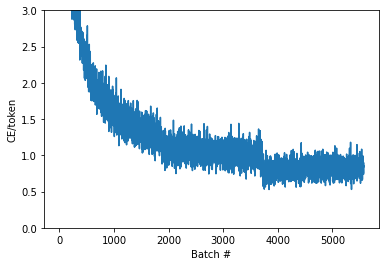

In [62]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate

Now that the model is trained, implement a function to execute the full `text => text` translation.

For this the model needs to invert the `text => token IDs` mapping provided by the `output_text_processor`. It also needs to know the IDs for special tokens. This is all implemented in the constructor for the new class. The implementation of the actual translate method will follow.

Overall this is similar to the training loop, except that the input to the decoder at each time step is a sample from the decoder's last prediction.

In [63]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [64]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/tmpfs/tmp/ipykernel_44101/100404259.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


### Convert token IDs to text

The first method to implement is `tokens_to_text` which converts from token IDs to human readable text.

In [65]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [66]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

In [67]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'walking solving', b'blames superior', b'spending duck',
       b'piano sip', b'background friday'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [68]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [69]:
Translator.sample = sample

Test run this function on some random inputs:

In [70]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4897],
       [3051],
       [ 652],
       [  76],
       [1487]])>

### Implement the translation loop

Here is a complete implementation of the text to text translation loop.

This implementation collects the results into python lists, before using `tf.concat` to join them into tensors.

This implementation statically unrolls the graph out to `max_length` iterations.
This is okay with eager execution in python.

In [71]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [72]:
Translator.translate = translate_unrolled

Run it on a simple input:

In [73]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 144 ms


If you want to export this model you'll need to wrap this method in a `tf.function`. This basic implementation has a few issues if you try to do that:

1. The resulting graphs are very large and take a few seconds to build, save or load.
2. You can't break from a statically unrolled loop, so it will always run `max_length` iterations, even if all the outputs are done. But even then it's marginally faster than eager execution.


In [74]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [75]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 18.8 s


In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its cold here .
this is my life .

CPU times: user 119 ms, sys: 0 ns, total: 119 ms
Wall time: 76.6 ms


In [77]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [78]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [79]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

it is very cold here .
this is my life .

CPU times: user 191 ms, sys: 0 ns, total: 191 ms
Wall time: 186 ms


But when you wrap it in a `tf.function` you'll notice two differences.

In [80]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [81]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.05 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [82]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

its very cold here .
this is my life .

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 14 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [83]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.0000001  1.         0.99999994 1.         1.         1.0000001 ]


Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

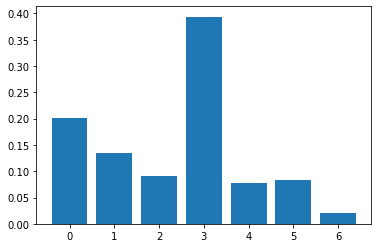

In [84]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

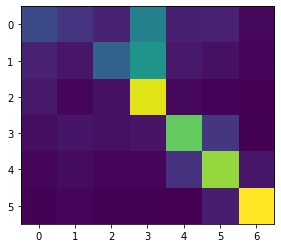

In [85]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [86]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

/tmpfs/tmp/ipykernel_44101/143215515.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_44101/143215515.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


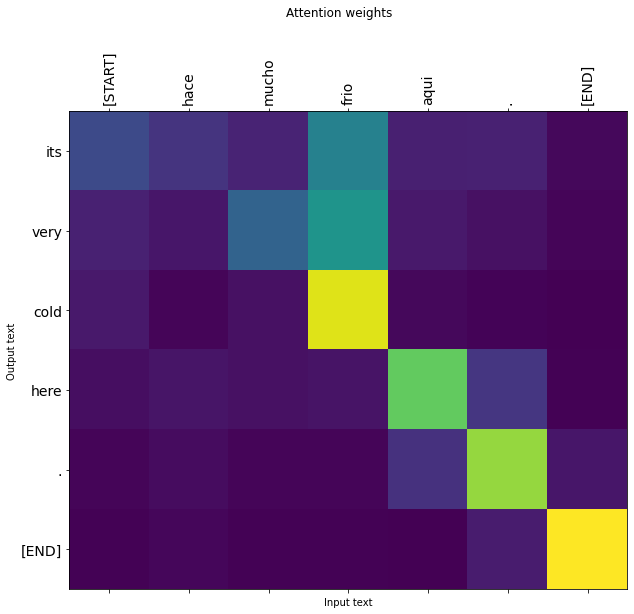

In [87]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Translate a few more sentences and plot them:

In [88]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
lets try to figure out .

CPU times: user 39.7 ms, sys: 34 ms, total: 73.6 ms
Wall time: 17 ms


In [89]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'this is my life .', b'are you still at home ?',
       b'lets try to figure out .'], dtype=object)>

/tmpfs/tmp/ipykernel_44101/143215515.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_44101/143215515.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


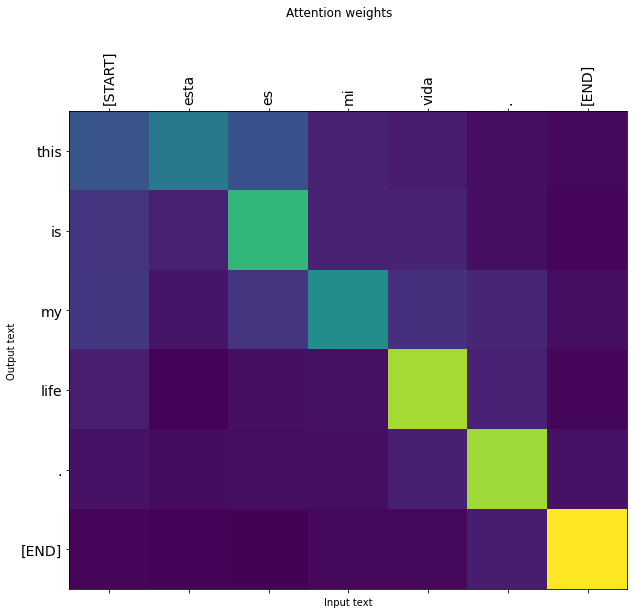

In [90]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/tmp/ipykernel_44101/143215515.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_44101/143215515.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


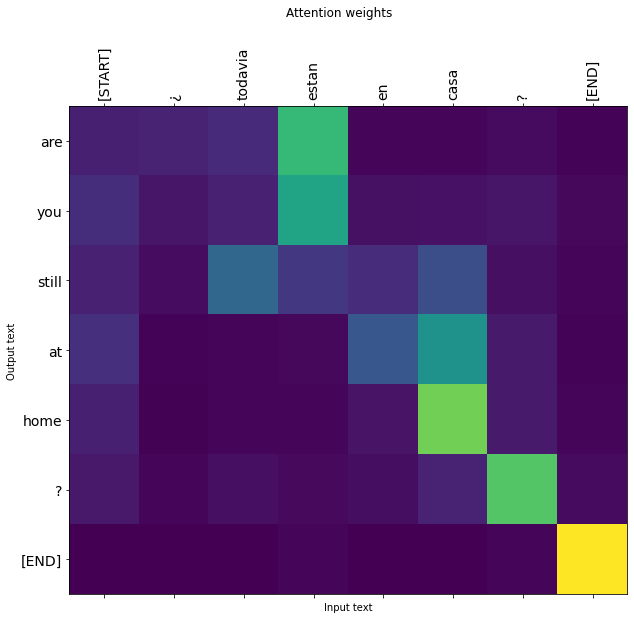

In [91]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmpfs/tmp/ipykernel_44101/143215515.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_44101/143215515.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


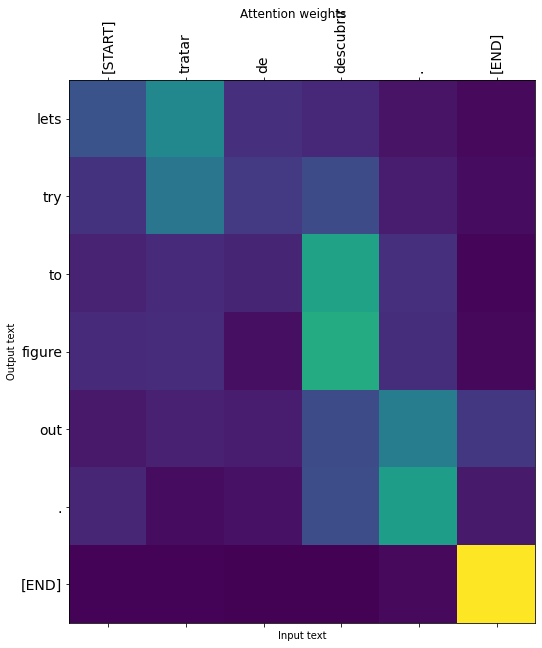

In [92]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state gets corrupted, there's no way for the model to recover. [Transformers](transformer.ipynb) solve this by using self-attention in the encoder and decoder.

In [93]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


/tmpfs/tmp/ipykernel_44101/143215515.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmpfs/tmp/ipykernel_44101/143215515.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


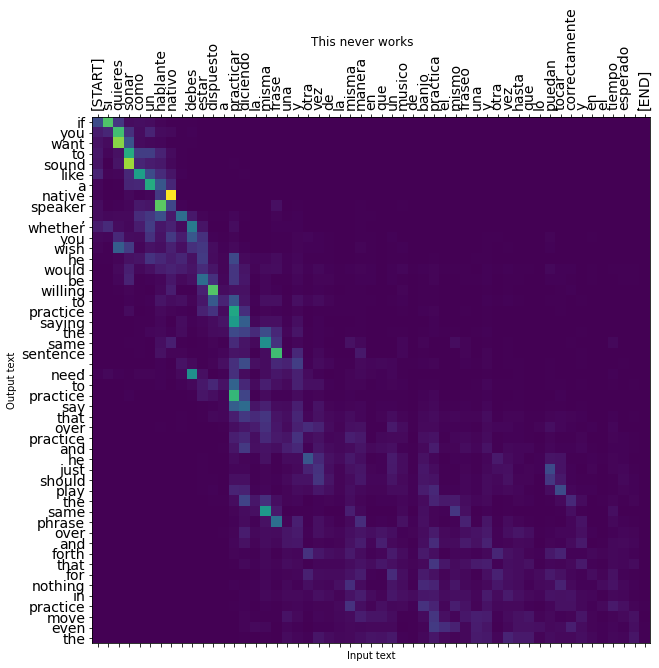

In [94]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

## Export

Once you have a model you're satisfied with you might want to export it as a `tf.saved_model` for use outside of this python program that created it.

Since the model is a subclass of `tf.Module` (through `keras.Model`), and all the functionality for export is compiled in a `tf.function` the model should export cleanly with `tf.saved_model.save`:

Now that the function has been traced it can be exported using `saved_model.save`:

In [95]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

2022-08-04 12:31:40.935911: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [96]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [97]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

this is my life .
are you still at home ?
try to find out .

CPU times: user 31.6 ms, sys: 7.17 ms, total: 38.7 ms
Wall time: 16.1 ms


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/){:.external} to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.